## Below the steps to identify the most promising stocks using the NCAV approach

1. have an excel file with all the tickers extracted from a filter on tradingview
2. load the tickers from the file and compute the ones having current assets > total liab
3. filter out the ones not respecting condition 2
4. compute the ncav(ps) and liqv(ps) of the last annual report
5. create a flag column "below ncav" indicating whether the price is below ncavps
6. create a flag column "below liqv" indicating whether the price is below liqvps
7. create a flag column if both 5 and 6 are respected
8. take the tickers respecting any of the condition 5, 6 or 7 and create the history plots
9. Select by hand the most promising ones
10. for the selected ones get the price to ncav ratio and price to liqv ratio
11. Sort by any of the two and see the most promising tickers

## Imports

In [1]:
import certifi
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from urllib.request import urlopen
from valuation.extraction import *
from valuation.liquidation import *
from valuation.constants import *
from valuation.eps_multiple import compute_de_ratio
from valuation.utils import plot_indicators_ncav

## Functions

In [ ]:
def compute_prelim_ncav(deco):
    return deco["totalCurrentAssets"] - deco["totalLiabilities"] > 0

def fill_w_none(deco, key):
    if key not in deco:
        deco[key] = 0

def get_price(deco):
    return deco["price"]

def compute_ncav(deco) -> float:
    return deco["totalCurrentAssets"] - deco["totalLiabilities"]

def compute_liqv(deco, factors_deco) -> float:
    fill_w_none(deco, "cashAndCashEquivalents")
    fill_w_none(deco, "netReceivables")
    fill_w_none(deco, "inventory")
    fill_w_none(deco, "propertyPlantEquipmentNet")
    return (
        deco["cashAndCashEquivalents"] +
        factors_deco["receivables_factor"]*deco["netReceivables"] +
        factors_deco["inventory_factor"]*deco["inventory"] +
        factors_deco["ppe_factor"]*deco["propertyPlantEquipmentNet"] -
        deco["totalLiabilities"]
    )

def compute_ncavps(deco) -> float:
    if deco["weightedAverageShsOutDil"] == 0:
        return -np.Inf
    ncav = compute_ncav(deco)
    return ncav / deco["weightedAverageShsOutDil"]

def compute_liqvps(deco, factors_deco) -> float:
    if deco["weightedAverageShsOutDil"] == 0:
        return -np.Inf
    liqv = compute_liqv(deco, factors_deco)
    return liqv / deco["weightedAverageShsOutDil"]

def compute_current_ratio(deco) -> float:
    return deco["totalCurrentAssets"] / (deco["totalCurrentLiabilities"] + 0.1)

def compute_de_ratio1(deco) -> float:
    return deco["totalLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio2(deco) -> float:
    return deco["totalCurrentLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio3(deco) -> float:
    return deco["totalDebt"] / (deco["totalStockholdersEquity"] + 0.1)

def plot_indicators(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, 11, figsize=(30, 2))
    fs_df["ncavps"].plot.bar(ax=ax[0], title = "ncavps")
    df["liqvps"].plot.bar(ax=ax[1], title = "liqvps")
    df["totalCurrentAssets"].plot.bar(ax=ax[2], title = "current assets")
    df["totalCurrentLiabilities"].plot.bar(ax=ax[3], title = "current liab")
    min_ylim, max_ylim = (
        min(df["totalCurrentAssets"].min(), df["totalCurrentLiabilities"].min()),
        max(df["totalCurrentAssets"].max(), df["totalCurrentLiabilities"].max())
    )
    ax[2].set_ylim([min_ylim, max_ylim])
    ax[3].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    df["current_ratio"].plot.bar(ax=ax[4], title = "current ratio")
    df["totalAssets"].plot.bar(ax=ax[5], title = "total assets")
    df["totalLiabilities"].plot.bar(ax=ax[6], title = "total liab")
    min_ylim, max_ylim = (
        min(df["totalAssets"].min(), df["totalLiabilities"].min()),
        max(df["totalAssets"].max(), df["totalLiabilities"].max())
    )
    ax[5].set_ylim([min_ylim, max_ylim])
    ax[6].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    df["weightedAverageShsOutDil"].plot.bar(ax=ax[7], title = "shares outs")
    df["de_ratio1"].plot.bar(ax=ax[8], title = "total liab / shares outs")
    df["de_ratio2"].plot.bar(ax=ax[9], title = "current liab / shares outs")
    df["de_ratio3"].plot.bar(ax=ax[10], title = "total debt / shares outs")
    min_ylim, max_ylim = (
        min(df["de_ratio1"].min(), df["de_ratio2"].min(), df["de_ratio3"].min()),
        max(df["de_ratio1"].max(), df["de_ratio2"].max(), df["de_ratio3"].max())
    )
    ax[8].set_ylim([min_ylim, max_ylim])
    ax[9].set_ylim([min_ylim, max_ylim])
    ax[10].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    plt.show()

## Constants

In [ ]:
KEY_PATH = "fmi-personal-key.txt"
with open(KEY_PATH, "r") as f:
    KEY = f.read()

In [ ]:
factors = {
    "receivables_factor": 0.8,
    "inventory_factor": 0.6,
    "ppe_factor": 0.67,
}

In [2]:
bs_cols = [
    "symbol", "cashAndCashEquivalents", "netReceivables",
    "inventory", "propertyPlantEquipmentNet",
    "totalCurrentAssets", "totalAssets", "totalCurrentLiabilities", 
    "totalLiabilities", "totalStockholdersEquity",
    "totalDebt", "netDebt",
]
is_cols = [
    "weightedAverageShsOutDil",
]

# Load tickers

In [3]:
with open("tickers_list_28062023.txt", "r") as f:
    TICKERS = f.read().split("\n")

In [4]:
# this will get rid of duplicated tickers.
# THis means there will only be one ticker for different companies having the same symbol in different exchanges
TICKERS = list(set(TICKERS))

Below we compute the preliminary NCAV (current assets - total_liabilities). By doing this we strictly focus ourselves in filtering out the companies that will for sure not have a positive NCAV
We will filter out the companies that don't have a positive preliminary NCAV
On the rest of the accepted companies we will flag those having a current price below ncav, current price below liqv and current price below both ncav and liqv

In [9]:
COLS_WITH_SAME_SCALE = [
    ["totalCurrentAssets", "totalCurrentLiabilities"],
    ["totalAssets", "totalLiabilities"],
    ["de_ratio1", "de_ratio2", "de_ratio3"],
]

In [10]:
def plot_indicators_ncav(df: pd.DataFrame) -> None:
    num_cols = df.shape[1]
    num_plots = min(num_cols, 11)  # Limit to 11 subplots or the number of columns
    _, ax = plt.subplots(1, num_plots, figsize=(26, 3))

    for i in range(num_plots):
        col_name = COLS_TO_PLOT_NCAV[i]
        df[col_name].plot.bar(ax=ax[i], title=SUBPLOT_NAMES[col_name])
        for cols in COLS_WITH_SAME_SCALE:
            if col_name in cols:#["totalAssets", "totalLiabilities", "de_ratio1", "de_ratio2", "de_ratio3"]:
                #min_ylim, max_ylim = df[col_name].min(), df[col_name].max()
                min_ylim = df[cols].min().min() #min([df[col].min() for col in cols])
                max_ylim = df[cols].max().max() #max([df[col].max() for col in cols])
                ax[i].set_ylim([min_ylim, max_ylim])
                break

    plt.tight_layout()
    plt.show()

  0%|▏                                                                                                                      | 2/1013 [00:02<25:12,  1.50s/it]

WSTL.	 Current price: 1.66.	 NCAV: 8.861972079612821.	 LIQV: 7.124764412539166


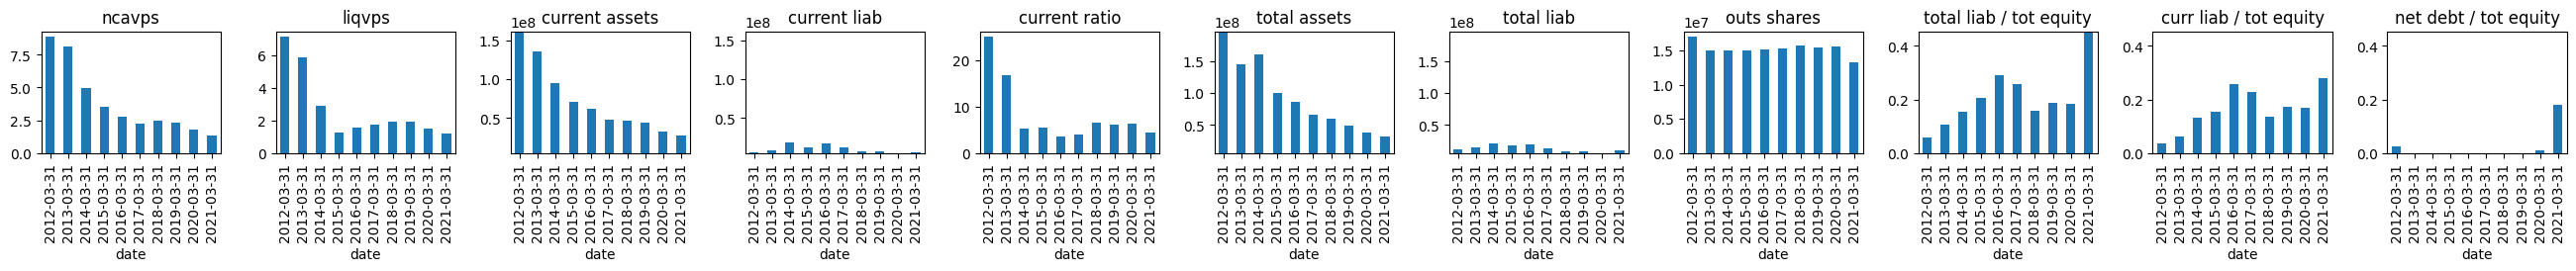

  0%|▍                                                                                                                      | 4/1013 [00:09<46:26,  2.76s/it]

CAAS.	 Current price: 3.84.	 NCAV: 6.293487800746959.	 LIQV: 1.6687888399774395


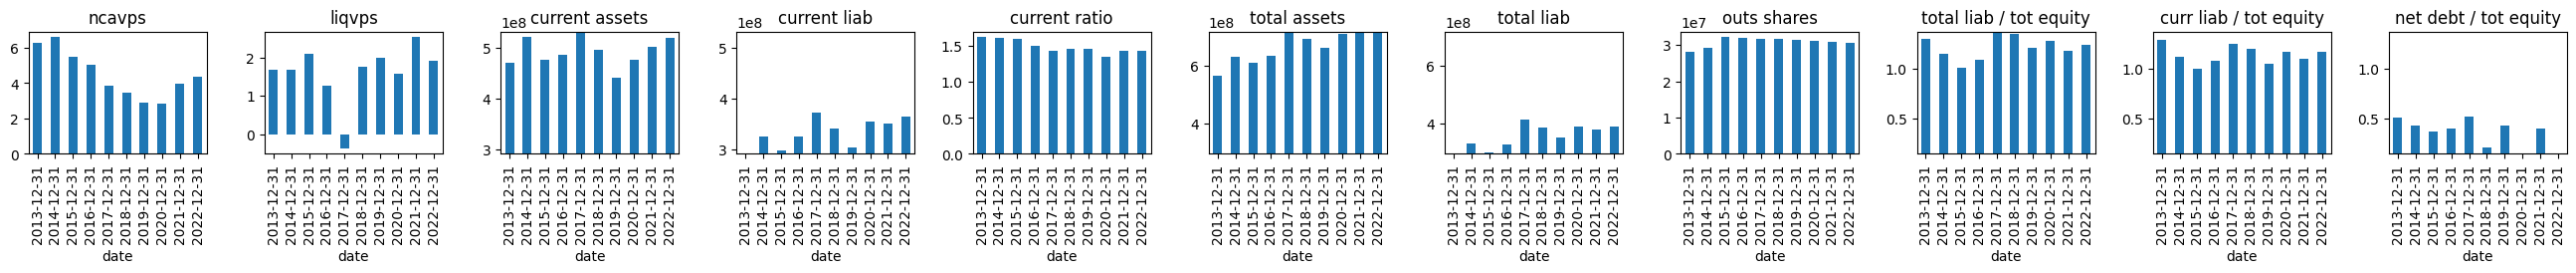

  1%|▉                                                                                                                      | 8/1013 [00:19<34:02,  2.03s/it]

CHCI.	 Current price: 4.8.	 NCAV: 5.6599845993721285.	 LIQV: -0.534652258899786


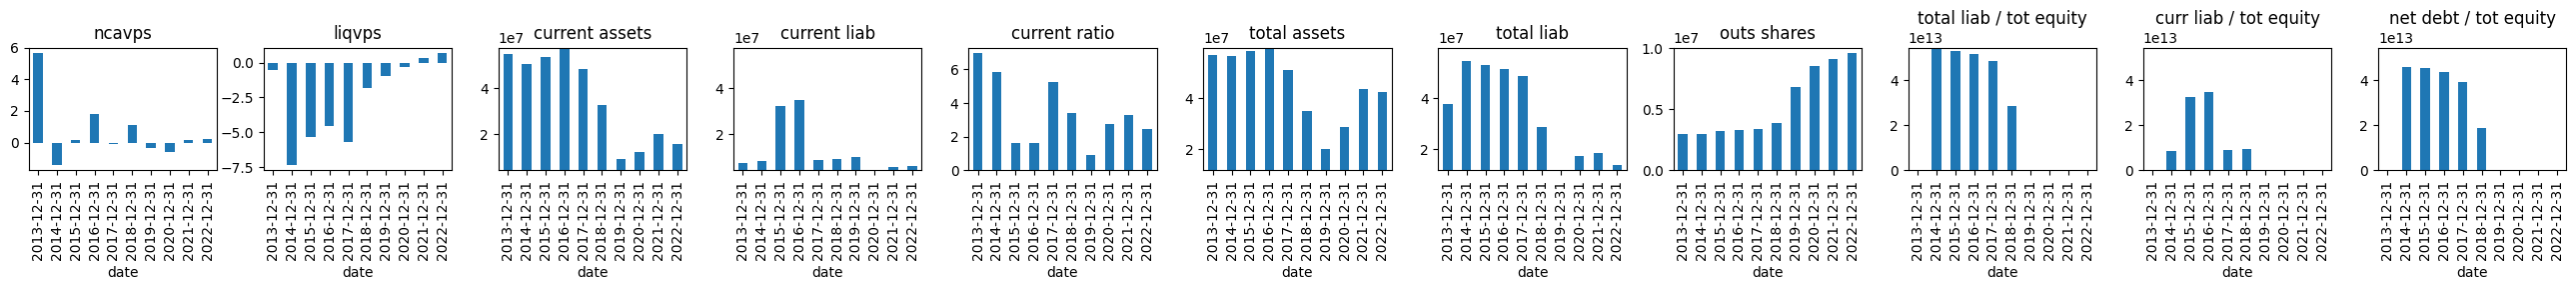

  1%|█▎                                                                                                                    | 11/1013 [00:28<41:15,  2.47s/it]

CTHR.	 Current price: 0.5602.	 NCAV: 1.3750690817989097.	 LIQV: 1.0658694340353272


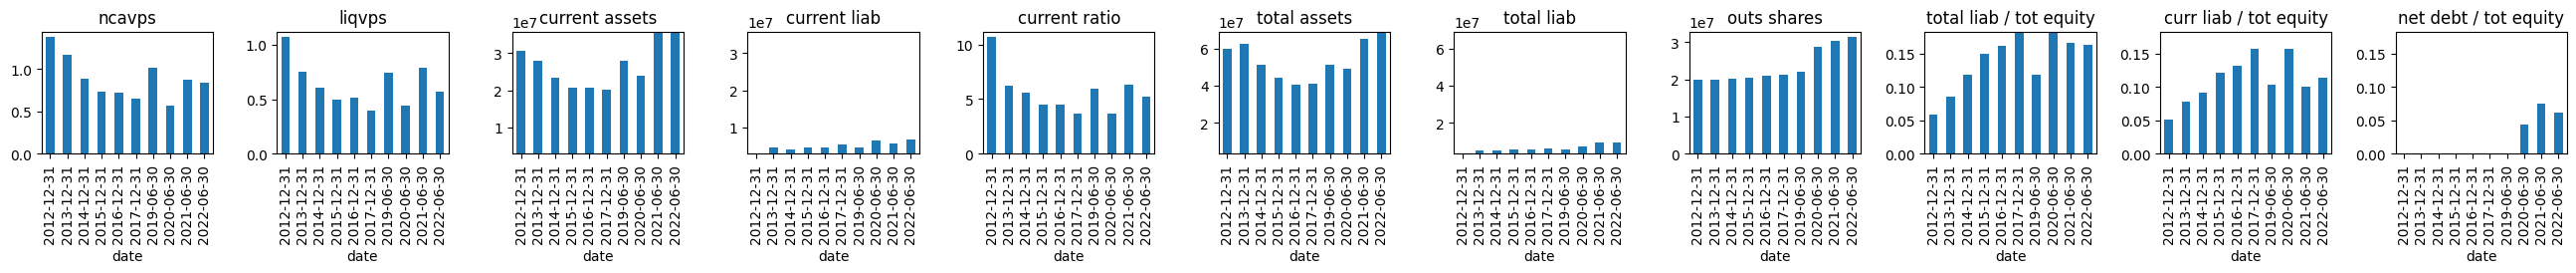

  3%|███▏                                                                                                                  | 27/1013 [00:51<18:16,  1.11s/it]

CGA.	 Current price: 2.3.	 NCAV: 75.73049233276335.	 LIQV: 74.39683748413371


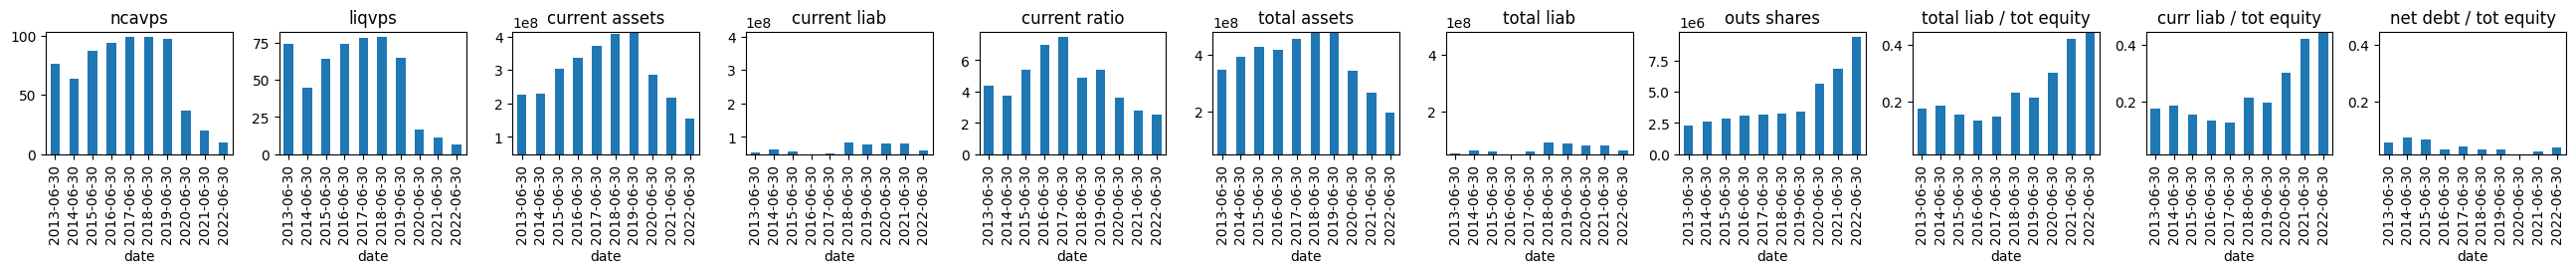

  4%|████▏                                                                                                                 | 36/1013 [01:07<27:44,  1.70s/it]

dates of last income statement and balance sheet are not the same for ticker SEV
	income stmt date: 2009-09-30, balance sheet date: 2011-09-30


  4%|████▌                                                                                                                 | 39/1013 [01:12<26:49,  1.65s/it]

RCAT.	 Current price: 0.96.	 NCAV: 1242.8695652173913.	 LIQV: 68.95652173913044


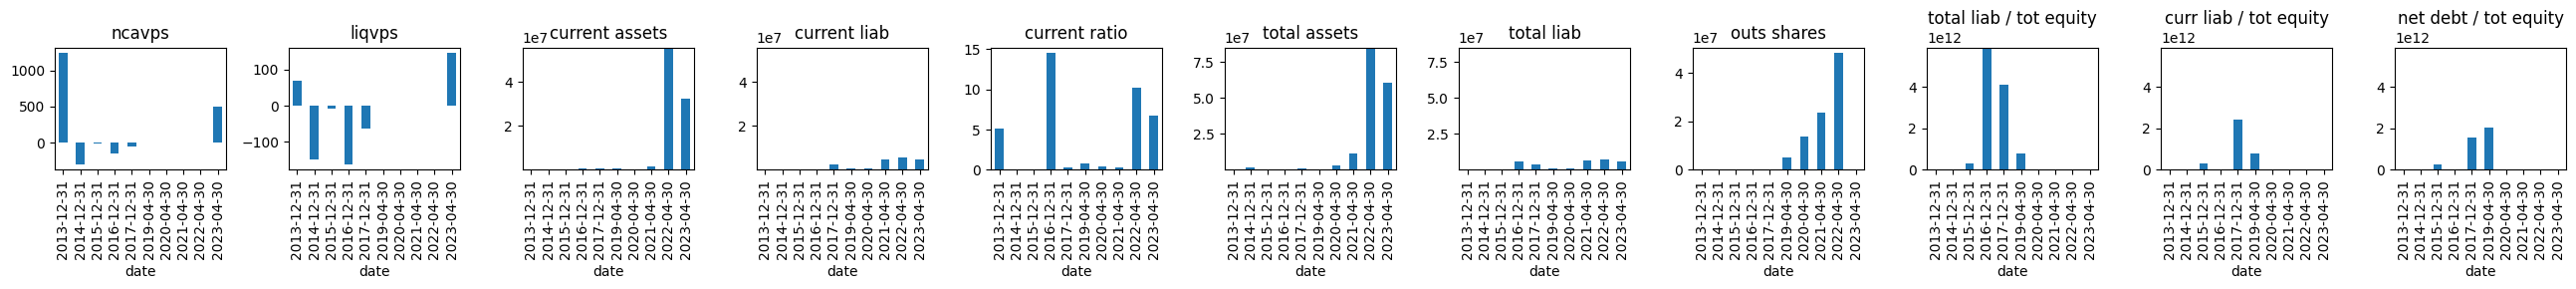

  4%|████▊                                                                                                                 | 41/1013 [01:19<38:25,  2.37s/it]

XWEL.	 Current price: 2.14.	 NCAV: 182.2753438375804.	 LIQV: 174.43750405256446


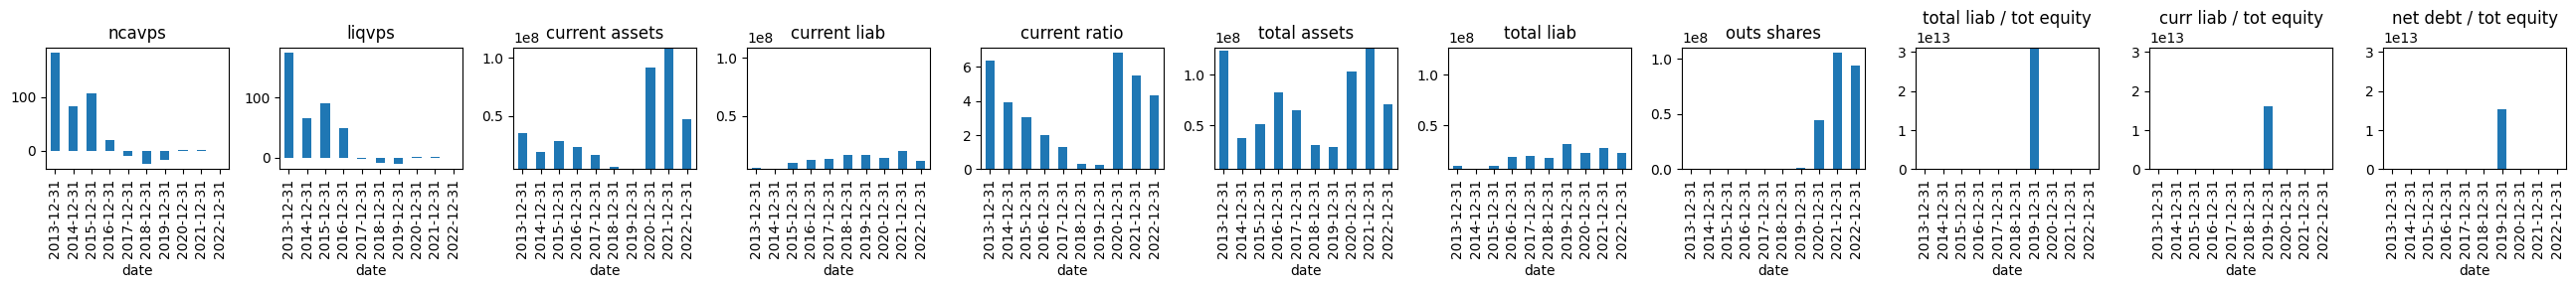

  4%|████▉                                                                                                                 | 42/1013 [01:23<49:21,  3.05s/it]

MINM.	 Current price: 1.46.	 NCAV: 7.60457512082644.	 LIQV: 3.6592173312663654


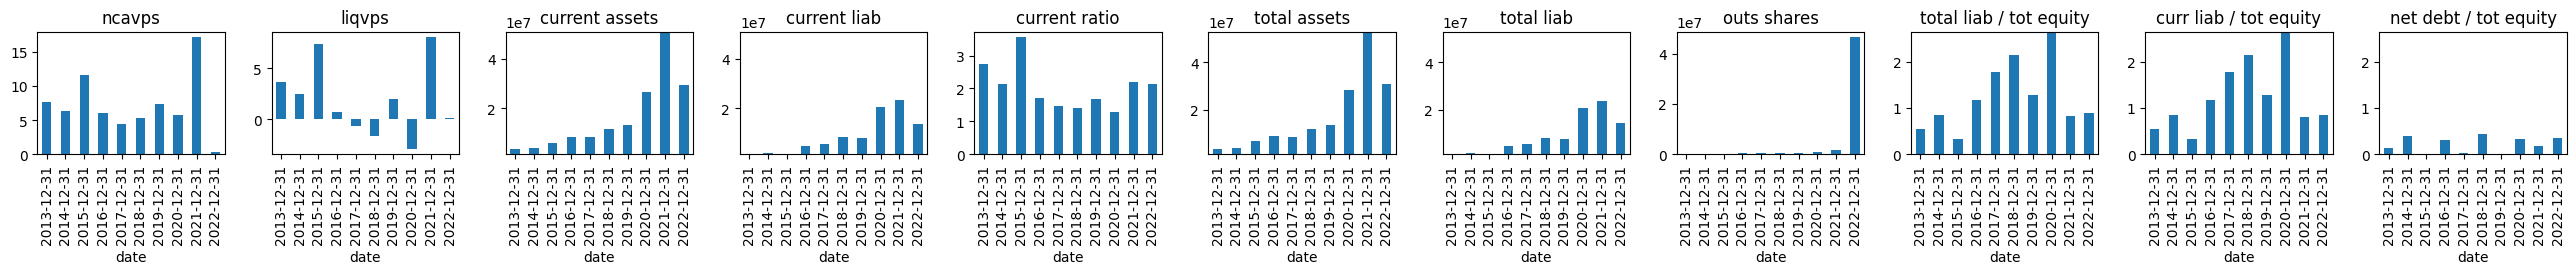

  5%|█████▍                                                                                                                | 47/1013 [01:36<37:49,  2.35s/it]

SRL.	 Current price: 5.88.	 NCAV: 6.641652819154571.	 LIQV: 19.154335330004663


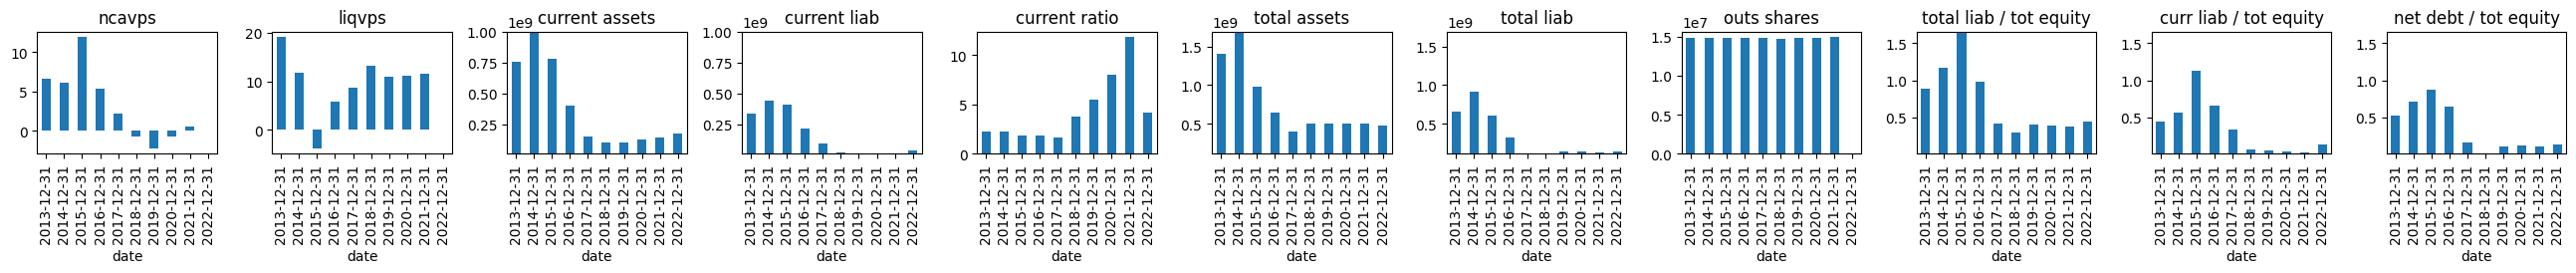

  5%|█████▌                                                                                                                | 48/1013 [01:40<48:17,  3.00s/it]

TORM.	 Current price: 1.92.	 NCAV: 9.397208121827411.	 LIQV: 32.9804885786802


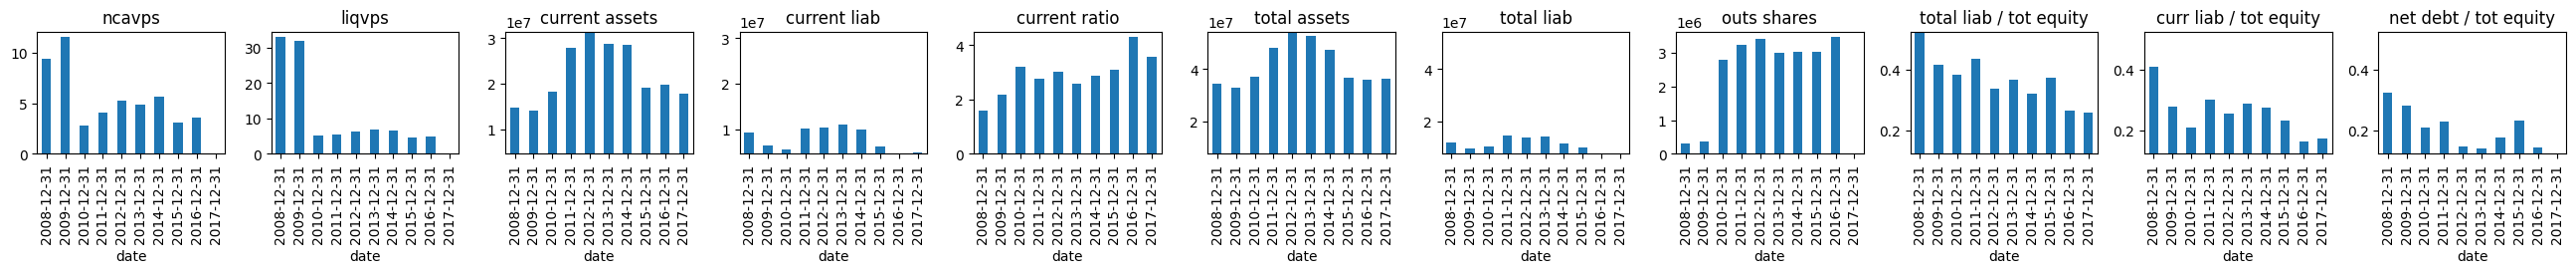

  5%|██████▏                                                                                                               | 53/1013 [01:49<28:59,  1.81s/it]

AAU.	 Current price: 0.137.	 NCAV: 0.20427312312546292.	 LIQV: 0.45808338546586114


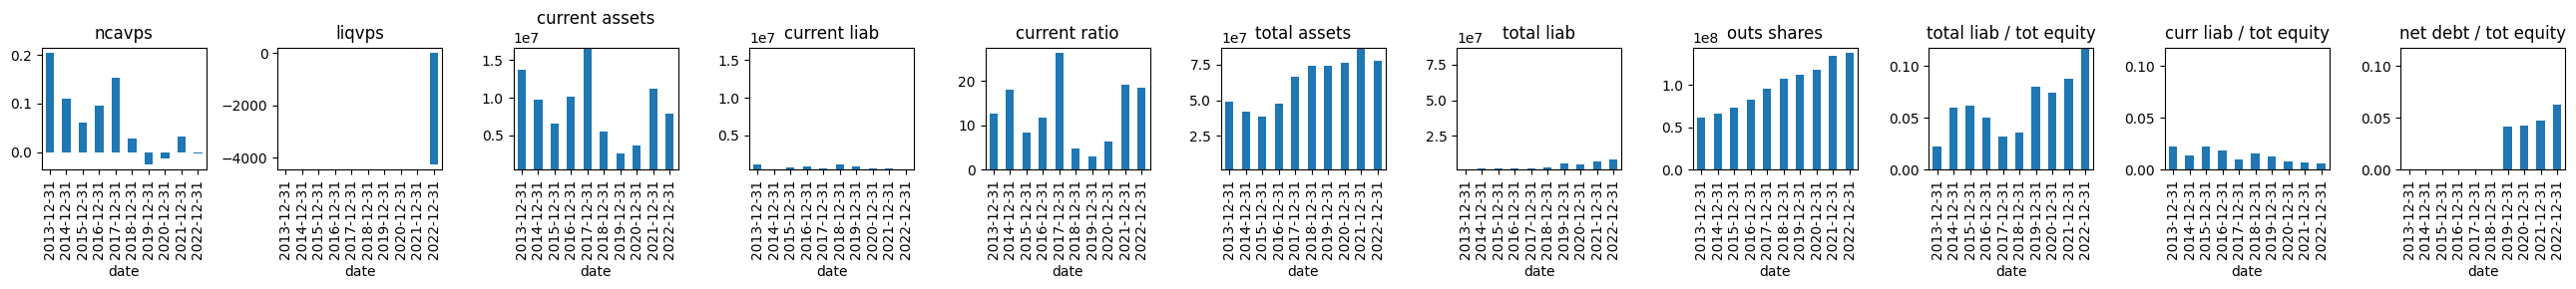

  6%|██████▌                                                                                                               | 56/1013 [01:57<33:24,  2.09s/it]

dates of last income statement and balance sheet are not the same for ticker SLV
	income stmt date: 2008-12-31, balance sheet date: 2013-12-31


  7%|████████▋                                                                                                             | 75/1013 [02:25<20:48,  1.33s/it]

TIO.	 Current price: 0.9898.	 NCAV: 4.318819631362738.	 LIQV: 2.1328629967998407


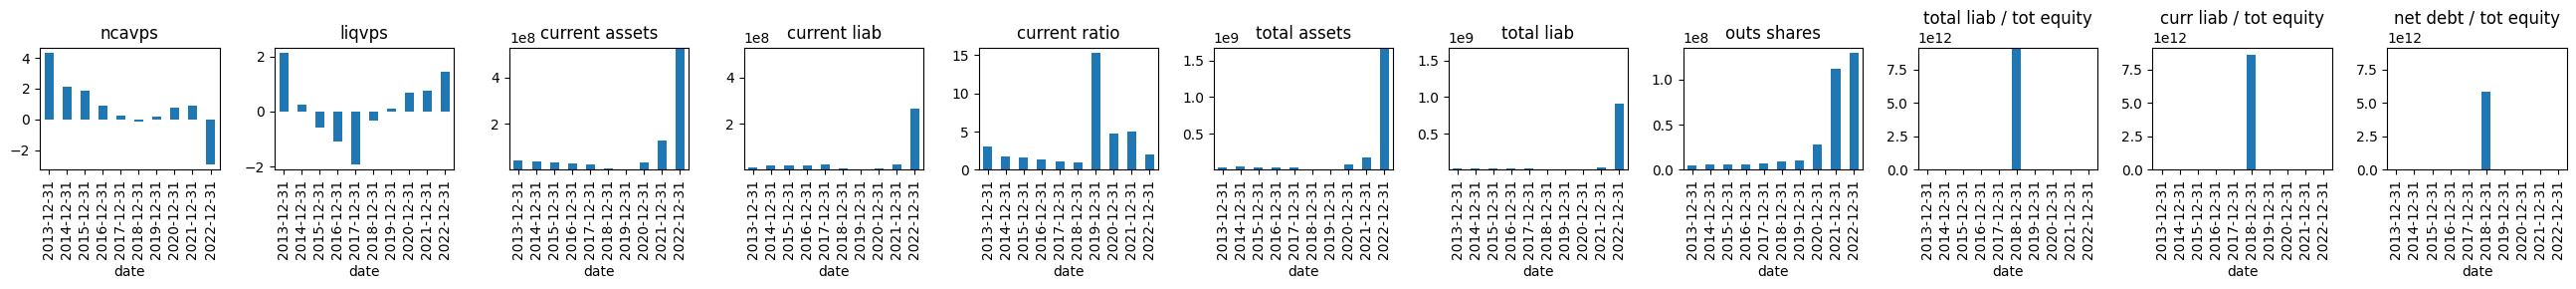

  8%|█████████▉                                                                                                            | 85/1013 [02:40<16:58,  1.10s/it]

MTC.	 Current price: 0.4701.	 NCAV: 0.5476489898989899.	 LIQV: 0.5126749747474747


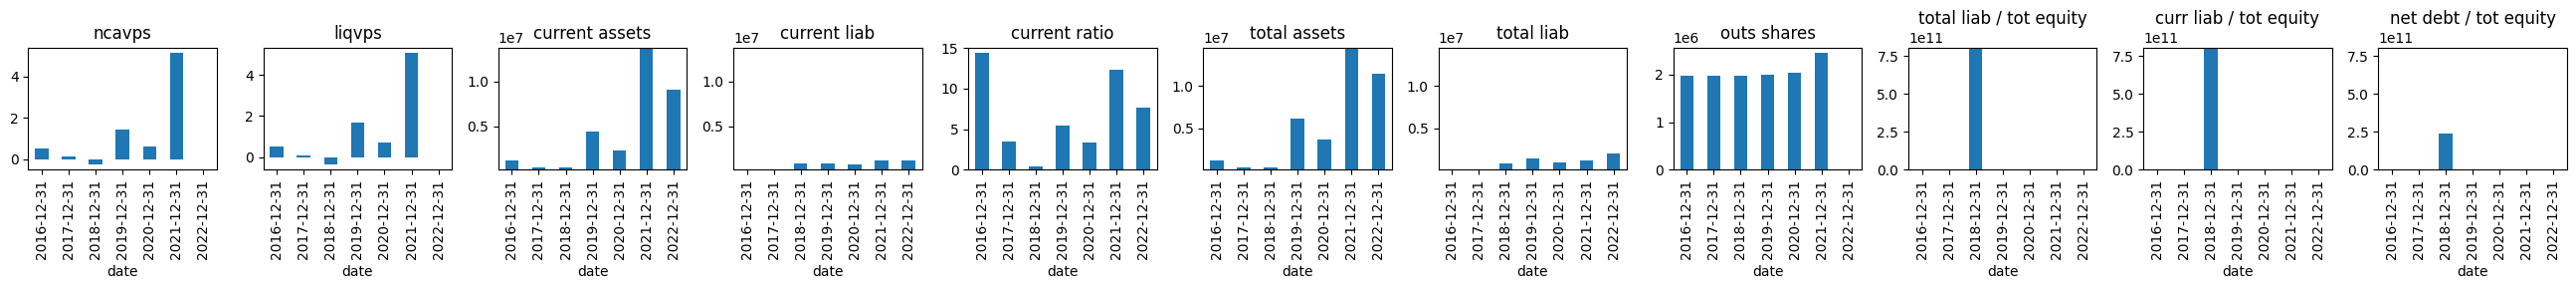

  9%|██████████▏                                                                                                           | 87/1013 [02:46<26:33,  1.72s/it]

AXTI.	 Current price: 2.39.	 NCAV: 2.4851376146788993.	 LIQV: 2.0587666666666666


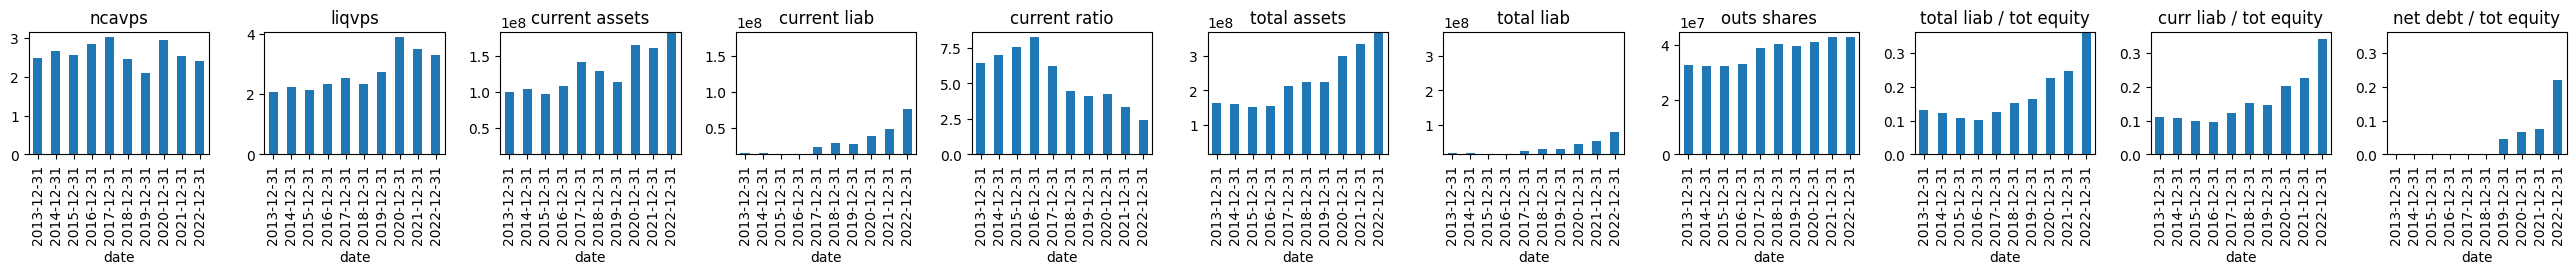

  9%|██████████▊                                                                                                           | 93/1013 [02:58<28:38,  1.87s/it]

dates of last income statement and balance sheet are not the same for ticker FMN
	income stmt date: 2010-11-30, balance sheet date: 2017-11-30


 10%|████████████▏                                                                                                        | 106/1013 [03:18<21:25,  1.42s/it]

ITP.	 Current price: 0.41.	 NCAV: -12.200232522358336.	 LIQV: 43.33804157881165


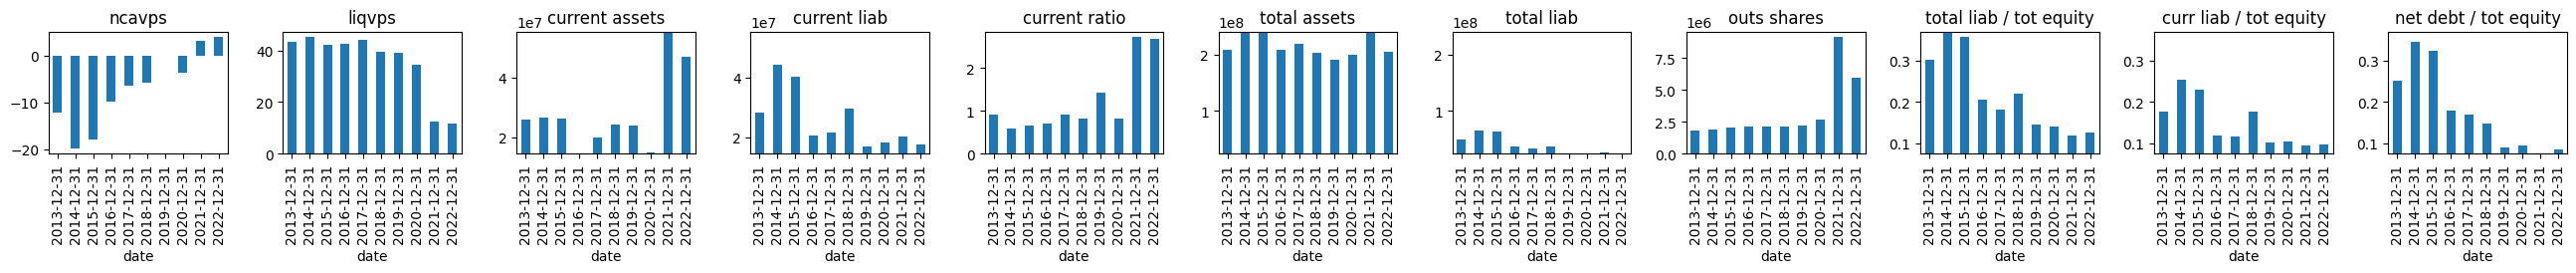

 11%|████████████▋                                                                                                        | 110/1013 [03:28<29:45,  1.98s/it]

dates of last income statement and balance sheet are not the same for ticker PRCX
	income stmt date: 2014-01-31, balance sheet date: 2013-01-31


 12%|█████████████▌                                                                                                       | 117/1013 [03:39<27:00,  1.81s/it]

ALYA.	 Current price: 1.51.	 NCAV: 2.191666666666667.	 LIQV: 1.7404166666666667


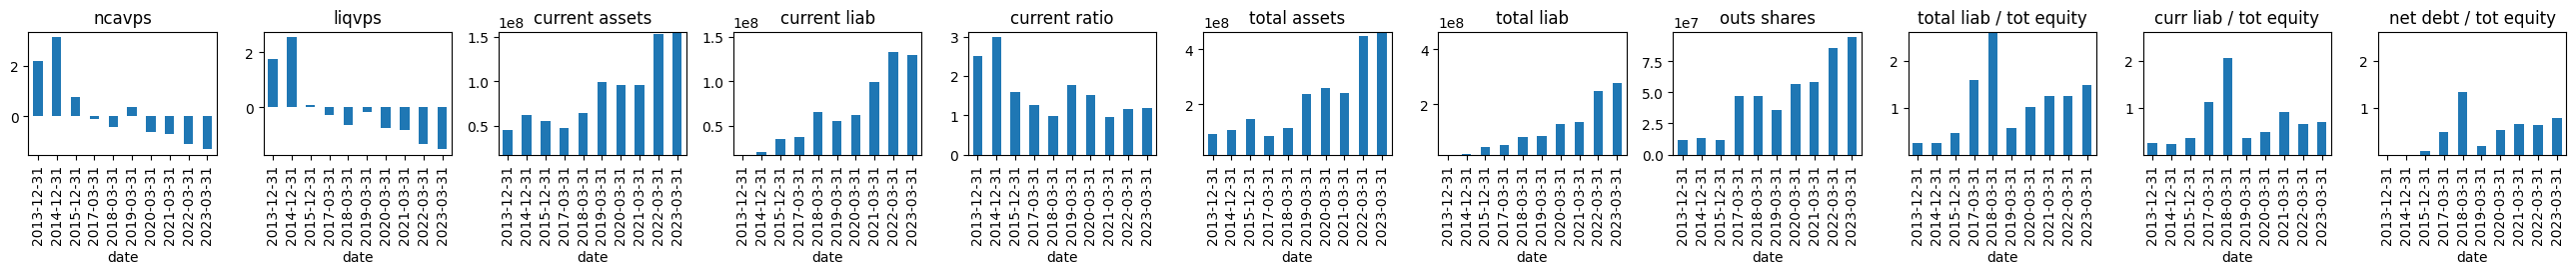

 12%|██████████████▍                                                                                                      | 125/1013 [03:51<15:57,  1.08s/it]

FLNT.	 Current price: 0.4399.	 NCAV: 0.9665894521703225.	 LIQV: 0.9549323483038052


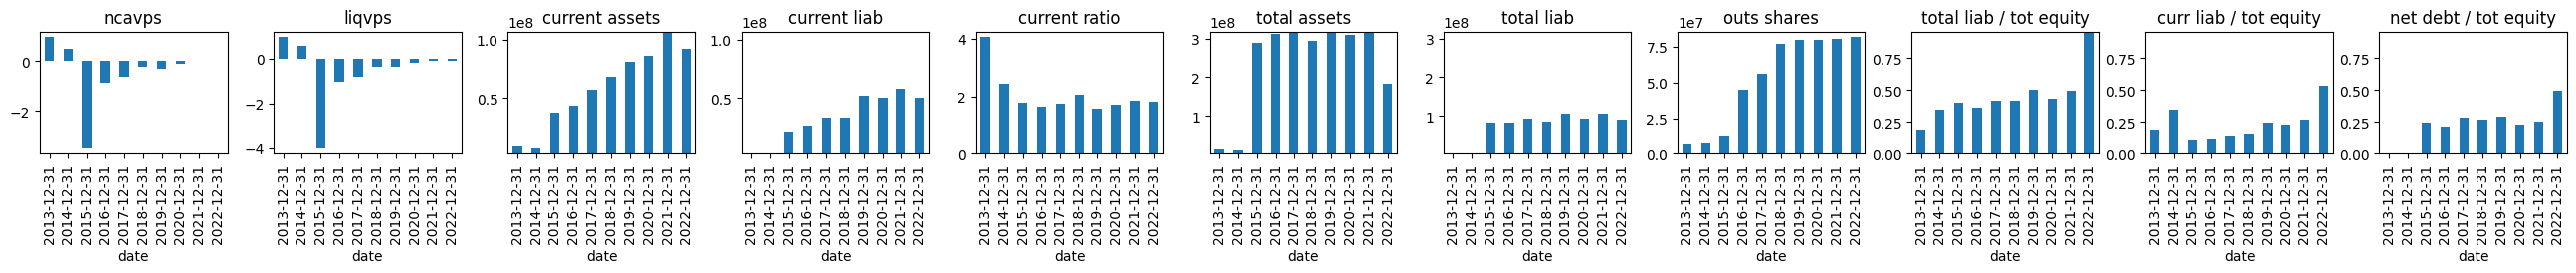

 13%|███████████████▋                                                                                                     | 136/1013 [04:10<17:04,  1.17s/it]

CTRM.	 Current price: 0.4156.	 NCAV: 4.6946208333333335.	 LIQV: 24.696196875


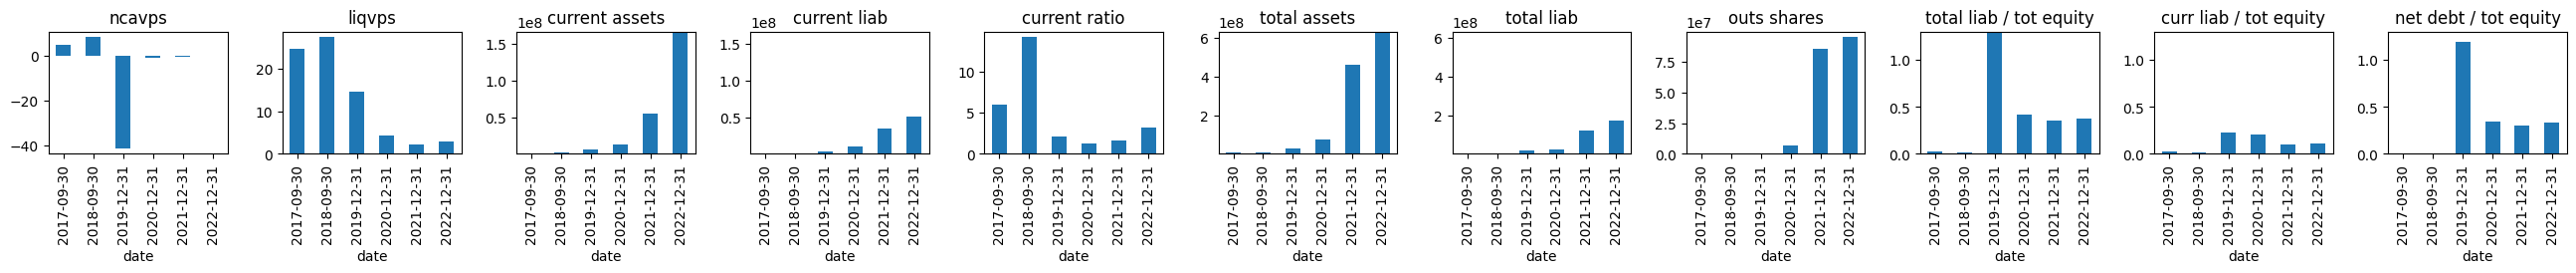

 15%|█████████████████▋                                                                                                   | 153/1013 [04:37<20:31,  1.43s/it]

ESEA.	 Current price: 27.14.	 NCAV: -61.54950663251384.	 LIQV: 59.36378239016961


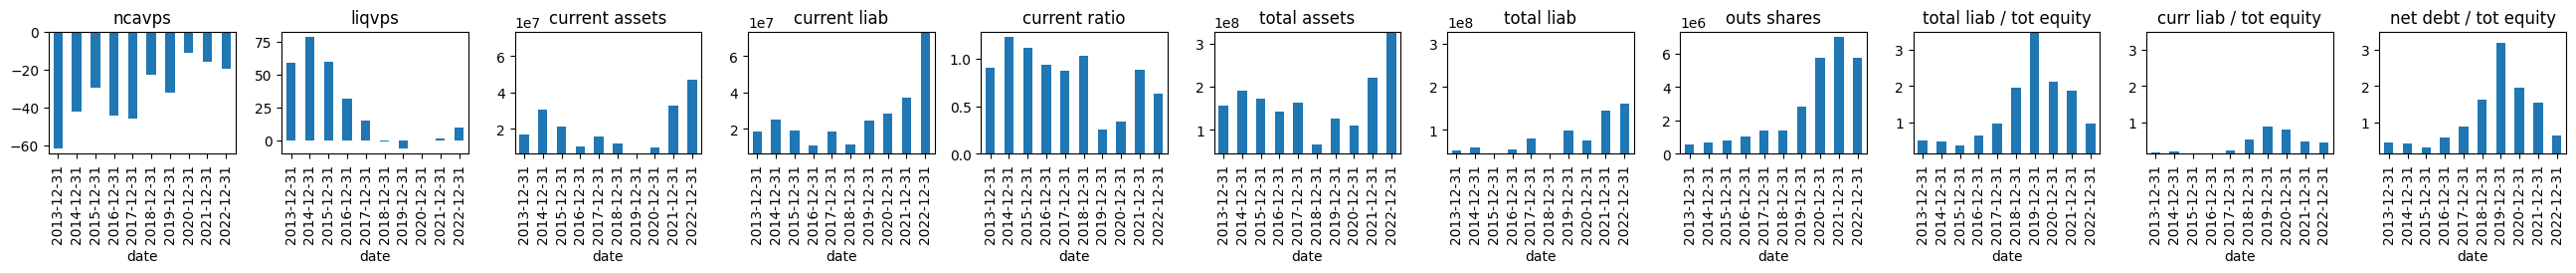

 16%|██████████████████▏                                                                                                  | 158/1013 [04:47<23:59,  1.68s/it]

dates of last income statement and balance sheet are not the same for ticker VST
	income stmt date: 2014-12-31, balance sheet date: 2015-12-31


 16%|██████████████████▍                                                                                                  | 160/1013 [04:49<16:55,  1.19s/it]

MULN.	 Current price: 0.45.	 NCAV: 0.7726595638551055.	 LIQV: -0.12753392622208579


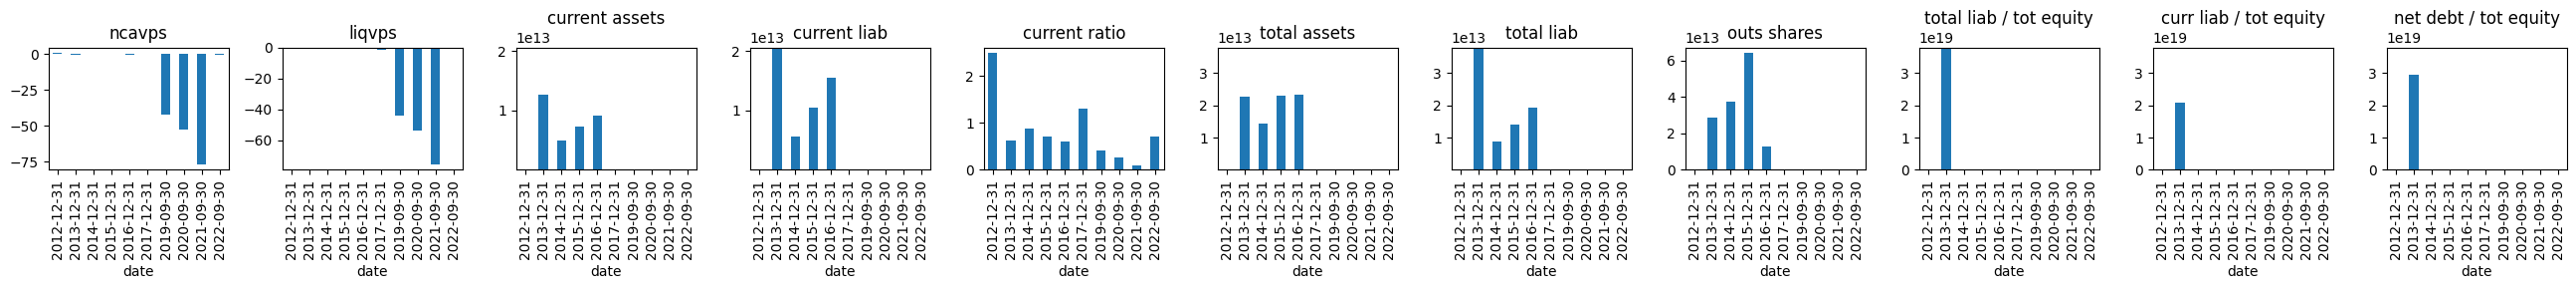

 17%|███████████████████▋                                                                                                 | 170/1013 [05:04<18:10,  1.29s/it]

GURE.	 Current price: 1.86.	 NCAV: 3.7041749715986136.	 LIQV: 5.972513409497898


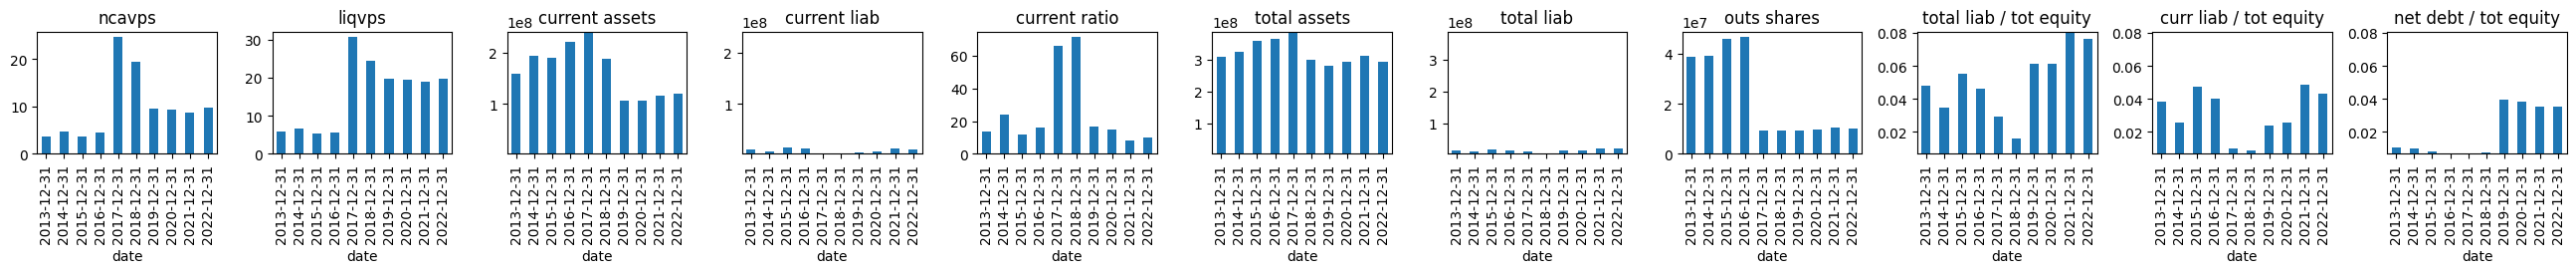

 18%|████████████████████▌                                                                                                | 178/1013 [05:17<17:45,  1.28s/it]

CAN.	 Current price: 1.84.	 NCAV: 6.341931459690194.	 LIQV: 0.18875694669543078


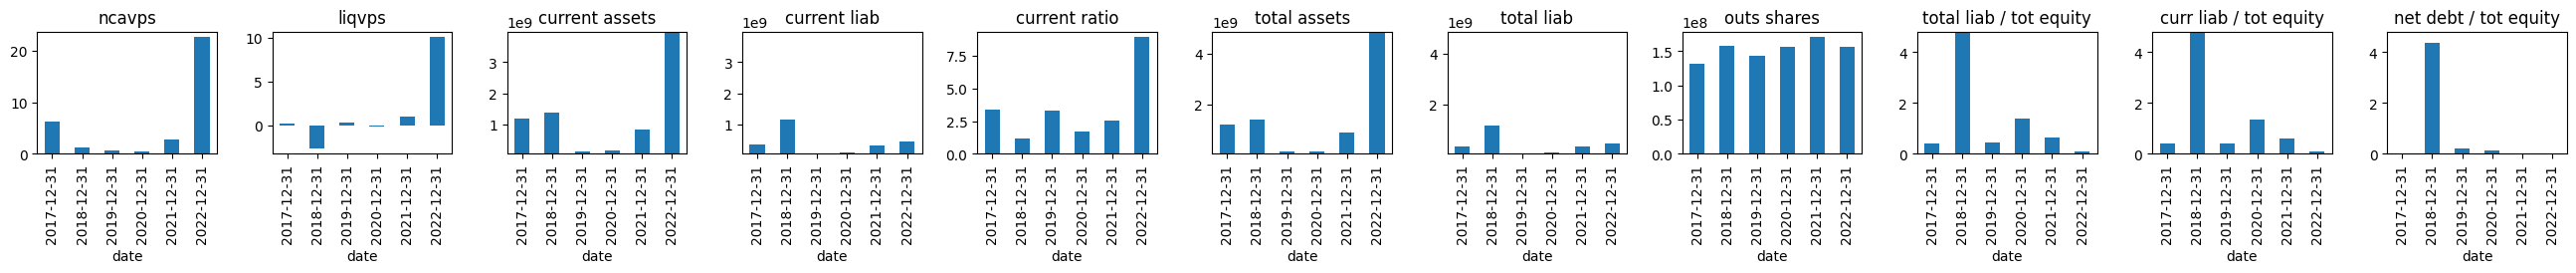

 19%|██████████████████████                                                                                               | 191/1013 [05:31<15:25,  1.13s/it]

EVGN.	 Current price: 0.5931.	 NCAV: 5.929781448919906.	 LIQV: 4.531479192771575


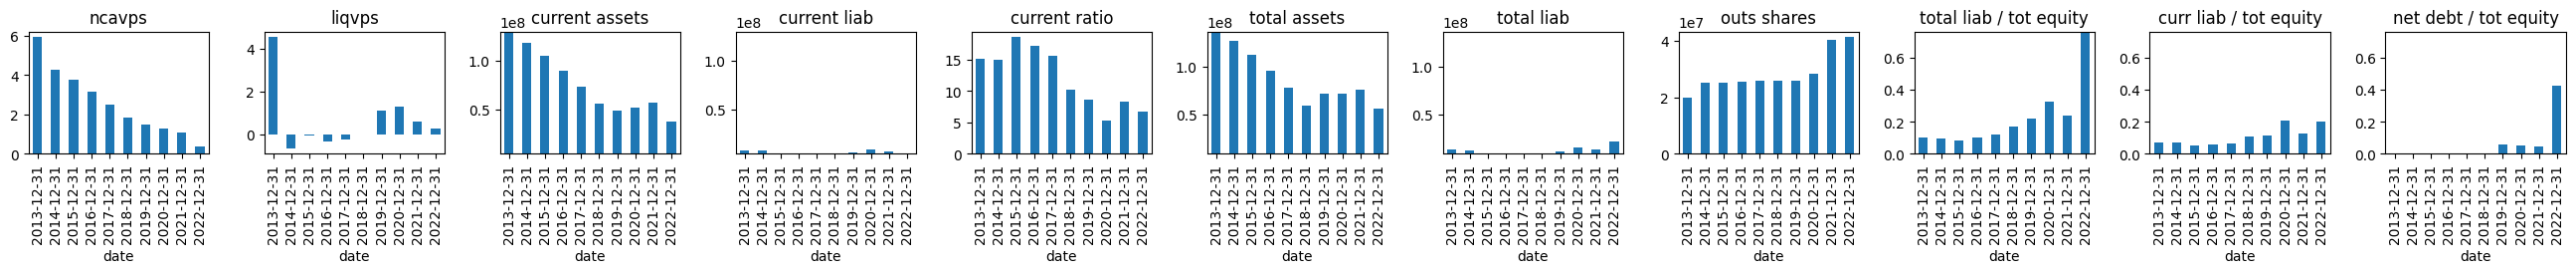

 20%|███████████████████████                                                                                              | 200/1013 [05:47<15:43,  1.16s/it]

DWSN.	 Current price: 2.37.	 NCAV: 0.7498947615724989.	 LIQV: 5.130867957364637


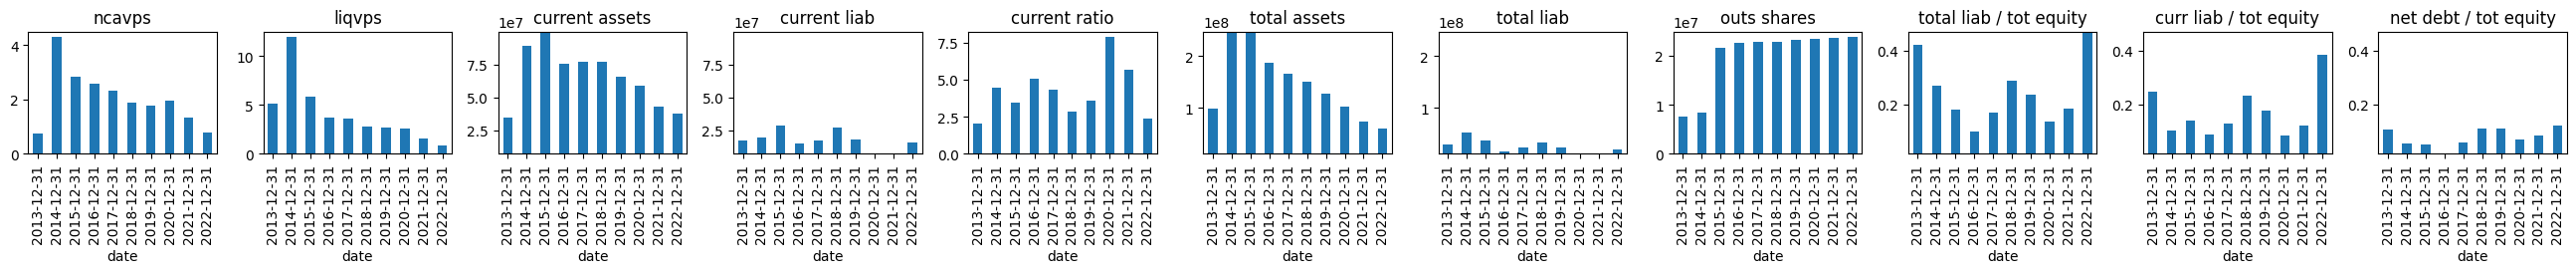

 20%|███████████████████████▌                                                                                             | 204/1013 [05:55<20:03,  1.49s/it]

VHC.	 Current price: 0.26.	 NCAV: 0.6636515593125468.	 LIQV: 0.2702685859652357


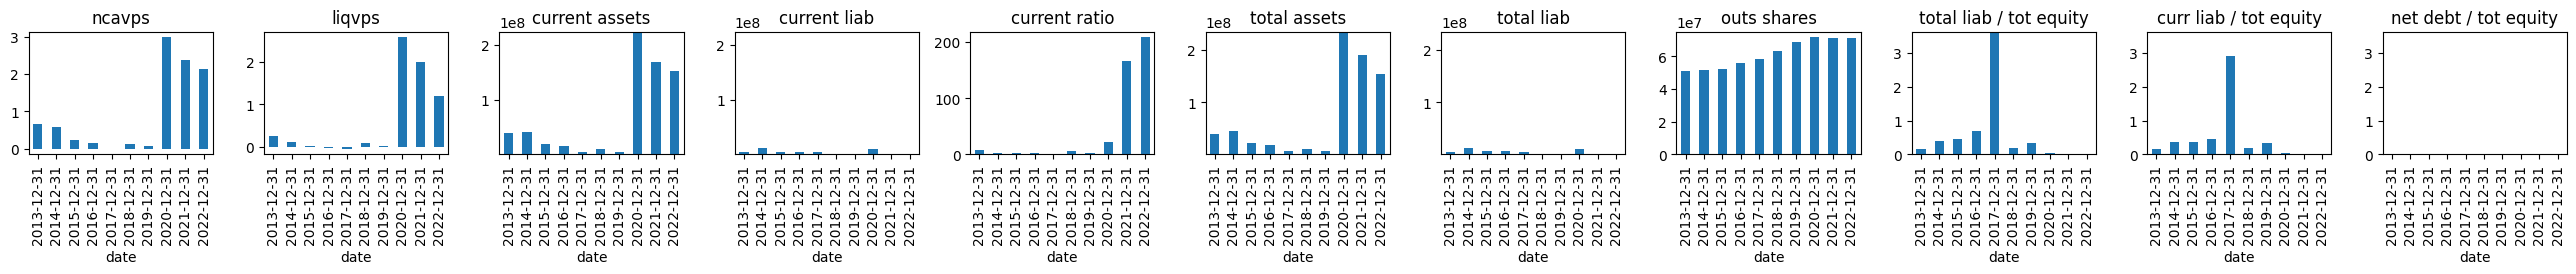

 22%|█████████████████████████▊                                                                                           | 224/1013 [06:19<13:04,  1.01it/s]

PZG.	 Current price: 0.283.	 NCAV: -1.8126680182669113.	 LIQV: 0.3261243819692258


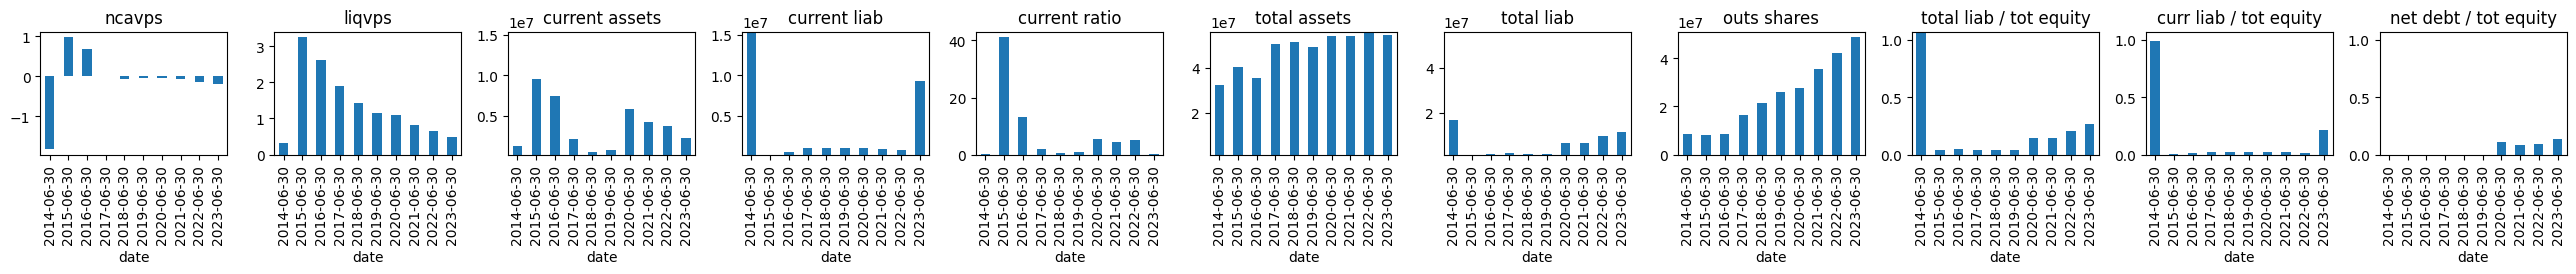

 23%|███████████████████████████▎                                                                                         | 236/1013 [06:36<14:45,  1.14s/it]

LIQT.	 Current price: 3.77.	 NCAV: 9.140966867030173.	 LIQV: 11.049091551694552


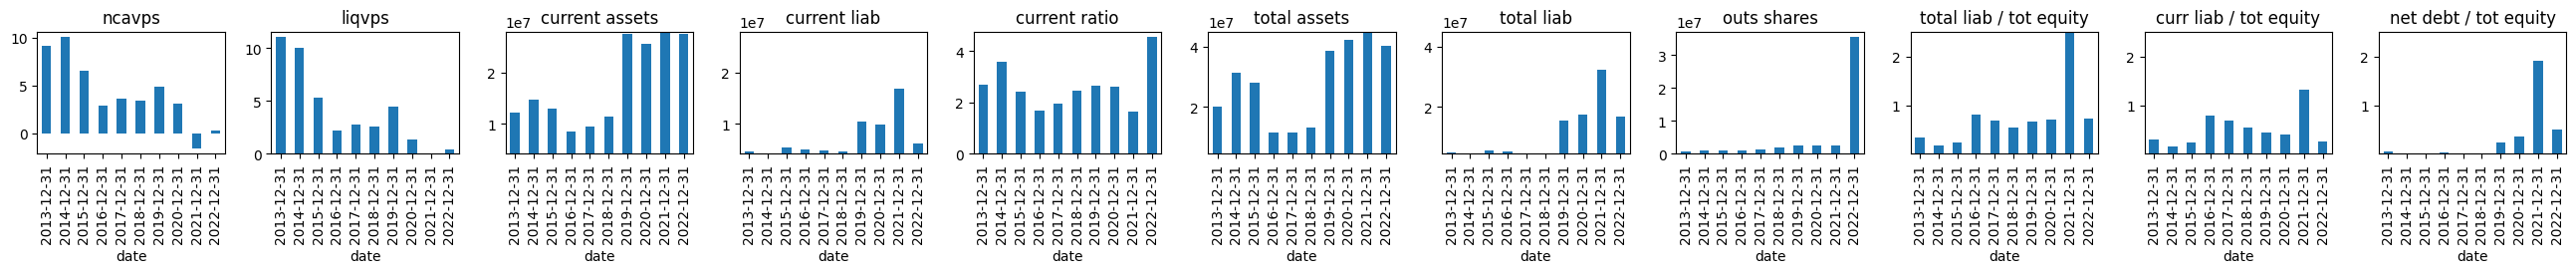

 24%|███████████████████████████▌                                                                                         | 239/1013 [06:43<23:58,  1.86s/it]

EMKR.	 Current price: 0.4813.	 NCAV: 1.0463985526365385.	 LIQV: 1.11670423278429


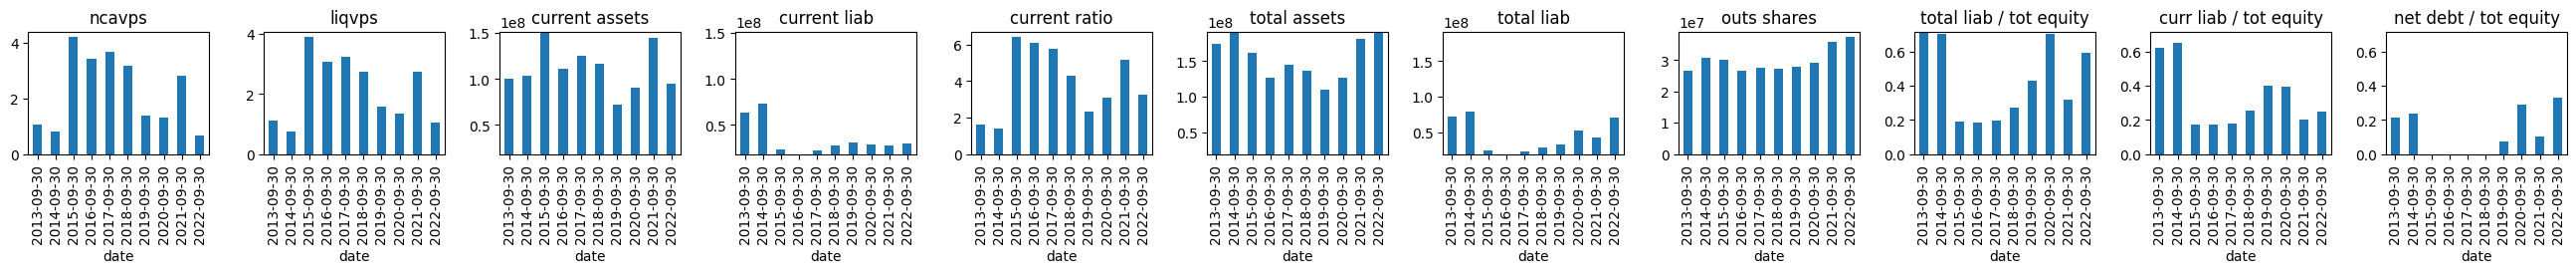

 24%|████████████████████████████▎                                                                                        | 245/1013 [06:52<13:28,  1.05s/it]

GVP.	 Current price: 0.2.	 NCAV: 1.4051082273262807.	 LIQV: 1.0918485376632527


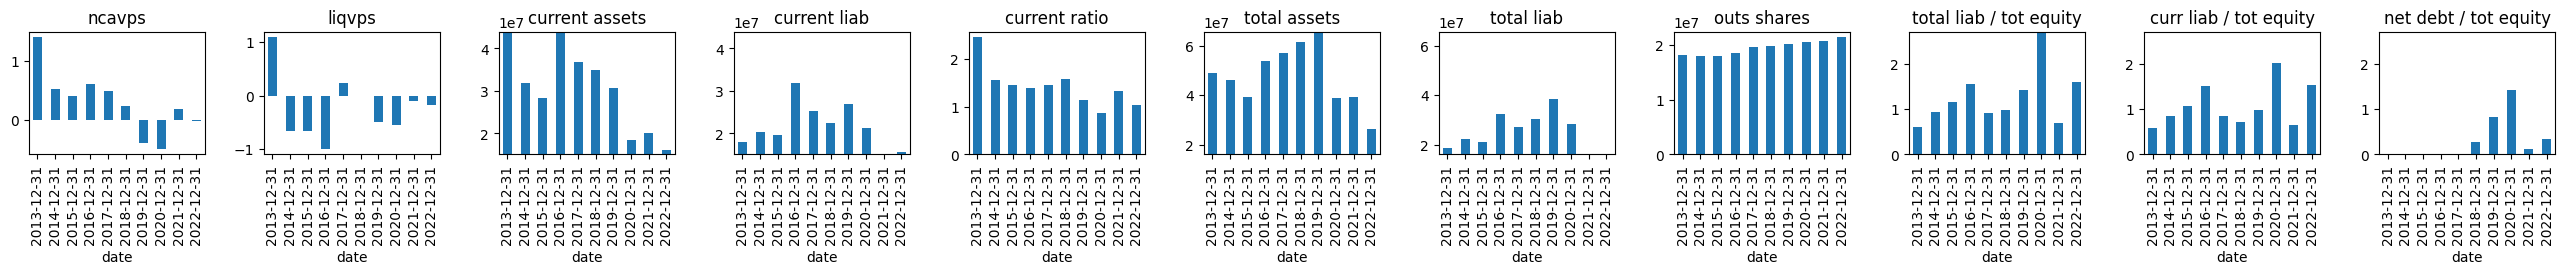

 24%|████████████████████████████▋                                                                                        | 248/1013 [06:58<19:31,  1.53s/it]

ELVT.	 Current price: 1.87.	 NCAV: 1.875019208834597.	 LIQV: 1.4970459075957623


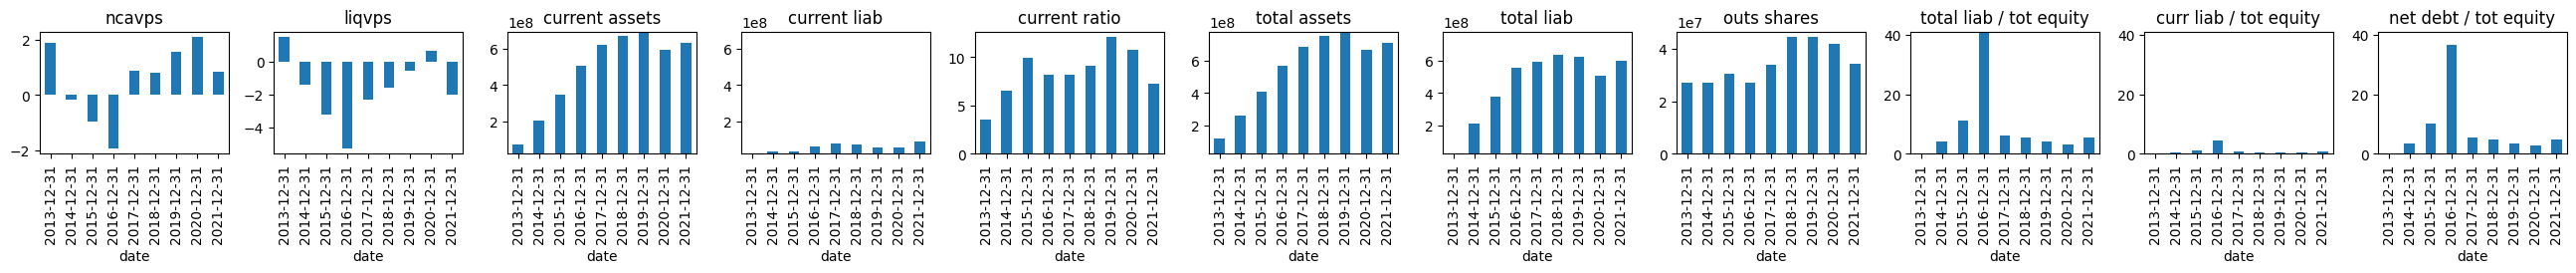

 25%|█████████████████████████████▎                                                                                       | 254/1013 [07:09<19:33,  1.55s/it]

DZSI.	 Current price: 1.99.	 NCAV: 5.539959419763181.	 LIQV: 3.075112807001605


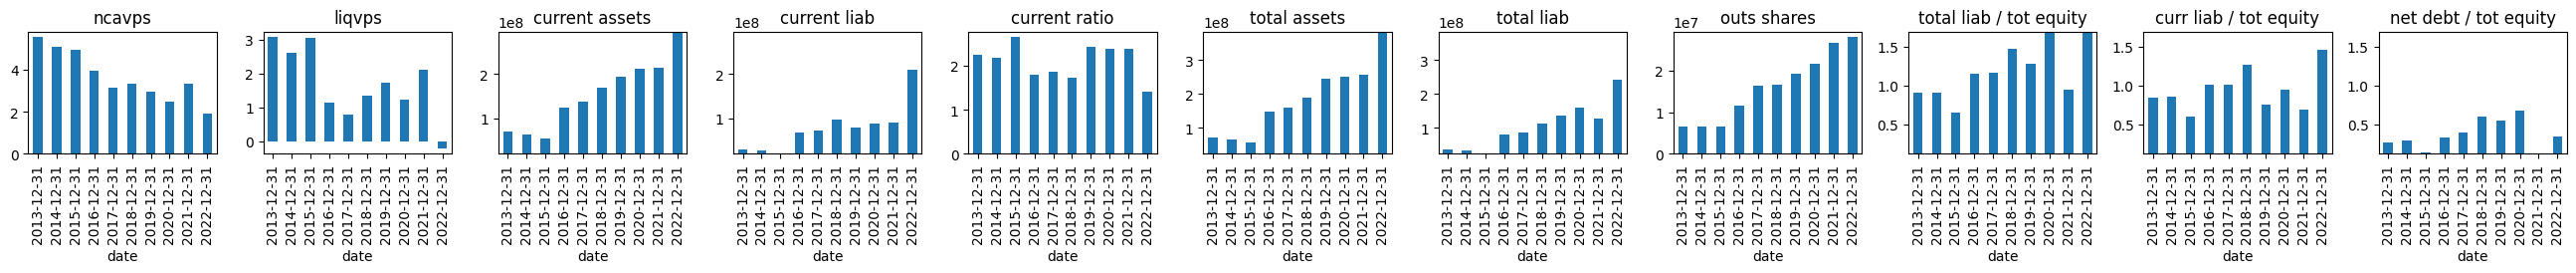

 25%|█████████████████████████████▍                                                                                       | 255/1013 [07:14<31:46,  2.52s/it]

GIGM.	 Current price: 1.35.	 NCAV: 6.7341363942365655.	 LIQV: 4.647553138937705


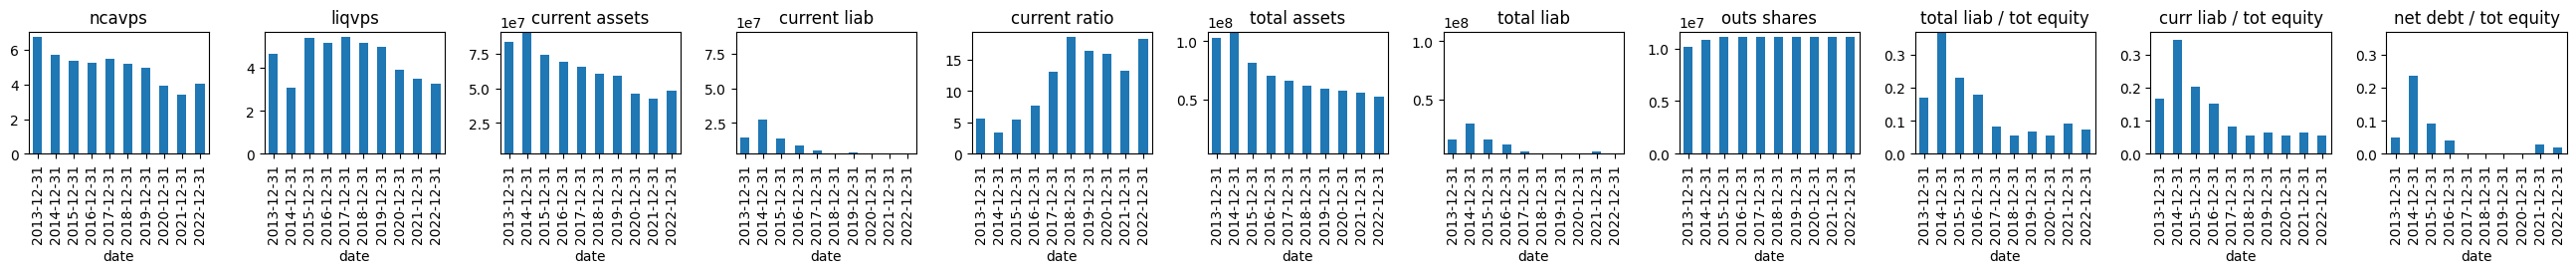

 27%|███████████████████████████████▉                                                                                     | 276/1013 [07:42<19:55,  1.62s/it]

dates of last income statement and balance sheet are not the same for ticker EXG
	income stmt date: 2010-10-31, balance sheet date: 2017-10-31
BBIG.	 Current price: 0.095.	 NCAV: 0.6757871510579273.	 LIQV: 2.2324406031696653


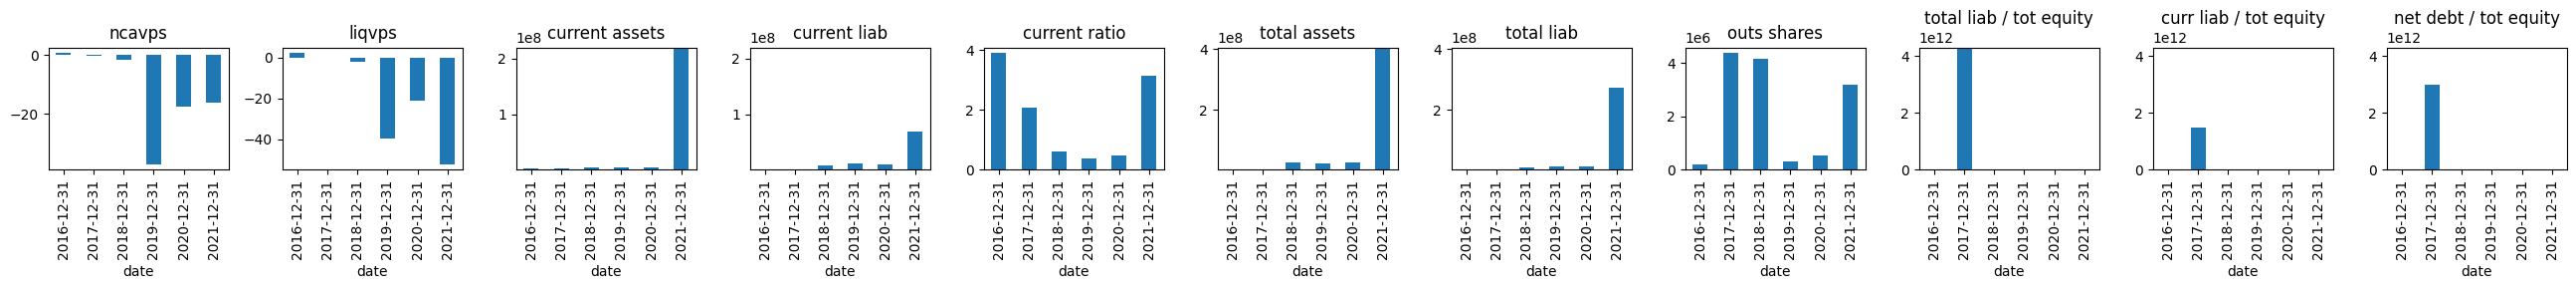

 28%|████████████████████████████████▏                                                                                    | 279/1013 [07:50<25:31,  2.09s/it]

ICD.	 Current price: 2.89.	 NCAV: -31.101075621972246.	 LIQV: 94.1603744149766


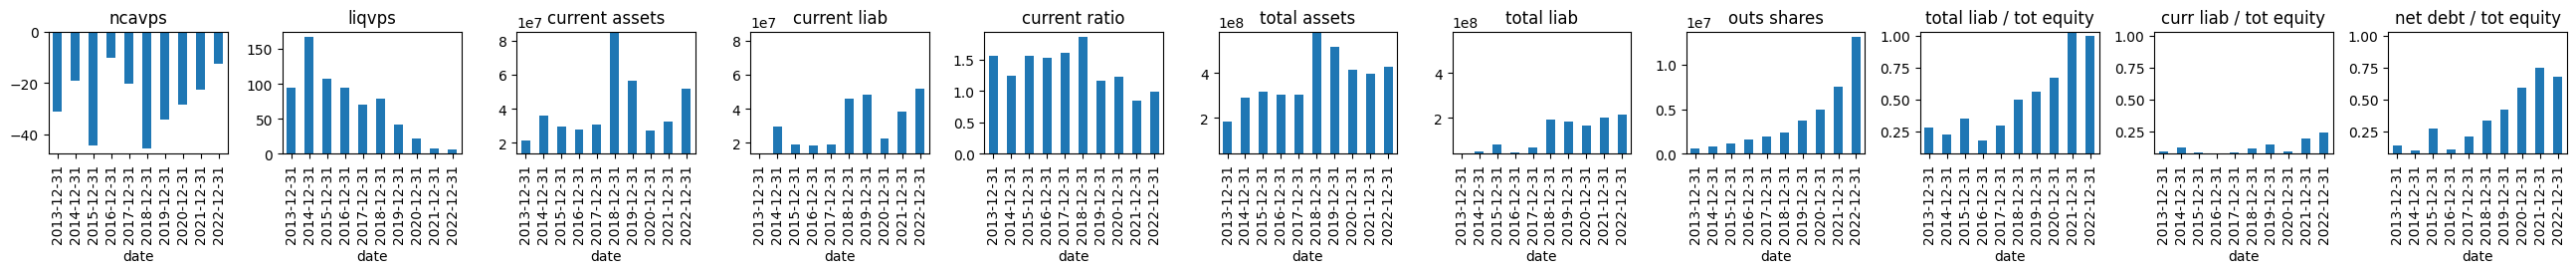

 28%|█████████████████████████████████▎                                                                                   | 288/1013 [08:03<11:28,  1.05it/s]

MICS.	 Current price: 1.	 NCAV: 1.0375930919811651.	 LIQV: -1.3353929230688022


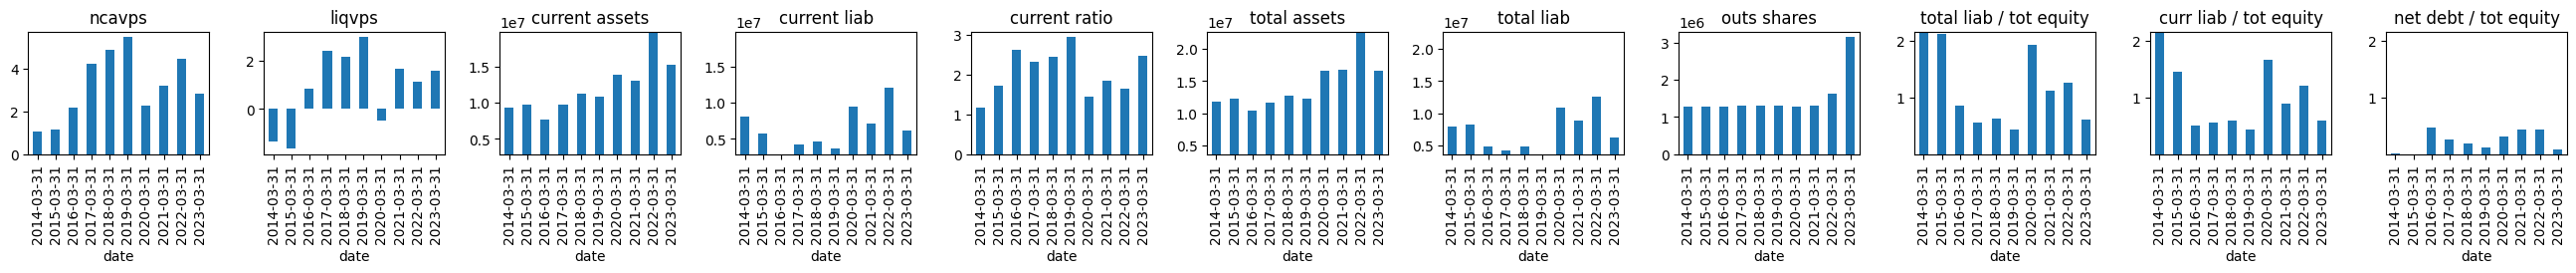

 29%|██████████████████████████████████▎                                                                                  | 297/1013 [08:17<11:13,  1.06it/s]

GIFI.	 Current price: 3.25.	 NCAV: 3.547169811320755.	 LIQV: 9.836052940769921


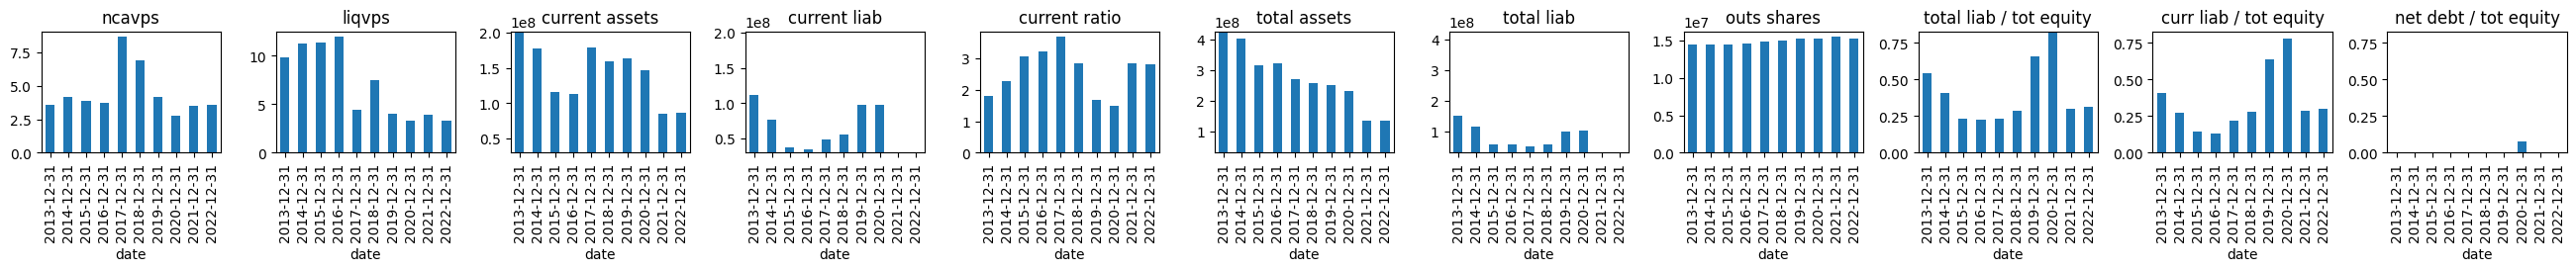

 30%|██████████████████████████████████▉                                                                                  | 302/1013 [08:25<13:58,  1.18s/it]

WILC.	 Current price: 10.15.	 NCAV: 25.032901721834296.	 LIQV: 10.431896422489324


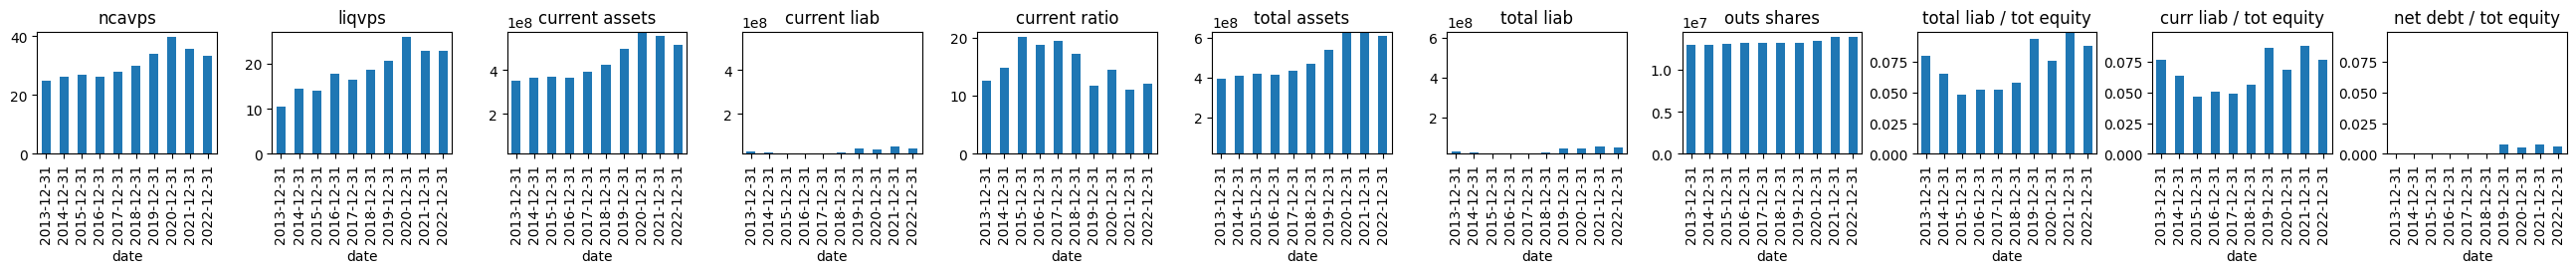

 30%|███████████████████████████████████                                                                                  | 304/1013 [08:32<25:07,  2.13s/it]

SNT.	 Current price: 1.11.	 NCAV: 2.378303273864423.	 LIQV: 1.5116417792905499


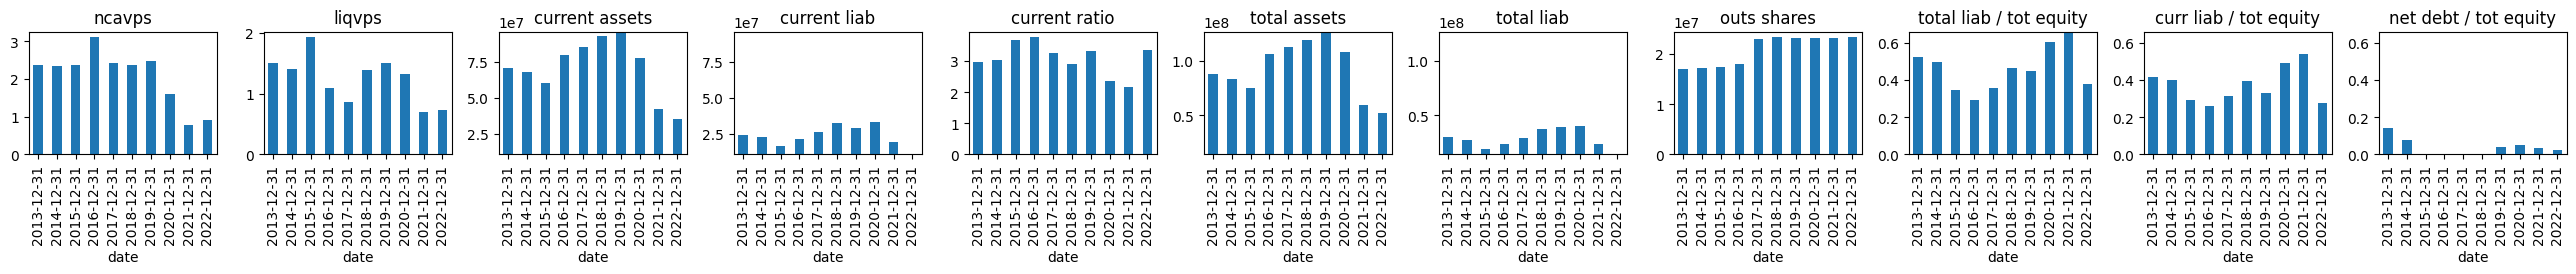

 31%|███████████████████████████████████▉                                                                                 | 311/1013 [08:42<16:02,  1.37s/it]

dates of last income statement and balance sheet are not the same for ticker USA
	income stmt date: 2010-12-31, balance sheet date: 2017-12-31


 33%|██████████████████████████████████████▎                                                                              | 332/1013 [09:11<12:04,  1.06s/it]

ARR.	 Current price: 20.45.	 NCAV: 29.884927459540503.	 LIQV: -293.27353265423113


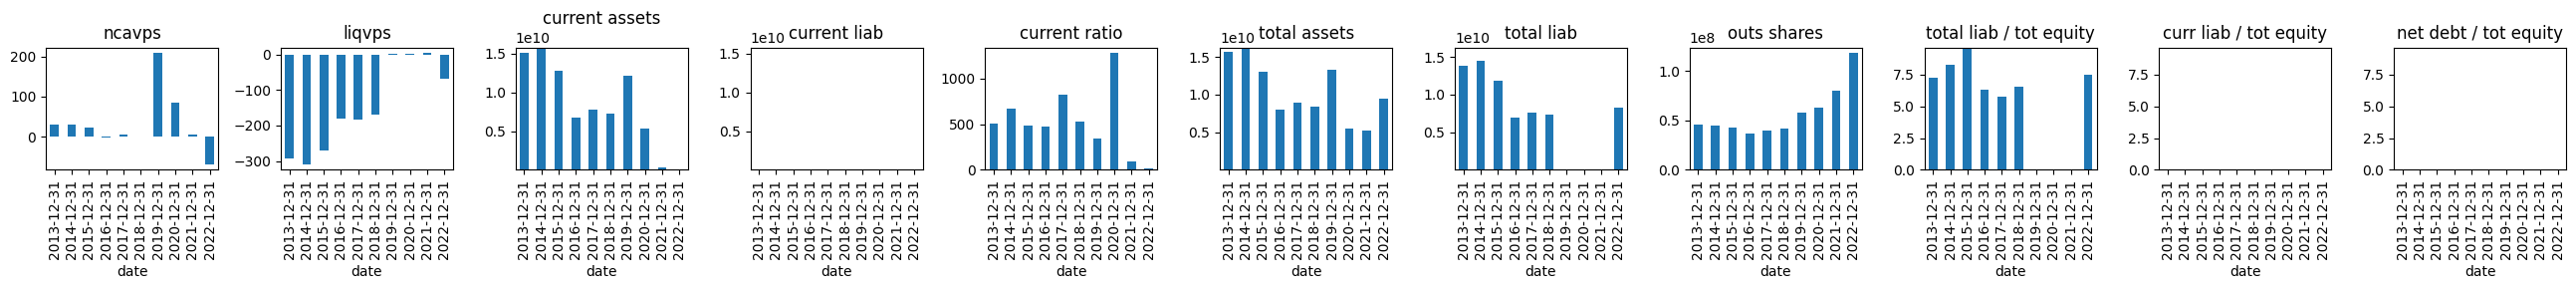

 34%|███████████████████████████████████████▊                                                                             | 345/1013 [09:32<16:09,  1.45s/it]

FAMI.	 Current price: 1.61.	 NCAV: 2.6040025684931507.	 LIQV: -1.785535488013698


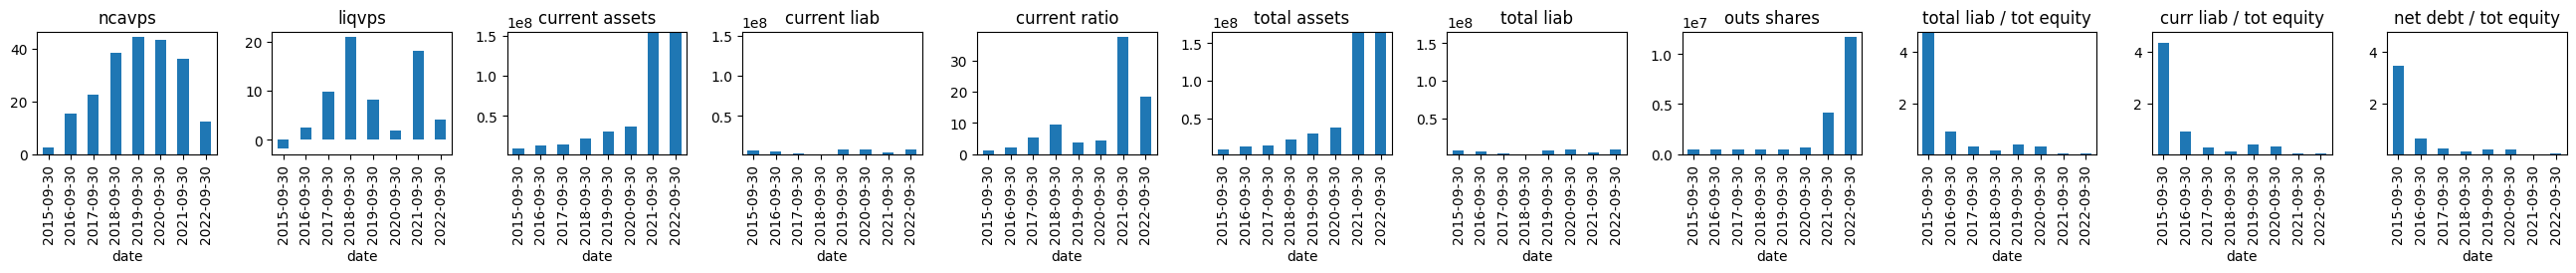

 36%|██████████████████████████████████████████▌                                                                          | 369/1013 [10:00<12:58,  1.21s/it]

dates incoherence


 37%|███████████████████████████████████████████▎                                                                         | 375/1013 [10:07<13:59,  1.32s/it]

dates incoherence


 38%|████████████████████████████████████████████▌                                                                        | 386/1013 [10:19<09:44,  1.07it/s]

RCON.	 Current price: 0.305.	 NCAV: 103.70619285846233.	 LIQV: 46.20765272115814


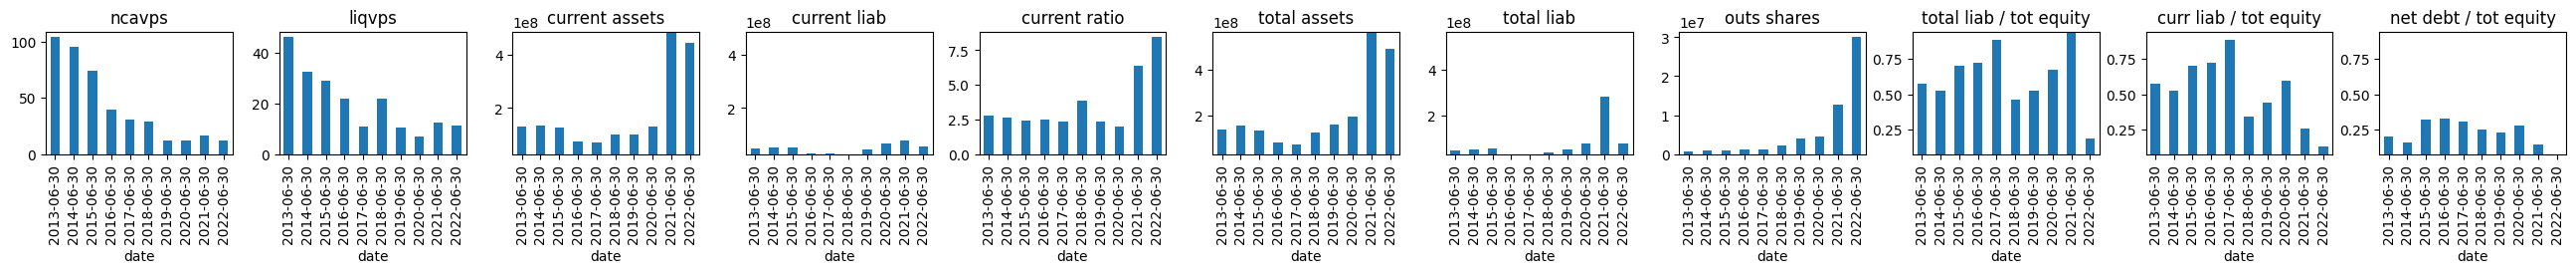

 41%|███████████████████████████████████████████████▍                                                                     | 411/1013 [10:53<12:15,  1.22s/it]

GORO.	 Current price: 0.4031.	 NCAV: 0.5127896783830226.	 LIQV: 0.39955135197938135


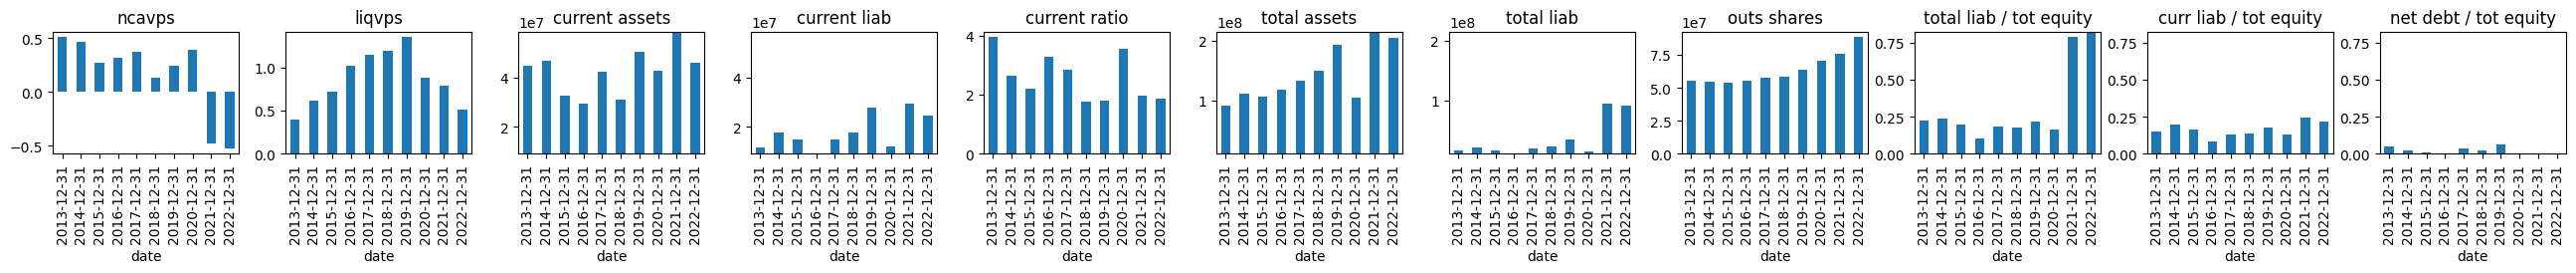

 41%|████████████████████████████████████████████████▍                                                                    | 419/1013 [11:06<16:40,  1.68s/it]

NVFY.	 Current price: 2.47.	 NCAV: 21.27540119885736.	 LIQV: 19.13734154361056


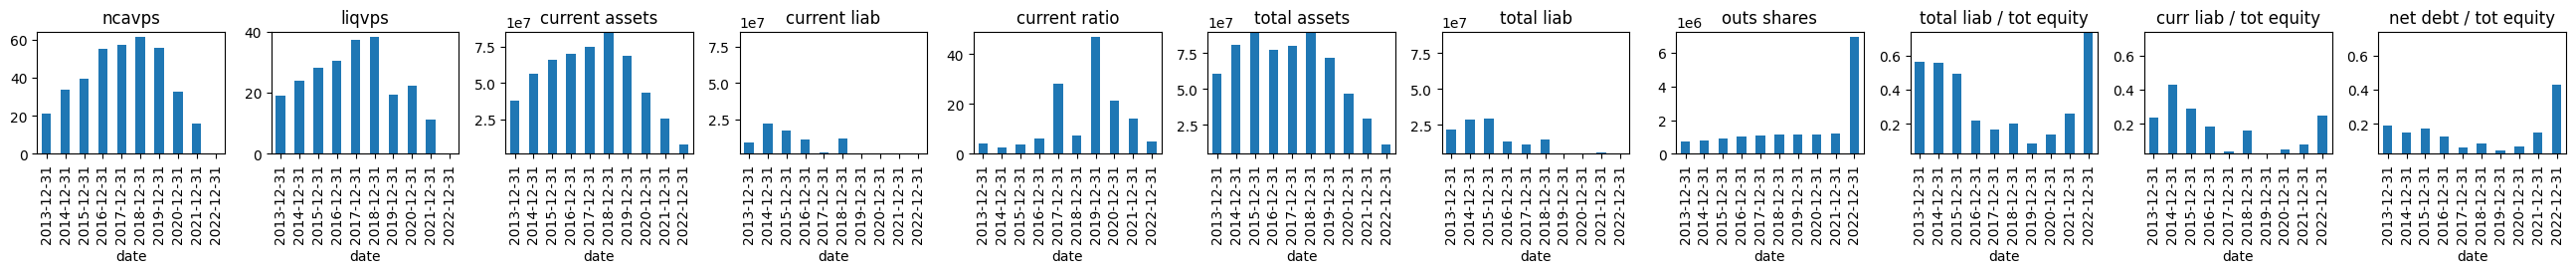

 42%|█████████████████████████████████████████████████▎                                                                   | 427/1013 [11:18<15:20,  1.57s/it]

NTWK.	 Current price: 1.9.	 NCAV: 1.182451401772745.	 LIQV: 2.731670896341252


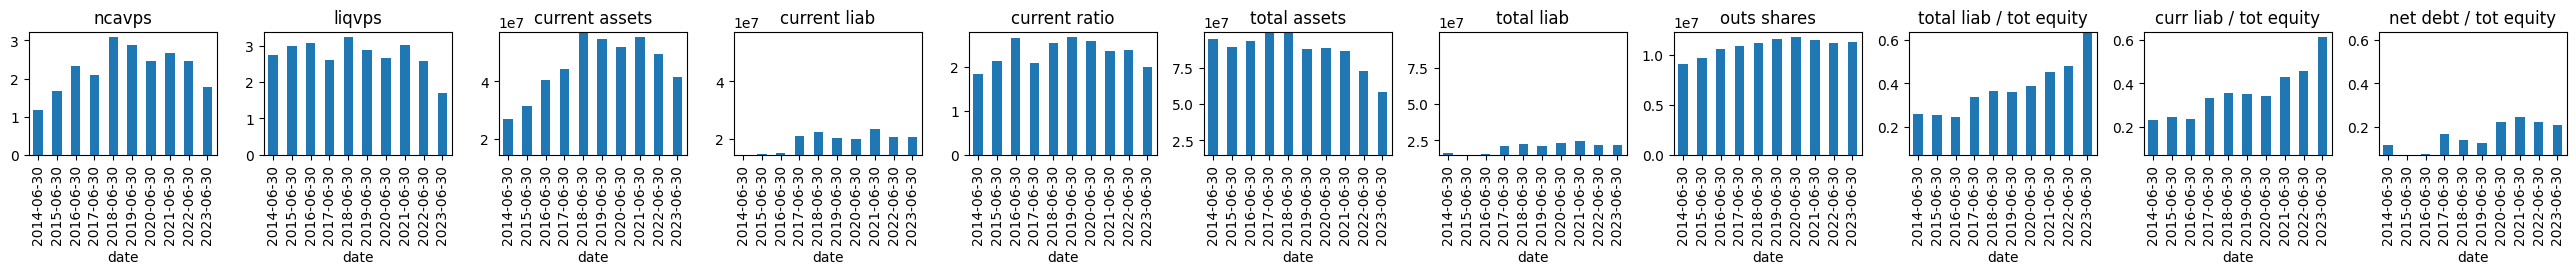

 43%|██████████████████████████████████████████████████▋                                                                  | 439/1013 [11:35<08:07,  1.18it/s]

GAIA.	 Current price: 2.66.	 NCAV: 3.065122758140345.	 LIQV: 2.125918509489814


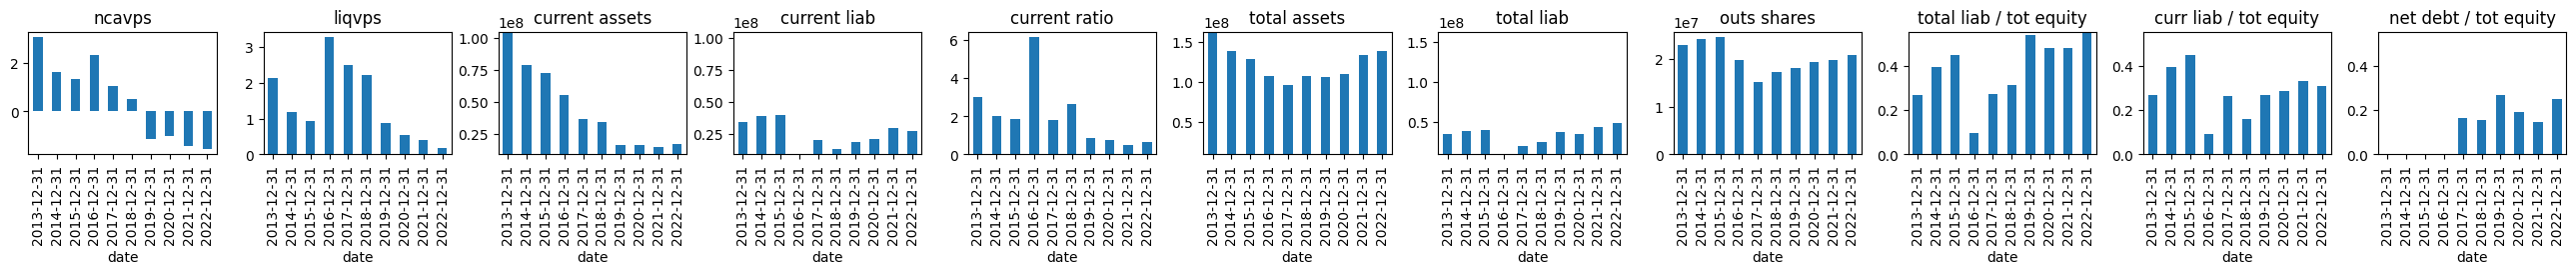

 44%|███████████████████████████████████████████████████                                                                  | 442/1013 [11:41<12:24,  1.30s/it]

STRR.	 Current price: 0.9856.	 NCAV: 14.929798006158986.	 LIQV: 10.508956626128713


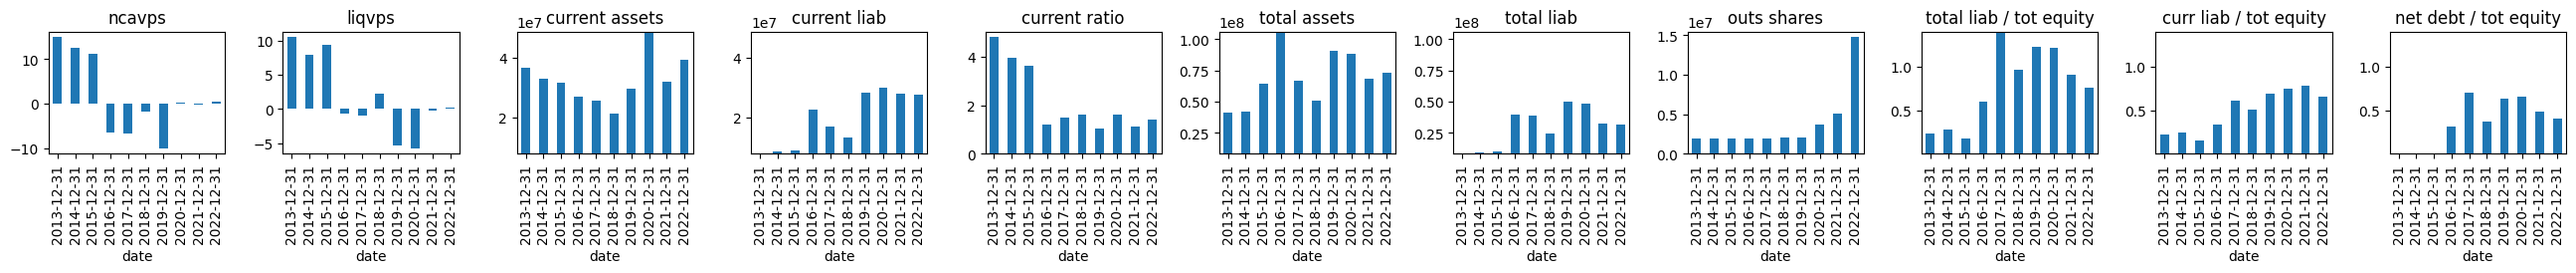

 44%|███████████████████████████████████████████████████▍                                                                 | 445/1013 [11:49<17:17,  1.83s/it]

EUSP.	 Current price: 0.041.	 NCAV: 0.04286932391146618.	 LIQV: 0.04188247488556804


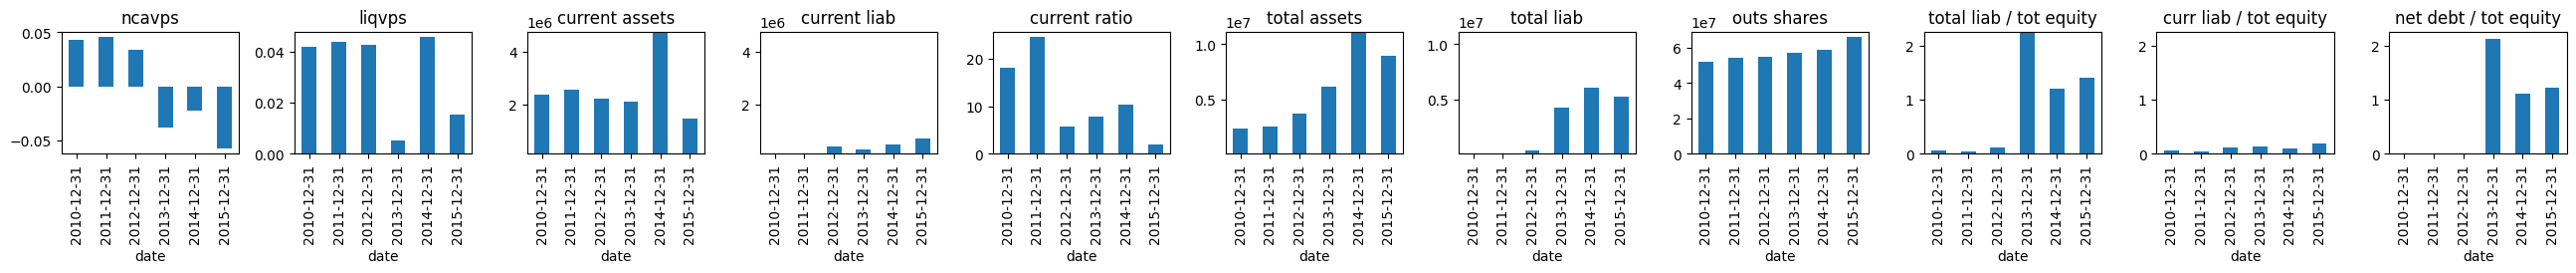

 44%|███████████████████████████████████████████████████▌                                                                 | 446/1013 [11:53<24:01,  2.54s/it]

MSN.	 Current price: 0.5526.	 NCAV: 2.7008109104312568.	 LIQV: 1.1909377073350536


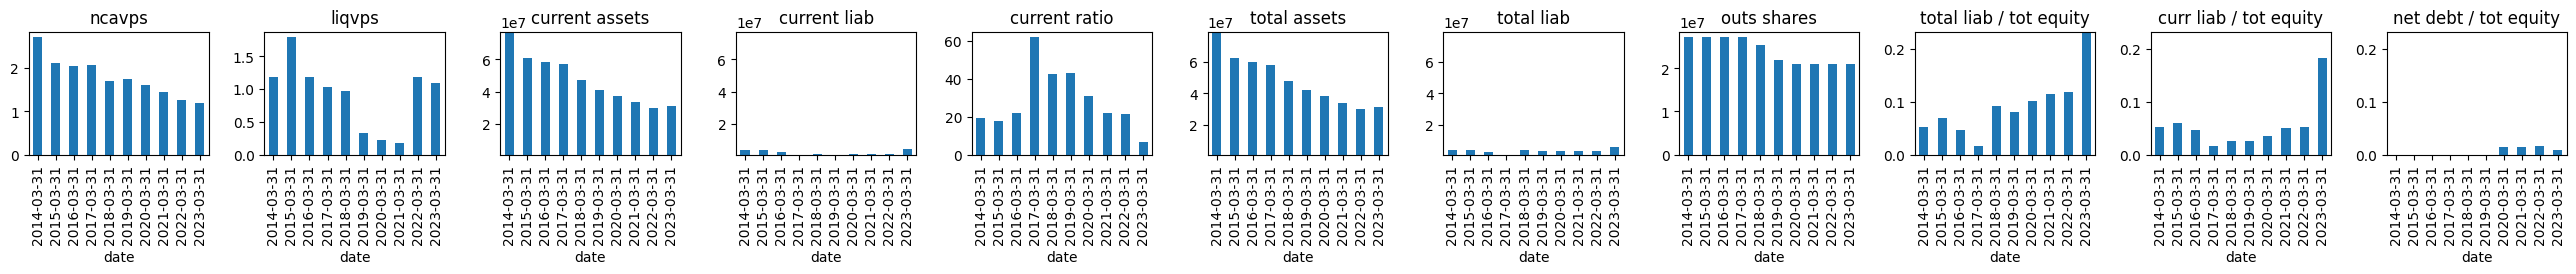

 45%|████████████████████████████████████████████████████▏                                                                | 452/1013 [12:04<14:03,  1.50s/it]

BKYI.	 Current price: 0.5001.	 NCAV: 1.5524828480589024.	 LIQV: 1.4463590612449797


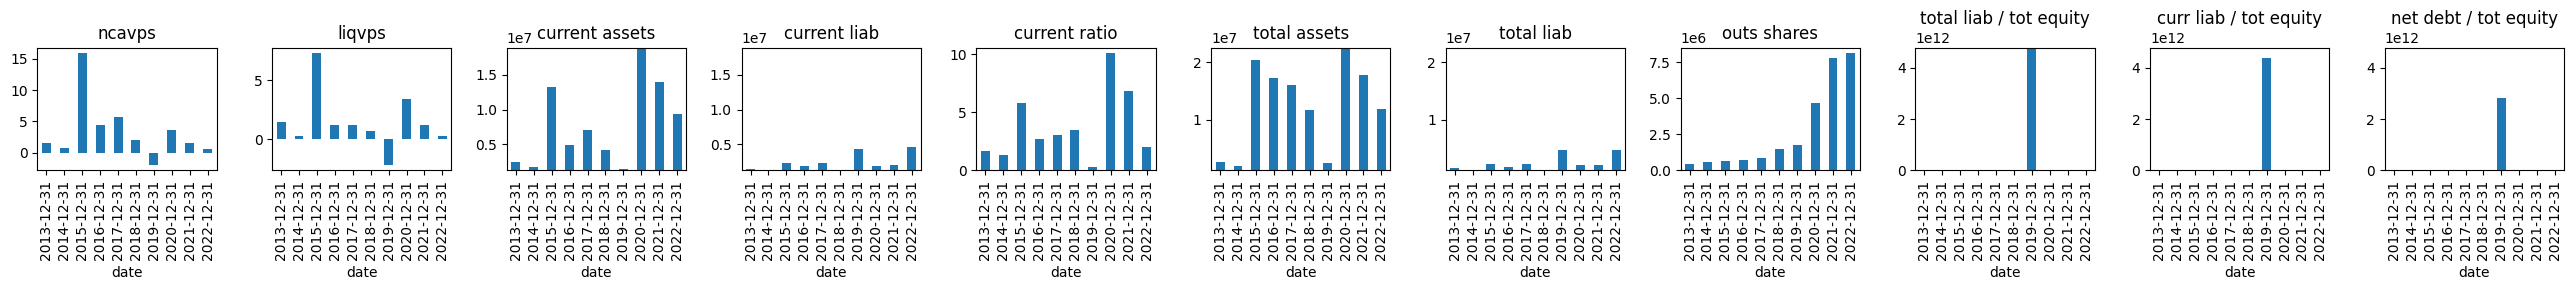

 45%|█████████████████████████████████████████████████████▏                                                               | 460/1013 [12:18<15:11,  1.65s/it]

PTE.	 Current price: 0.241.	 NCAV: 395.43160020191823.	 LIQV: 47.80893488137304


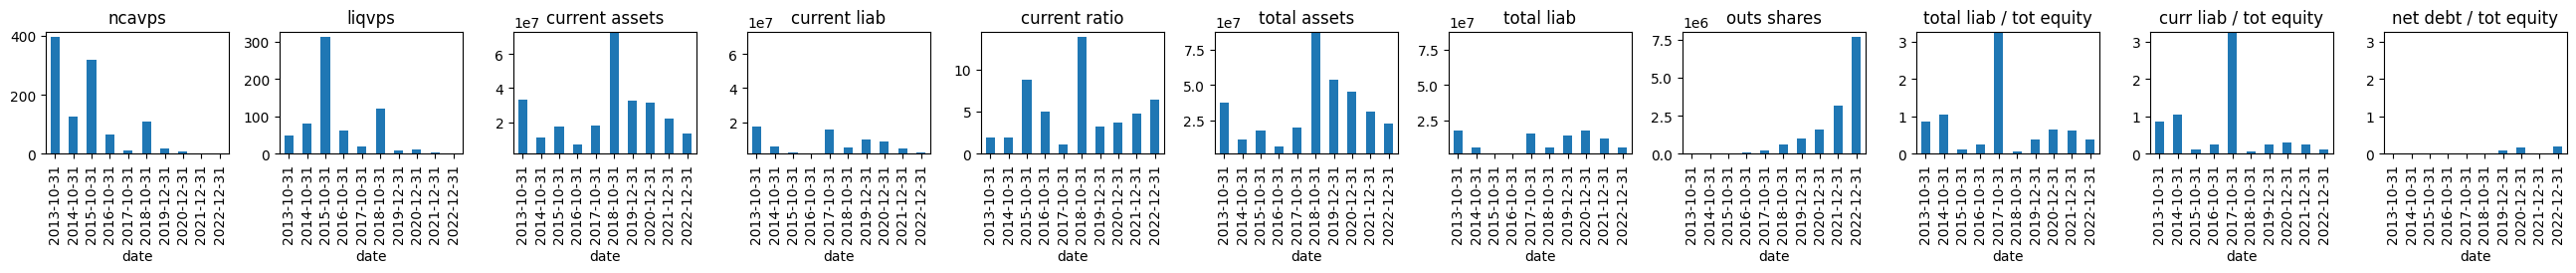

 46%|█████████████████████████████████████████████████████▏                                                               | 461/1013 [12:22<22:58,  2.50s/it]

GNLN.	 Current price: 0.6059.	 NCAV: 65.19883530939713.	 LIQV: -129.70420671163433


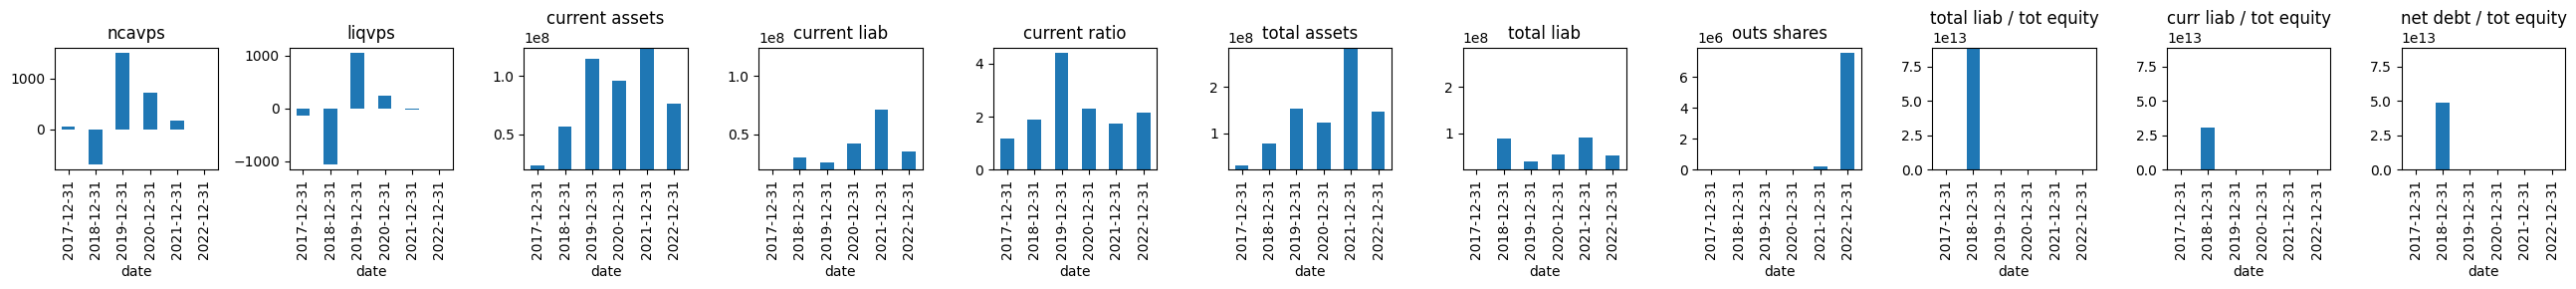

 46%|█████████████████████████████████████████████████████▊                                                               | 466/1013 [12:35<21:37,  2.37s/it]

LAB.	 Current price: 2.73.	 NCAV: 3.3277208681659407.	 LIQV: 1.3094101024373013


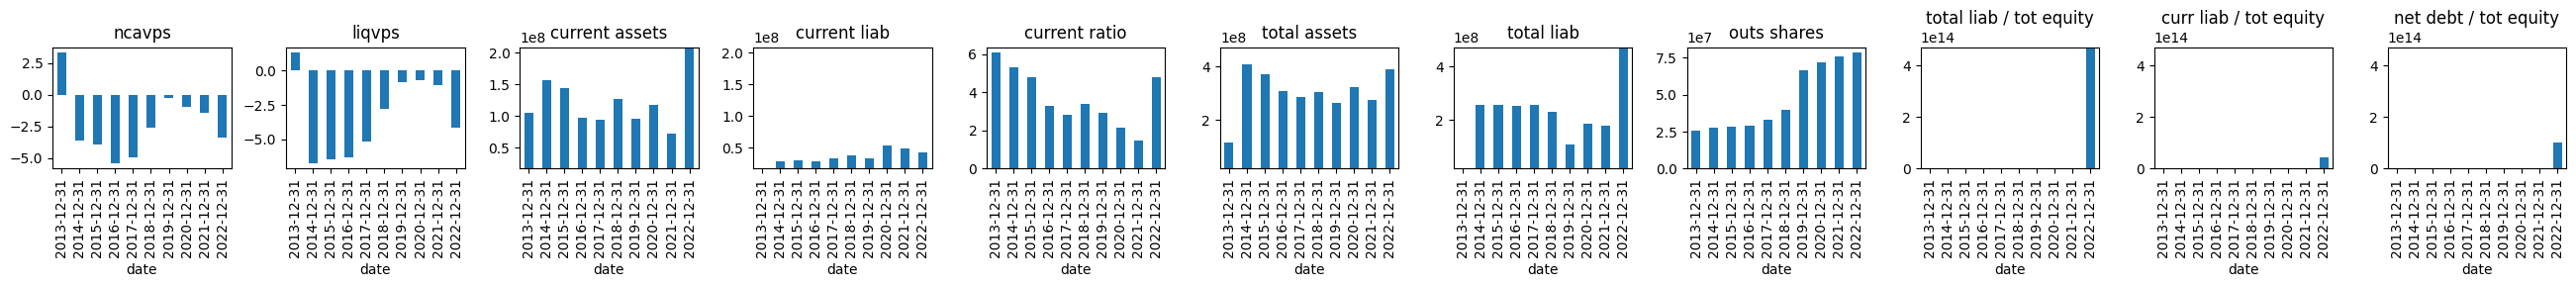

 49%|████████████████████████████████████████████████████████▊                                                            | 492/1013 [13:12<08:28,  1.03it/s]

SUP.	 Current price: 3.04.	 NCAV: 7.7691693000617486.	 LIQV: 10.692856779630235


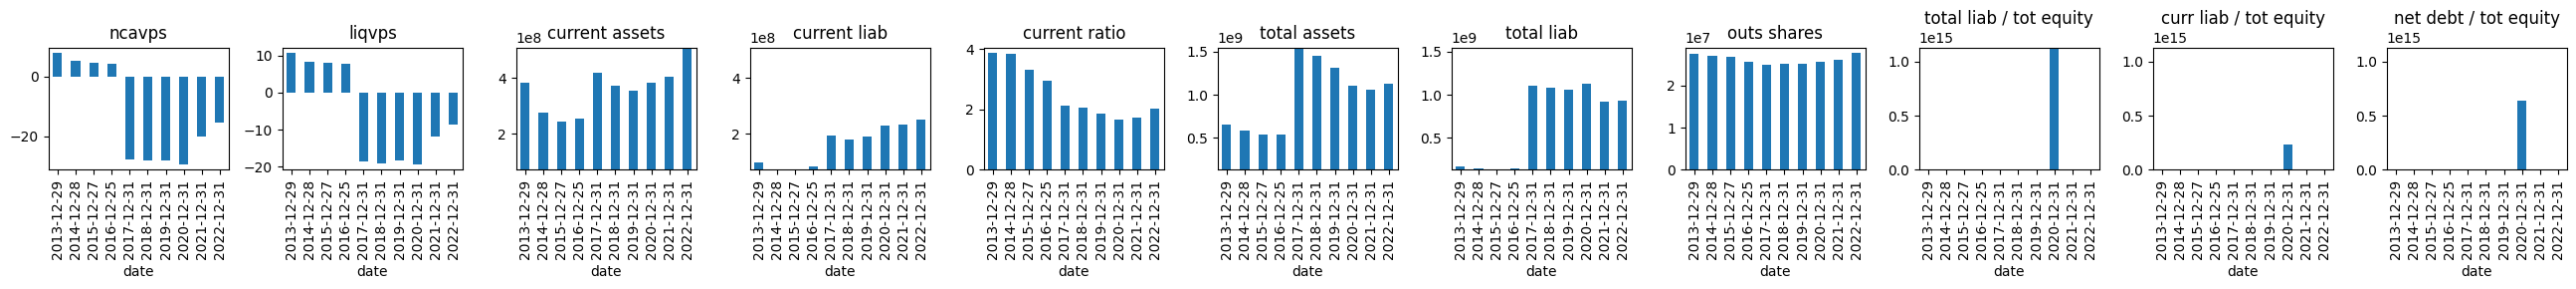

 49%|█████████████████████████████████████████████████████████                                                            | 494/1013 [13:18<14:38,  1.69s/it]

HIHO.	 Current price: 1.97.	 NCAV: 2.7265979764578194.	 LIQV: 1.9385266974326163


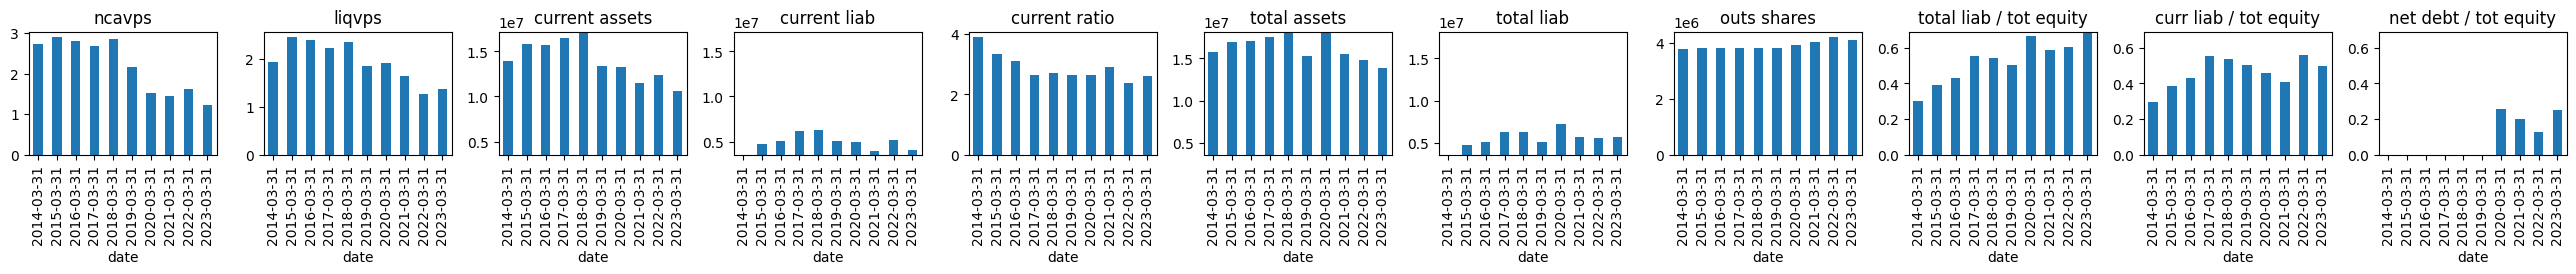

 49%|█████████████████████████████████████████████████████████▎                                                           | 496/1013 [13:25<21:13,  2.46s/it]

BIMI.	 Current price: 1.56.	 NCAV: 15.332308029317002.	 LIQV: 132.78450406622795


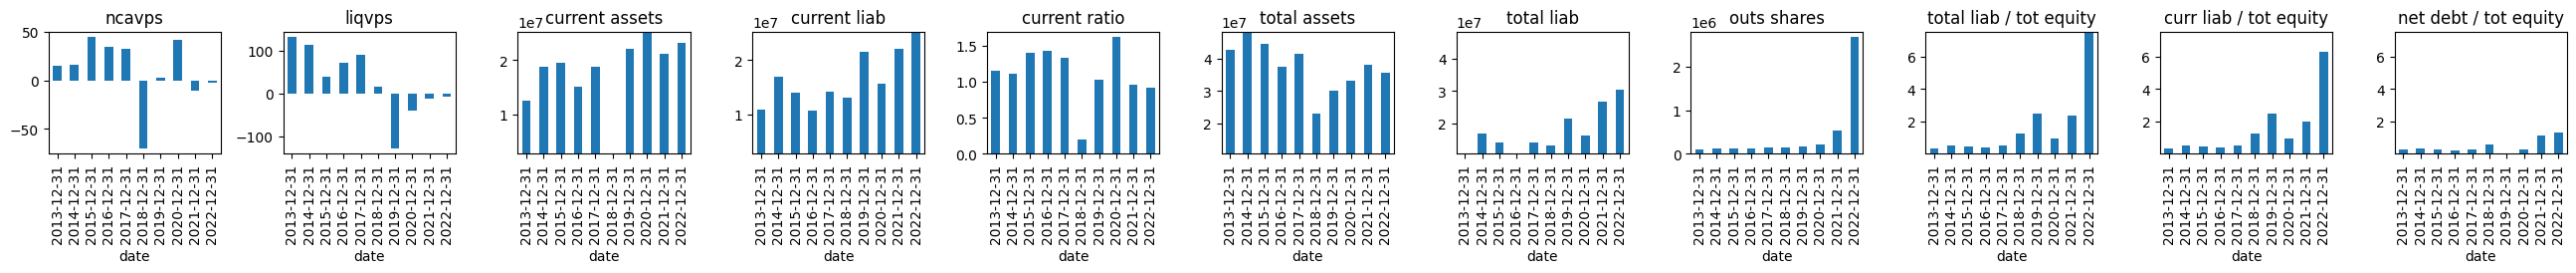

 49%|█████████████████████████████████████████████████████████▋                                                           | 499/1013 [13:31<16:01,  1.87s/it]

NSAV.	 Current price: 0.00125.	 NCAV: 0.00350531195962435.	 LIQV: 0.00350531195962435


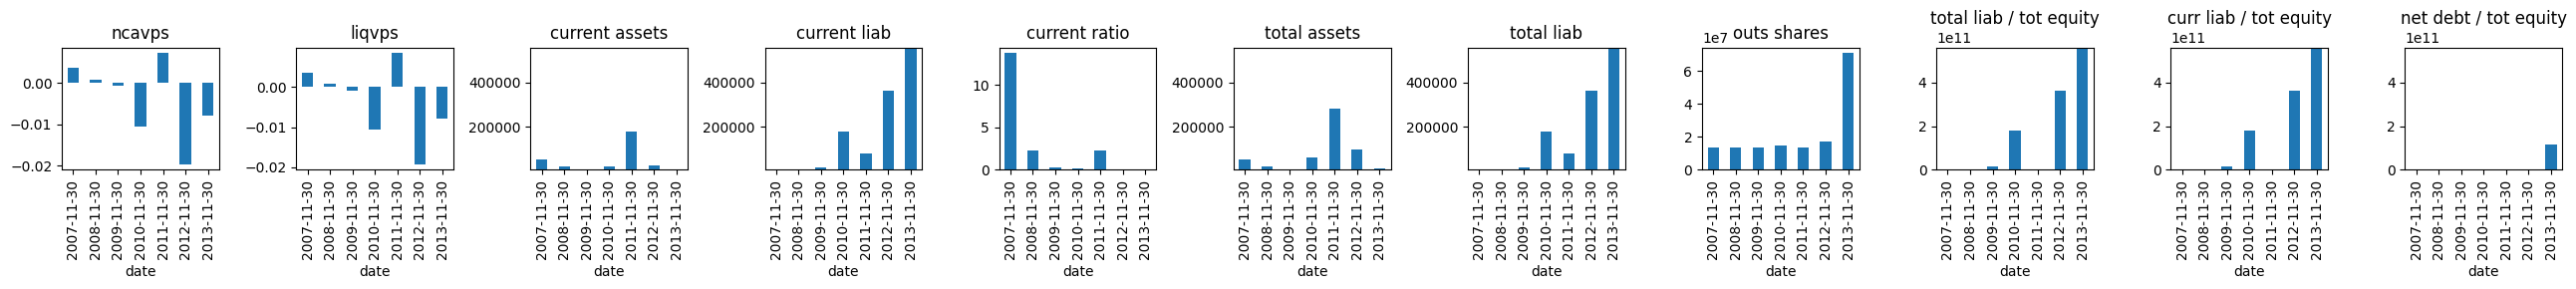

 52%|████████████████████████████████████████████████████████████▎                                                        | 522/1013 [14:07<13:40,  1.67s/it]

ADD.	 Current price: 1.04.	 NCAV: 925.4512943329207.	 LIQV: -400.88659840697477


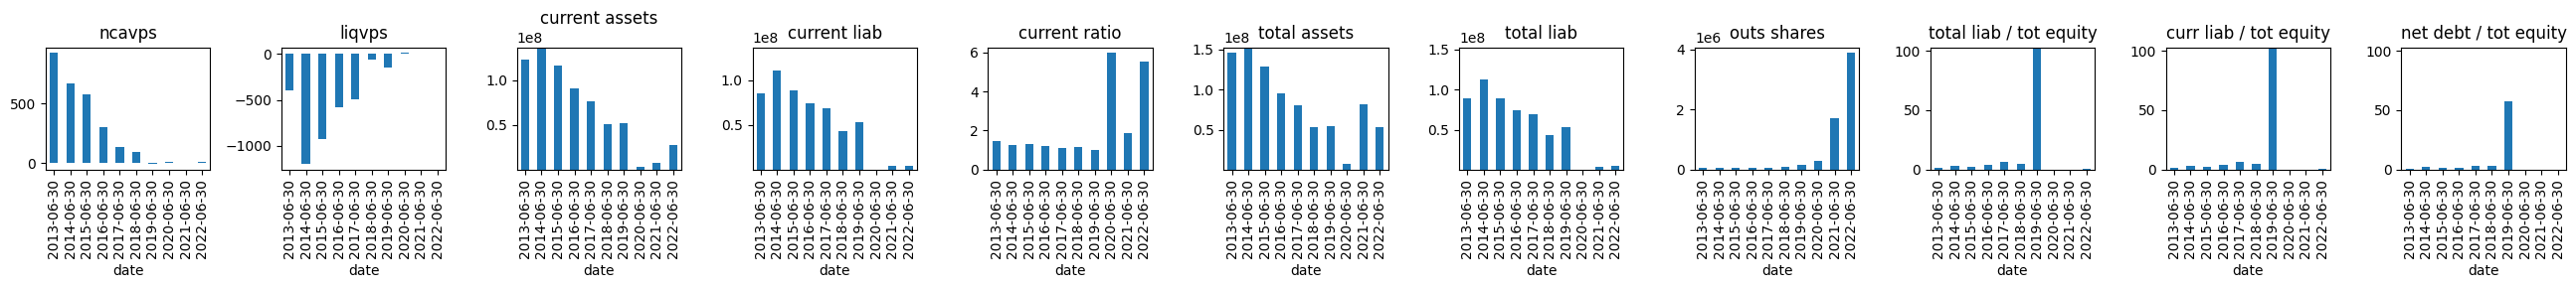

 52%|████████████████████████████████████████████████████████████▊                                                        | 527/1013 [14:17<11:33,  1.43s/it]

BSQR.	 Current price: 1.18.	 NCAV: 1.7044925720422408.	 LIQV: 0.5837453015929838


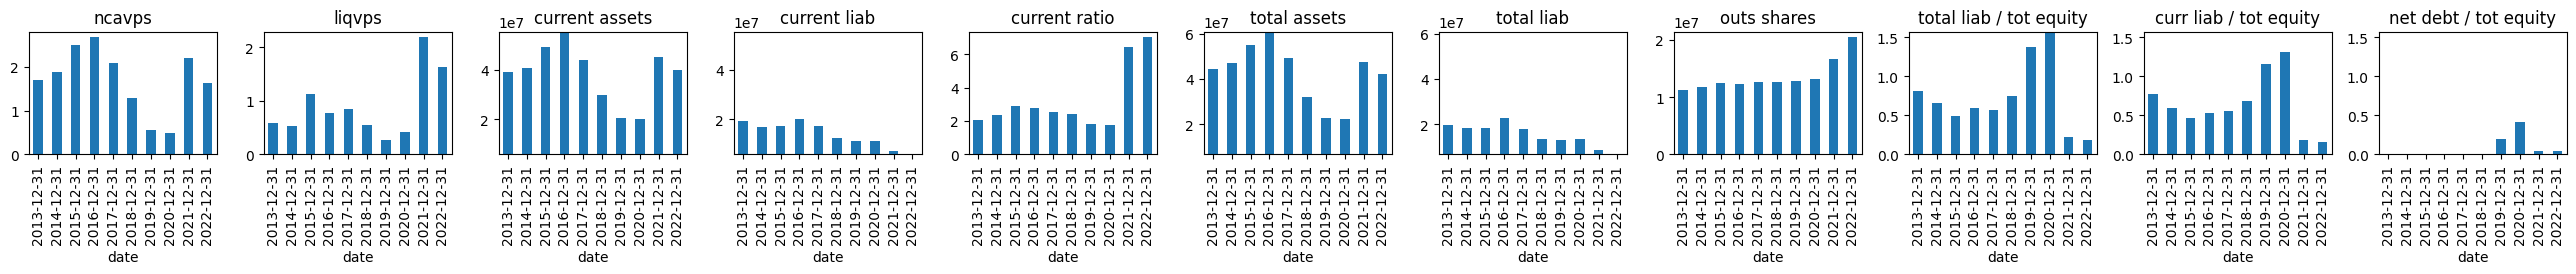

 54%|██████████████████████████████████████████████████████████████▋                                                      | 543/1013 [14:37<06:56,  1.13it/s]

HERB.	 Current price: 0.085.	 NCAV: -0.6020005692553557.	 LIQV: 0.8363385961675494


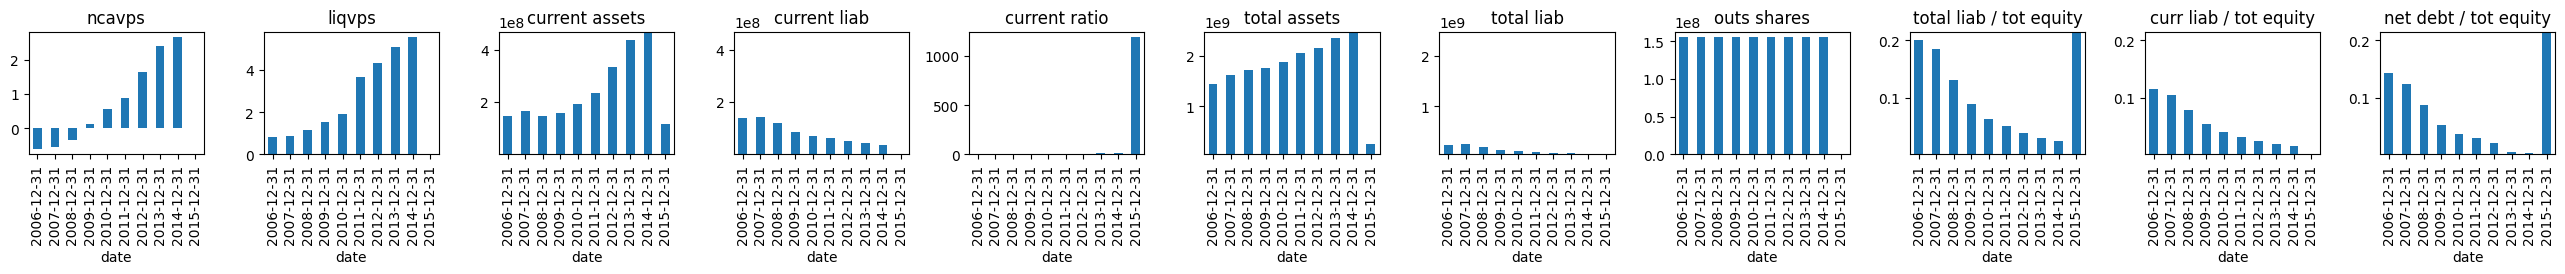

 54%|██████████████████████████████████████████████████████████████▊                                                      | 544/1013 [14:42<16:05,  2.06s/it]

PRSO.	 Current price: 0.1818.	 NCAV: 0.7913185695973125.	 LIQV: 0.05269902311806569


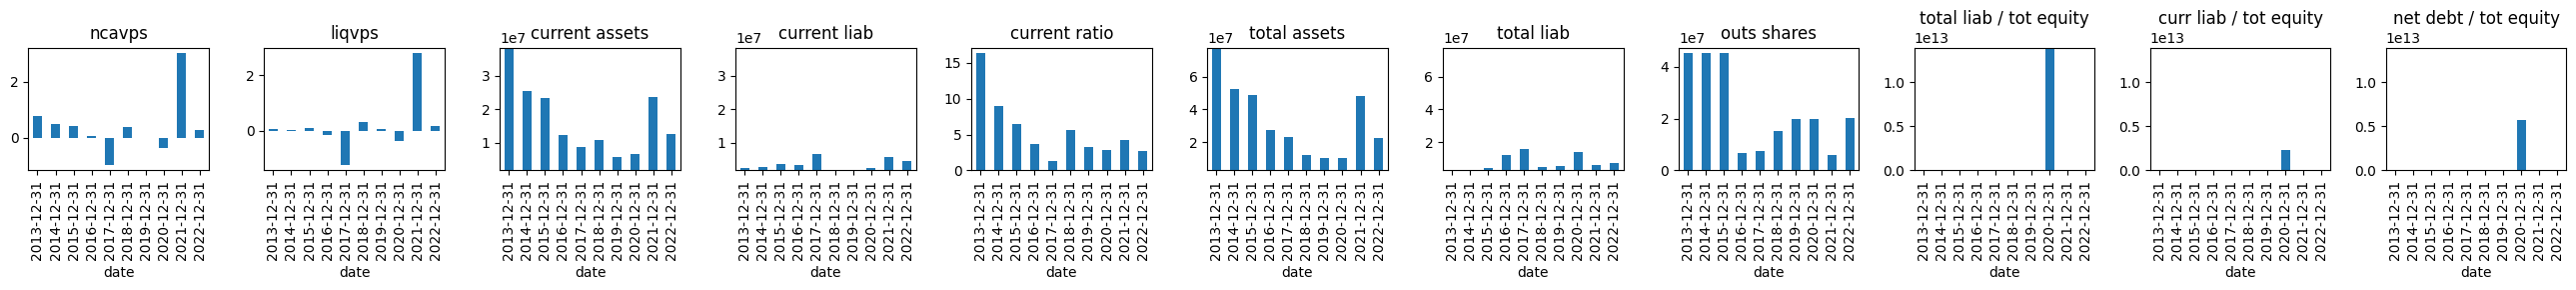

 56%|█████████████████████████████████████████████████████████████████                                                    | 563/1013 [15:11<13:34,  1.81s/it]

BHAT.	 Current price: 1.33.	 NCAV: 4.992064857142857.	 LIQV: -1.025613434285714


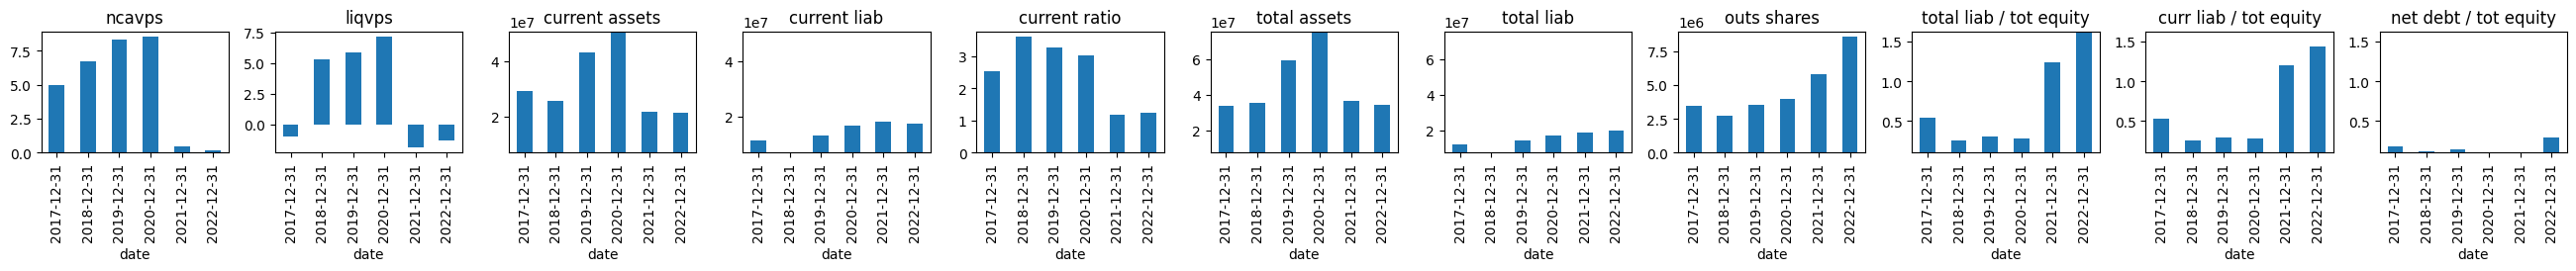

 57%|██████████████████████████████████████████████████████████████████▍                                                  | 575/1013 [15:33<11:15,  1.54s/it]

PCTI.	 Current price: 4.37.	 NCAV: 4.424109106907171.	 LIQV: 2.2021540915090188


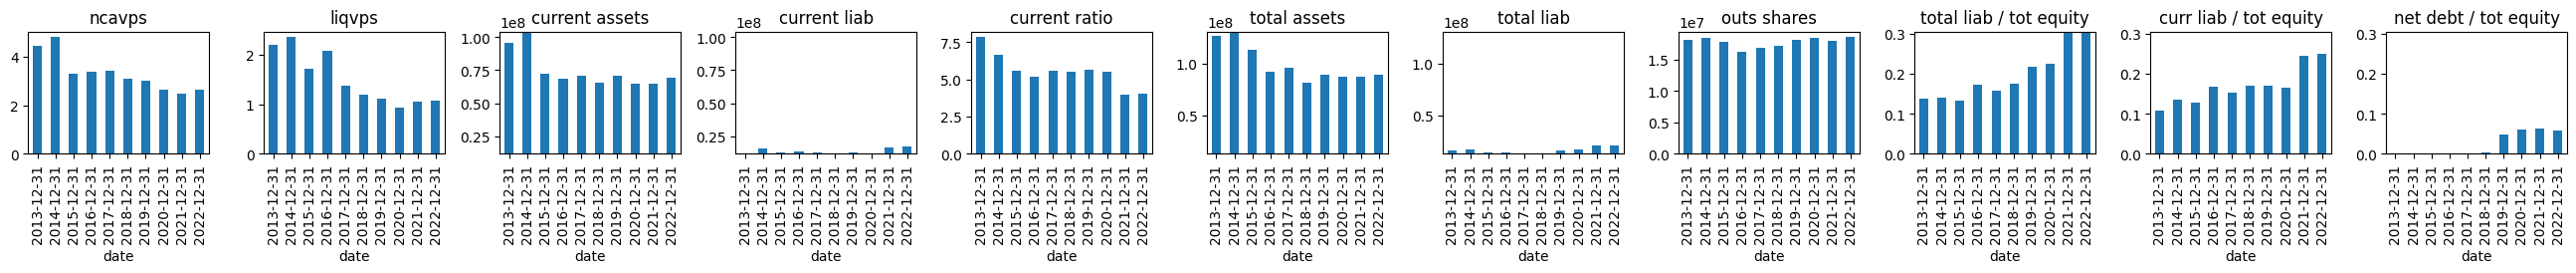

 59%|████████████████████████████████████████████████████████████████████▍                                                | 593/1013 [15:56<05:47,  1.21it/s]

TMQ.	 Current price: 0.4818.	 NCAV: 0.10359680741498686.	 LIQV: 0.49813158009507025


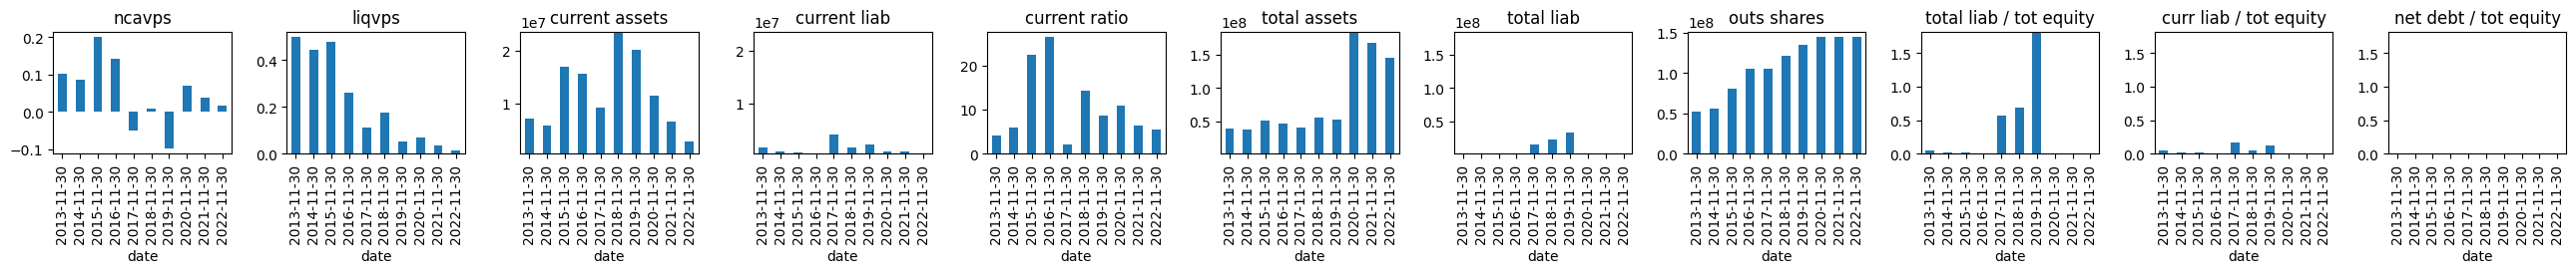

 59%|█████████████████████████████████████████████████████████████████████▍                                               | 601/1013 [16:07<08:40,  1.26s/it]

ASTC.	 Current price: 10.3099.	 NCAV: -12.463815355482604.	 LIQV: 167.9514640714613


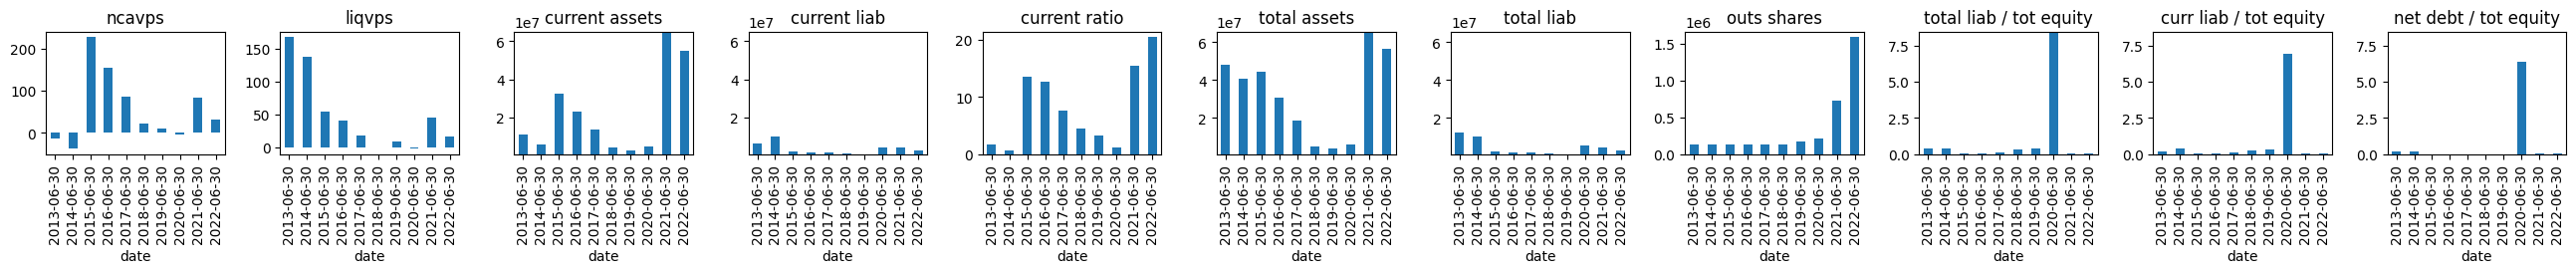

 61%|███████████████████████████████████████████████████████████████████████▏                                             | 616/1013 [16:33<10:44,  1.62s/it]

PSHG.	 Current price: 1.88.	 NCAV: -32316000.0.	 LIQV: 11765227.5


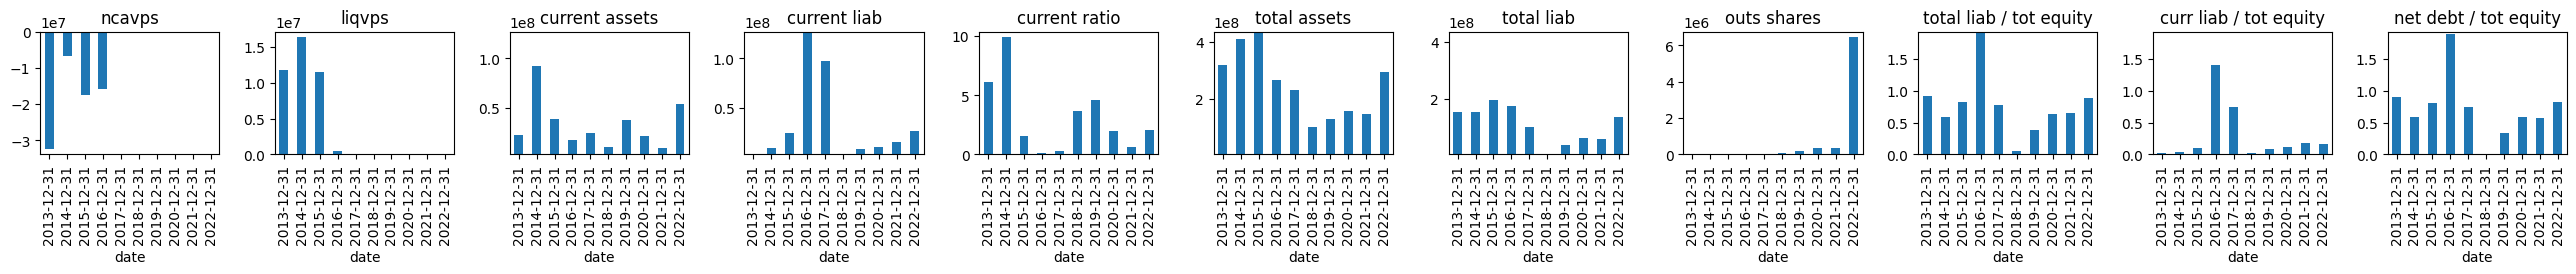

 61%|███████████████████████████████████████████████████████████████████████▎                                             | 617/1013 [16:37<16:18,  2.47s/it]

CLEU.	 Current price: 0.26.	 NCAV: 0.6091670846930045.	 LIQV: 0.27754473829182835


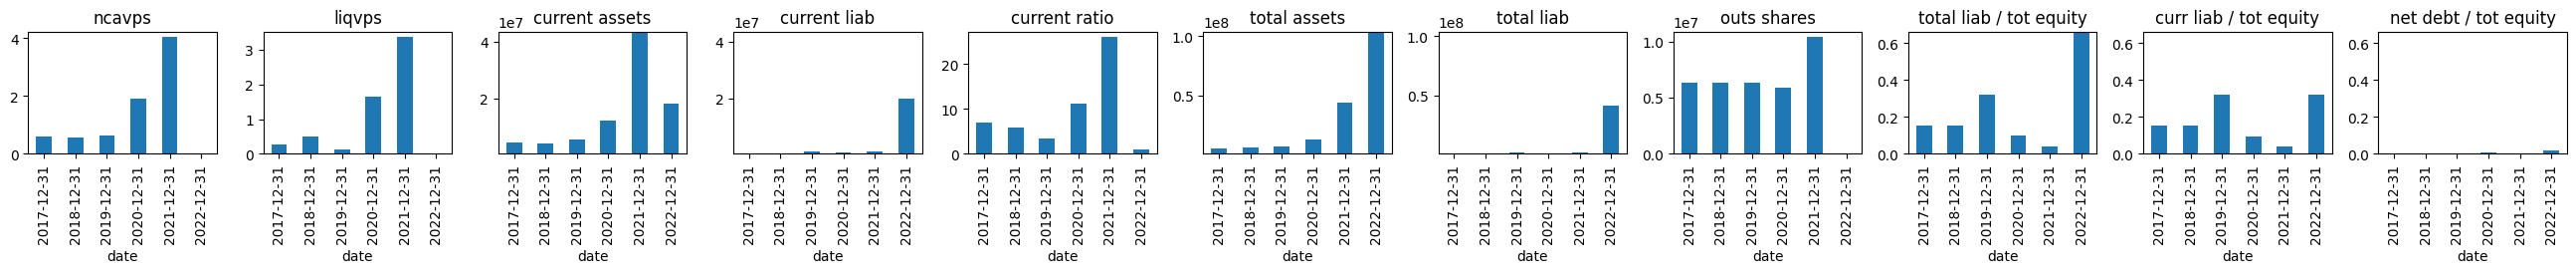

 61%|███████████████████████████████████████████████████████████████████████▍                                             | 618/1013 [16:41<19:56,  3.03s/it]

FGH.	 Current price: 1.67.	 NCAV: 3.072838714275533.	 LIQV: 2.6071035564108045


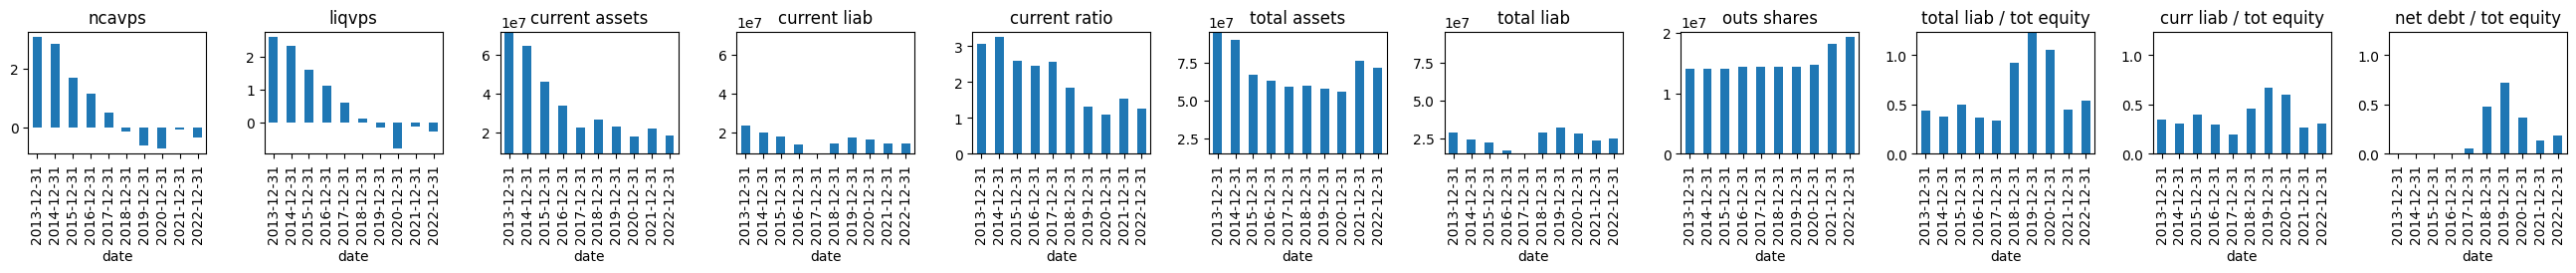

 61%|███████████████████████████████████████████████████████████████████████▊                                             | 622/1013 [16:51<14:51,  2.28s/it]

VISL.	 Current price: 3.65.	 NCAV: 284500.0.	 LIQV: 192585.0


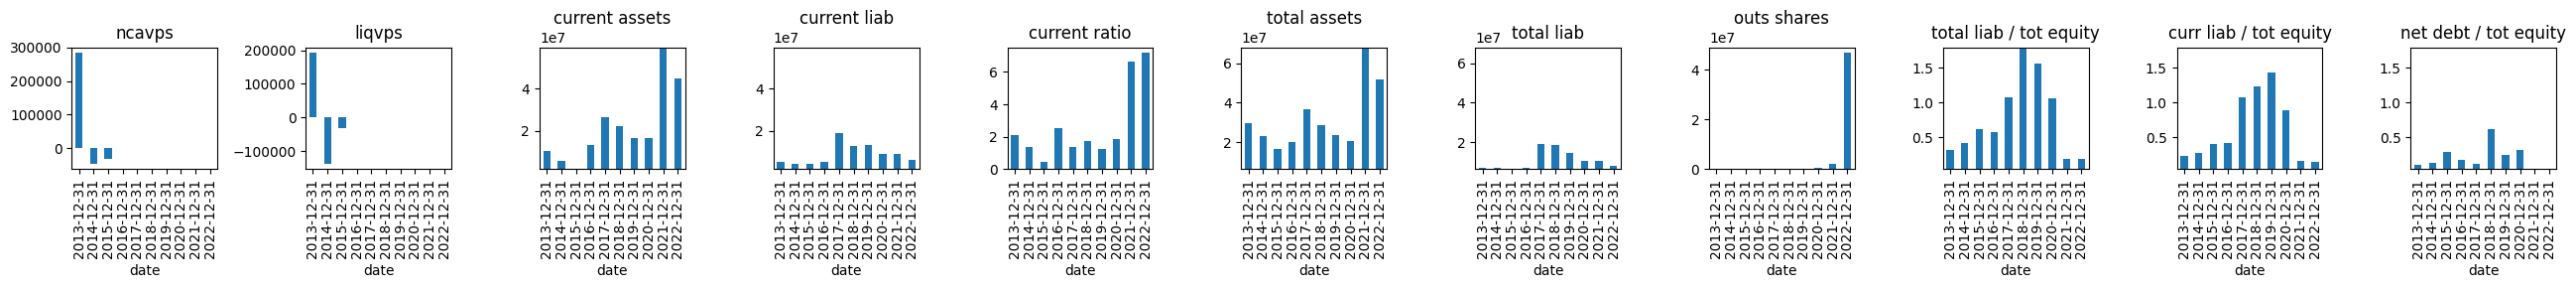

 62%|████████████████████████████████████████████████████████████████████████▉                                            | 631/1013 [17:08<09:48,  1.54s/it]

dates of last income statement and balance sheet are not the same for ticker NINE
	income stmt date: 2014-12-31, balance sheet date: 2015-12-31
MMAT.	 Current price: 0.2243.	 NCAV: -0.3778150202907484.	 LIQV: 0.23923021081260015


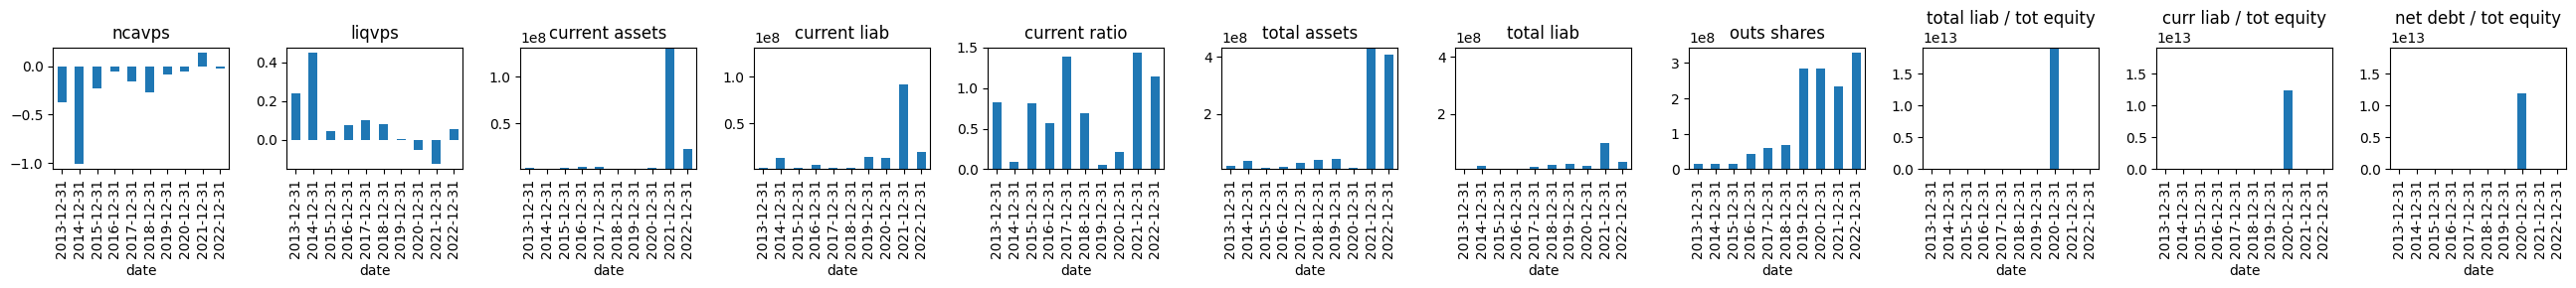

 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 638/1013 [17:20<10:01,  1.60s/it]

dates of last income statement and balance sheet are not the same for ticker DTEA
	income stmt date: 2013-01-31, balance sheet date: 2014-01-31


 63%|██████████████████████████████████████████████████████████████████████████                                           | 641/1013 [17:25<10:19,  1.66s/it]

APWC.	 Current price: 1.48.	 NCAV: 11.992662913706024.	 LIQV: 9.251069449067307


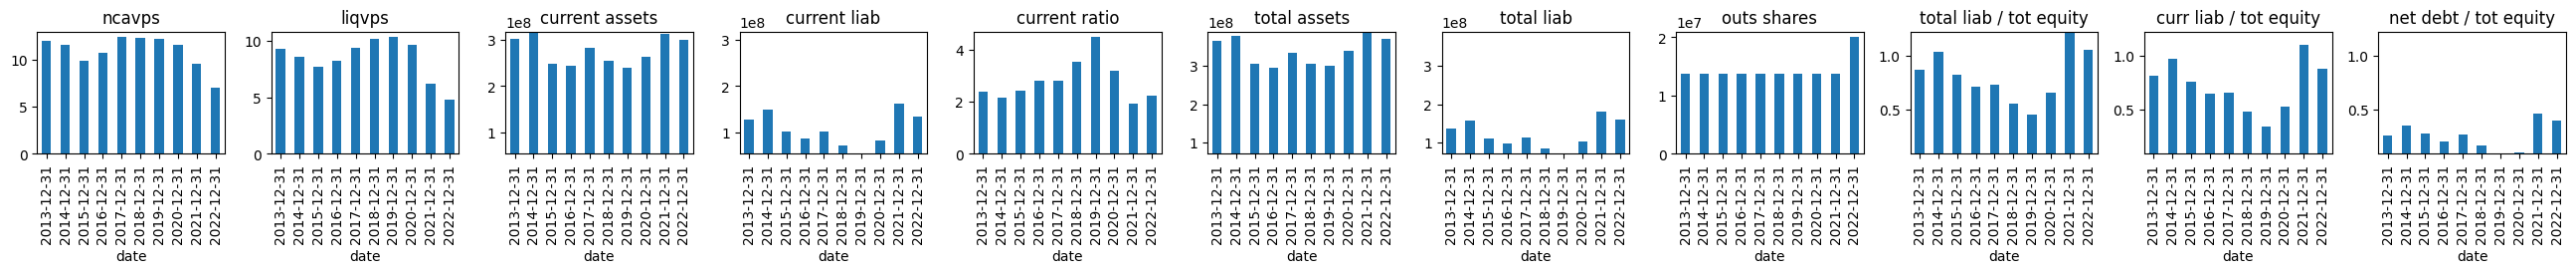

 64%|███████████████████████████████████████████████████████████████████████████                                          | 650/1013 [17:42<11:25,  1.89s/it]

GROM.	 Current price: 1.53.	 NCAV: 6.940861755995032.	 LIQV: 5.698156109678036


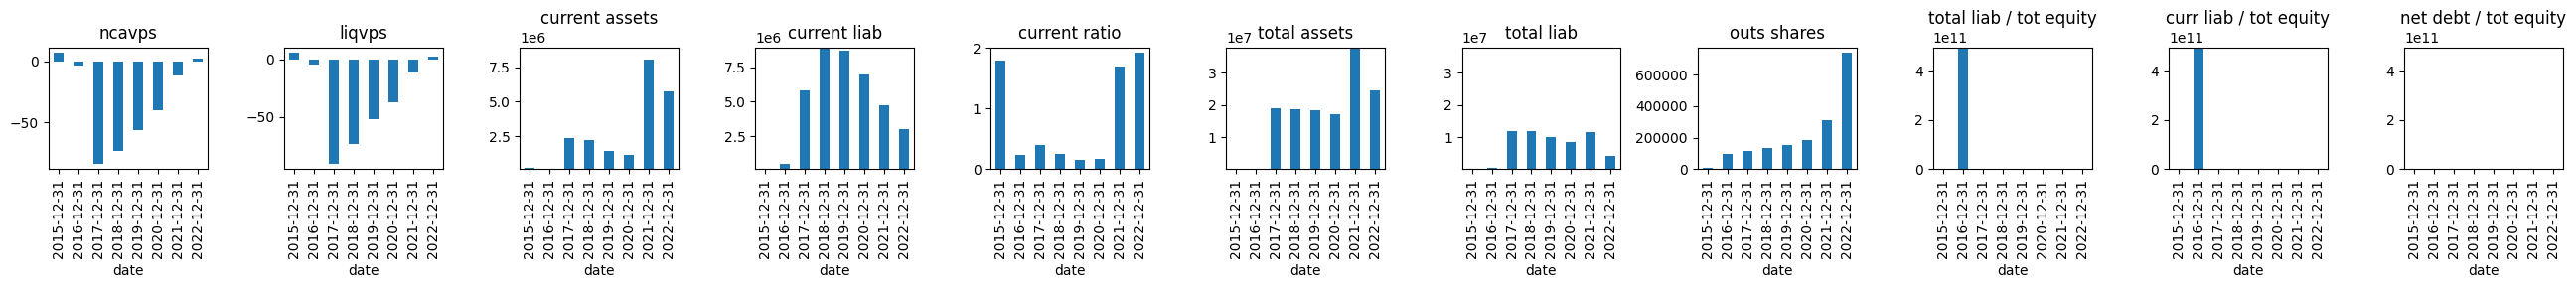

 65%|███████████████████████████████████████████████████████████████████████████▌                                         | 654/1013 [17:51<12:27,  2.08s/it]

TLRS.	 Current price: 0.0551.	 NCAV: 0.05586863105211441.	 LIQV: 1.7316496653877014


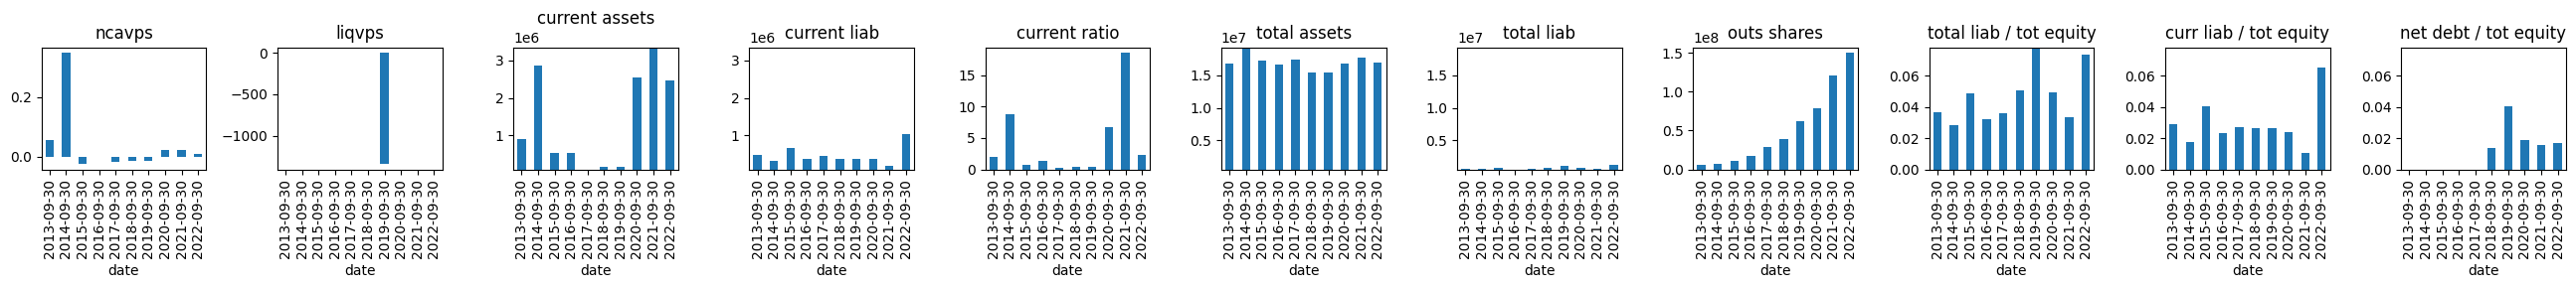

 65%|████████████████████████████████████████████████████████████████████████████                                         | 659/1013 [18:02<11:46,  2.00s/it]

MRIN.	 Current price: 0.425.	 NCAV: 26.60119988730605.	 LIQV: 27.660084073519236


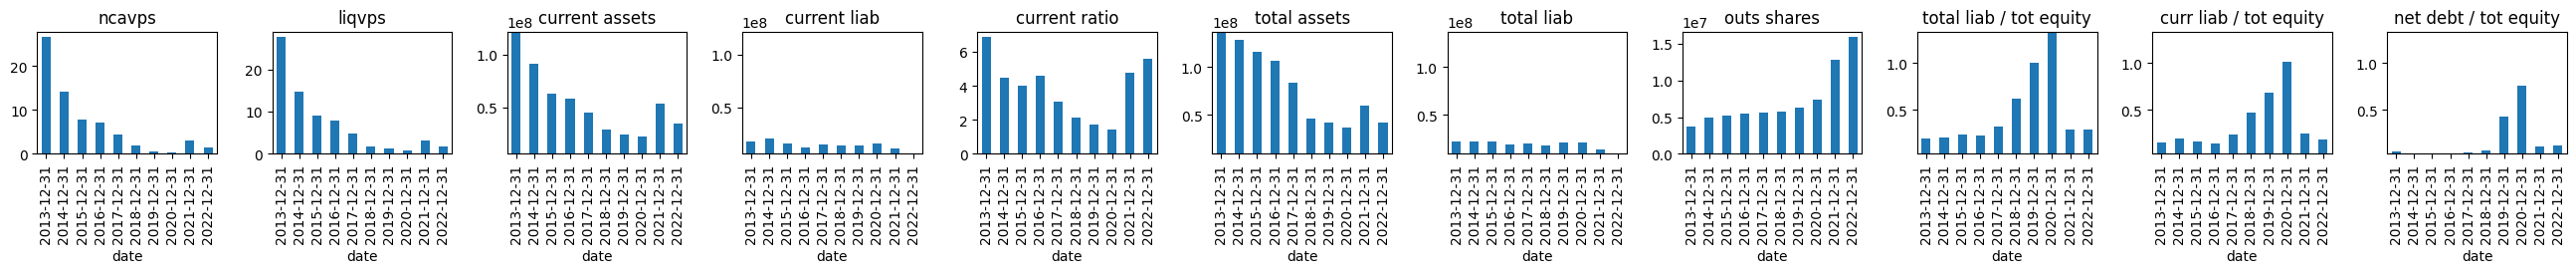

 65%|████████████████████████████████████████████████████████████████████████████▍                                        | 662/1013 [18:09<11:37,  1.99s/it]

FTEK.	 Current price: 1.14.	 NCAV: 2.118340050489393.	 LIQV: 2.037366136675672


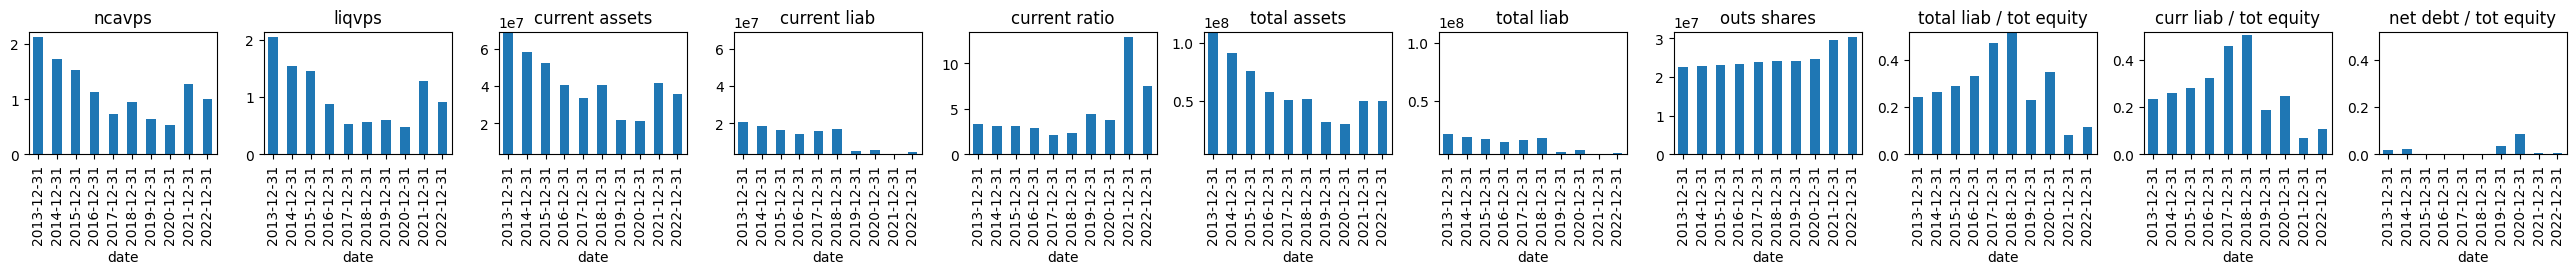

 67%|██████████████████████████████████████████████████████████████████████████████▎                                      | 678/1013 [18:38<06:13,  1.11s/it]

APEI.	 Current price: 4.71.	 NCAV: 2.9015679928575415.	 LIQV: 5.647737849450365


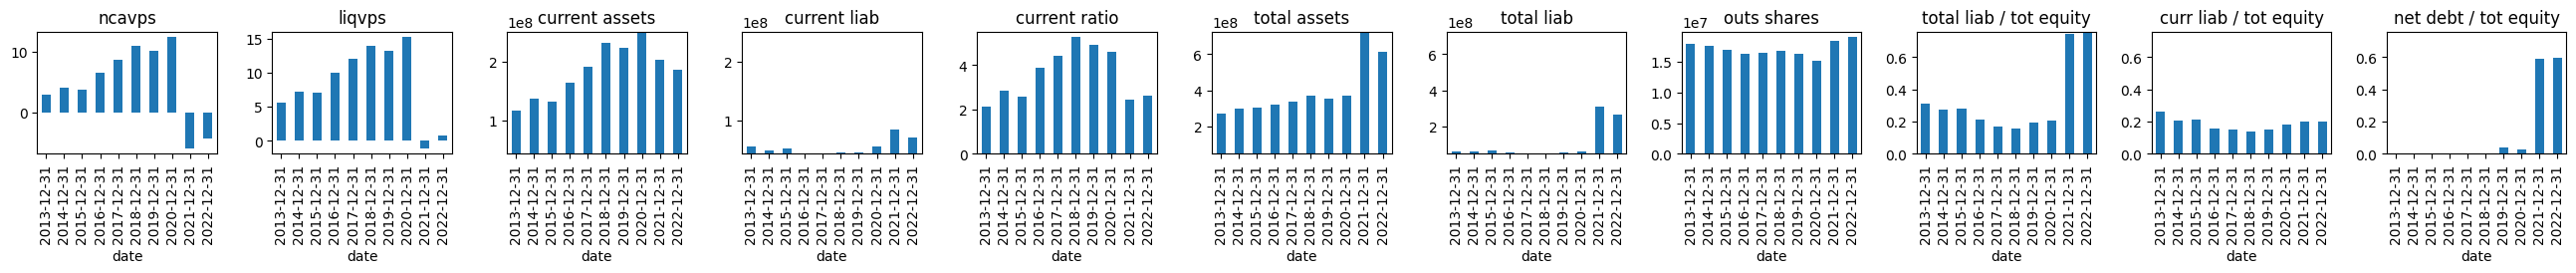

 68%|███████████████████████████████████████████████████████████████████████████████                                      | 685/1013 [18:49<06:25,  1.17s/it]

ALLT.	 Current price: 2.14.	 NCAV: 4.038797621818289.	 LIQV: 1.4206270440539857


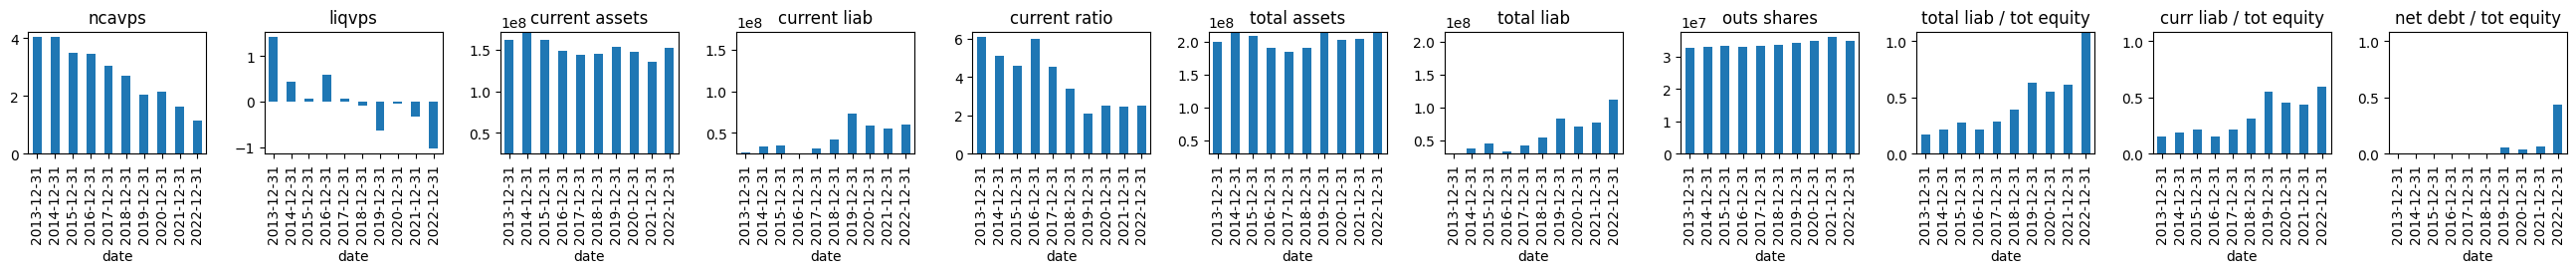

 68%|███████████████████████████████████████████████████████████████████████████████▍                                     | 688/1013 [18:55<07:50,  1.45s/it]

SLGG.	 Current price: 0.0856.	 NCAV: 0.2953397809072178.	 LIQV: 0.4353841211702538


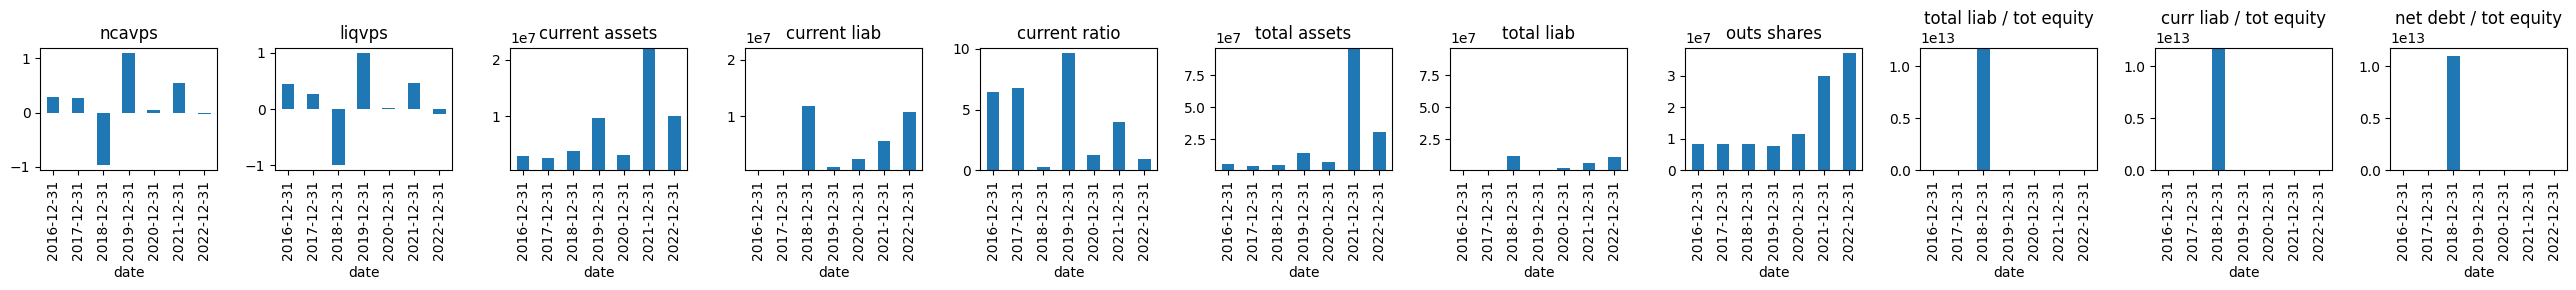

 69%|████████████████████████████████████████████████████████████████████████████████▏                                    | 694/1013 [19:04<06:05,  1.15s/it]

NBY.	 Current price: 0.456.	 NCAV: 175.50655542312276.	 LIQV: 105.73164023104428


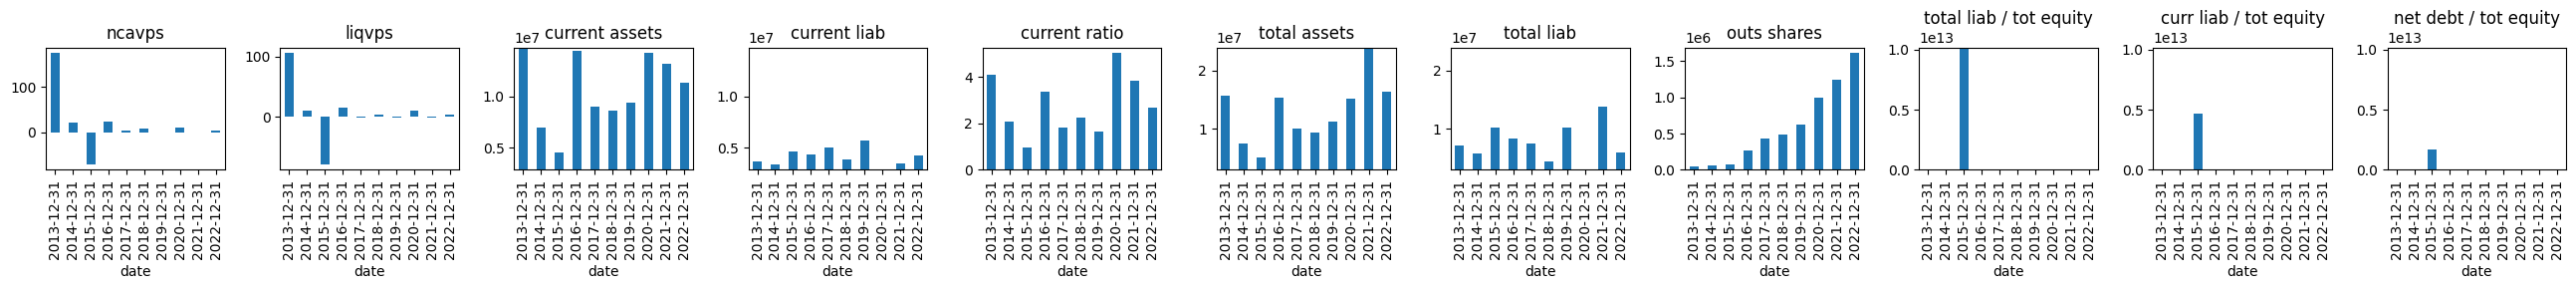

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 703/1013 [19:20<07:39,  1.48s/it]

SLNH.	 Current price: 0.215.	 NCAV: 0.2568382225501296.	 LIQV: 0.1024365956797528


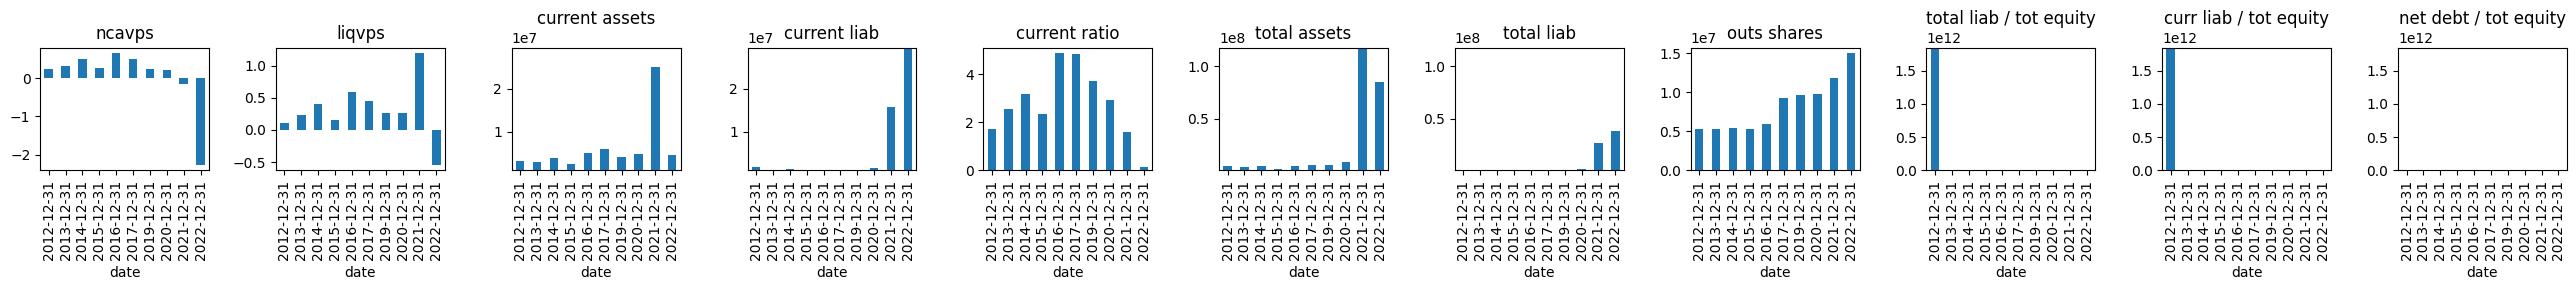

 69%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 704/1013 [19:25<12:35,  2.44s/it]

CAWW.	 Current price: 0.42.	 NCAV: 3.667772163978384.	 LIQV: 1.4021213400010946


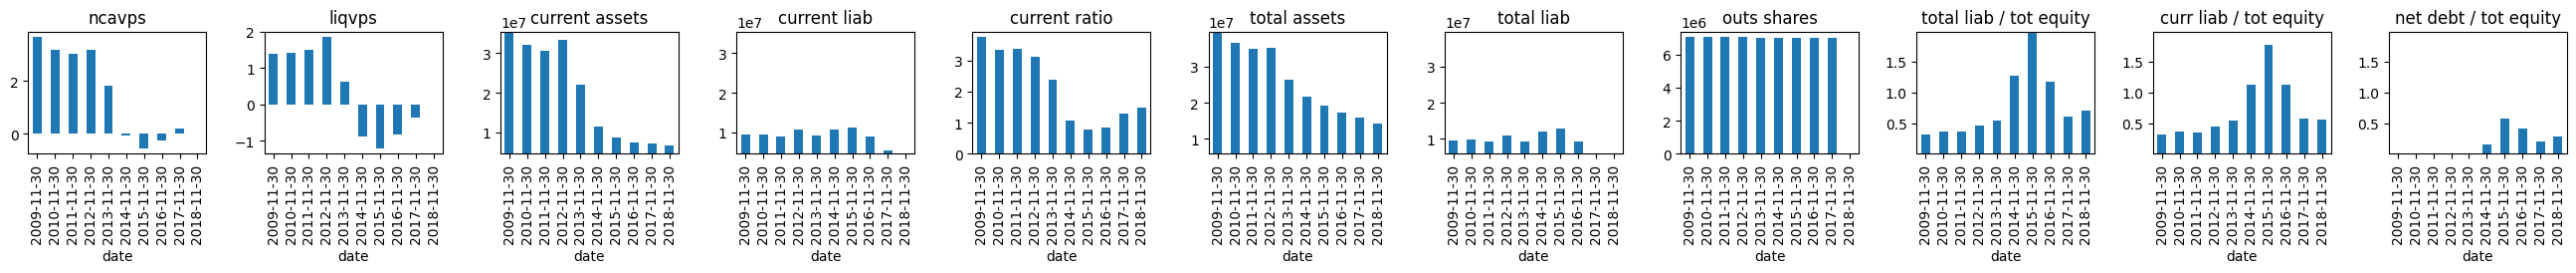

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 705/1013 [19:30<16:36,  3.24s/it]

UEIC.	 Current price: 8.9.	 NCAV: 9.35856675854112.	 LIQV: 8.234414460611498


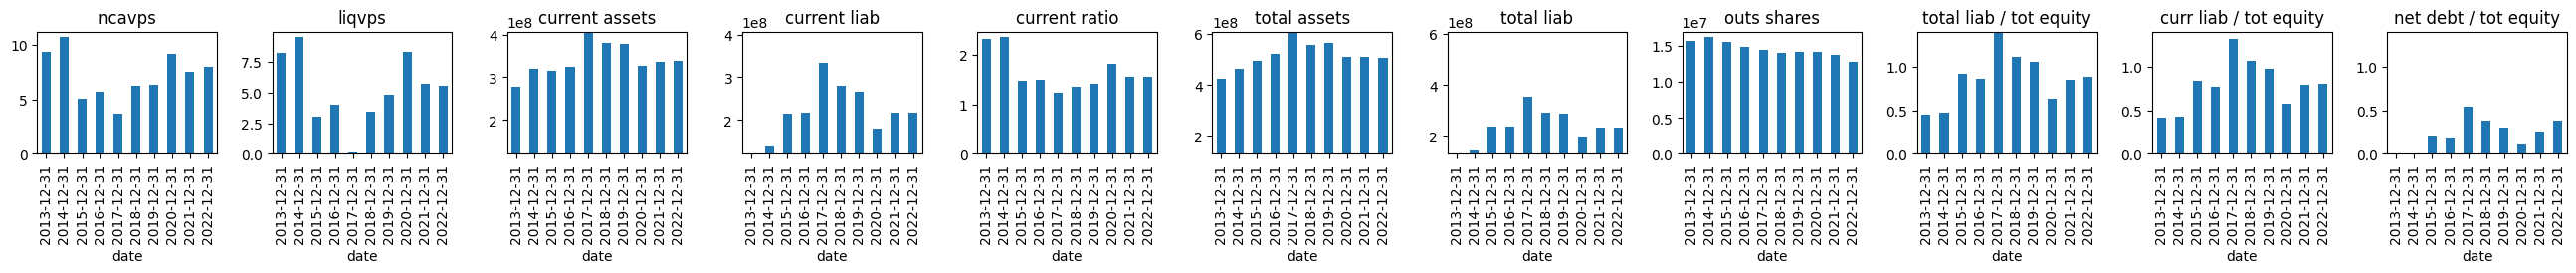

 70%|██████████████████████████████████████████████████████████████████████████████████                                   | 710/1013 [19:42<11:58,  2.37s/it]

dates of last income statement and balance sheet are not the same for ticker PHD
	income stmt date: 2010-11-30, balance sheet date: 2017-11-30


 71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 716/1013 [19:48<05:48,  1.17s/it]

AWRE.	 Current price: 1.45.	 NCAV: 3.4637604346097786.	 LIQV: 3.3941583852303343


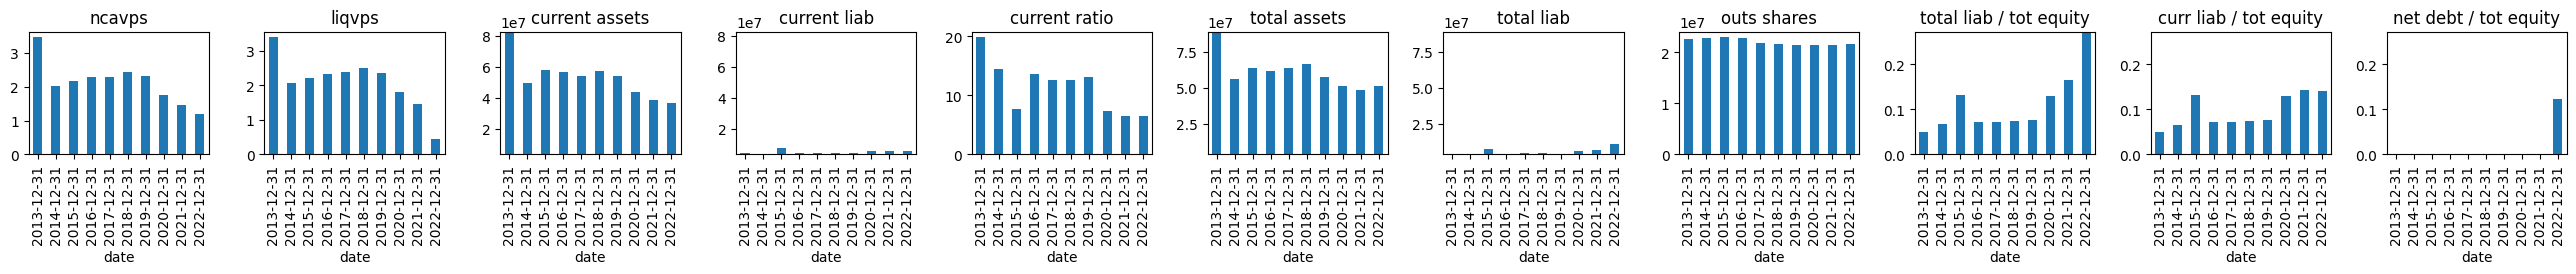

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 719/1013 [19:55<07:17,  1.49s/it]

MOBQ.	 Current price: 0.72.	 NCAV: 13.577151097580517.	 LIQV: 13.958084017455723


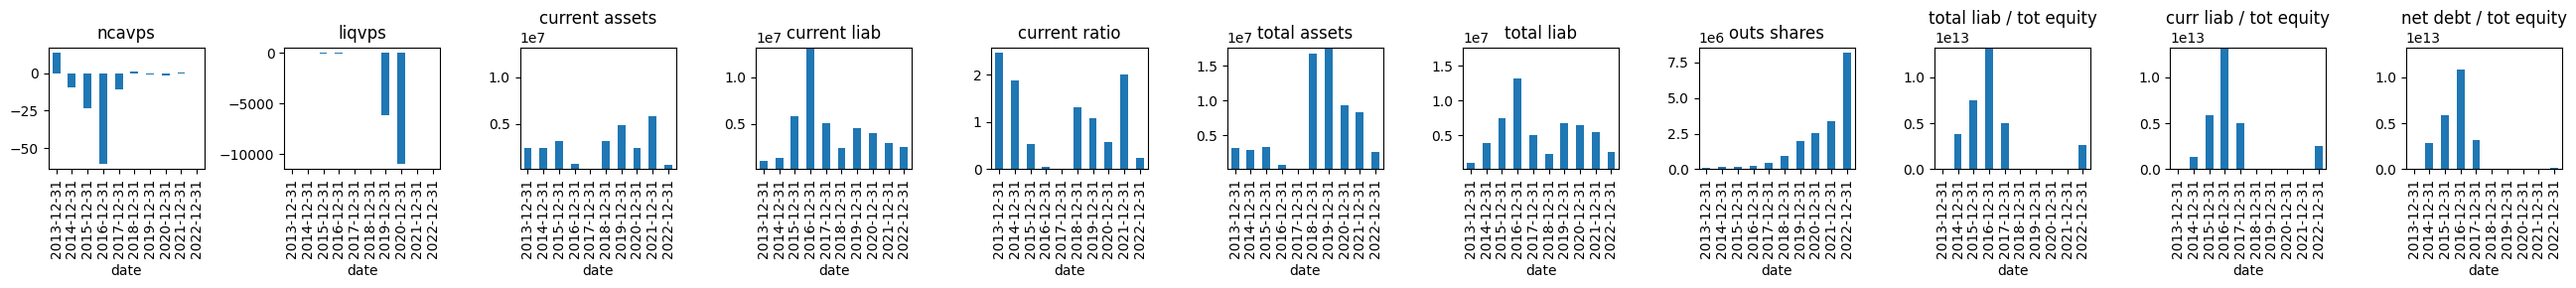

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                               | 738/1013 [20:19<03:30,  1.30it/s]

JVA.	 Current price: 0.848.	 NCAV: 2.9131647570762813.	 LIQV: 1.7914607562188212


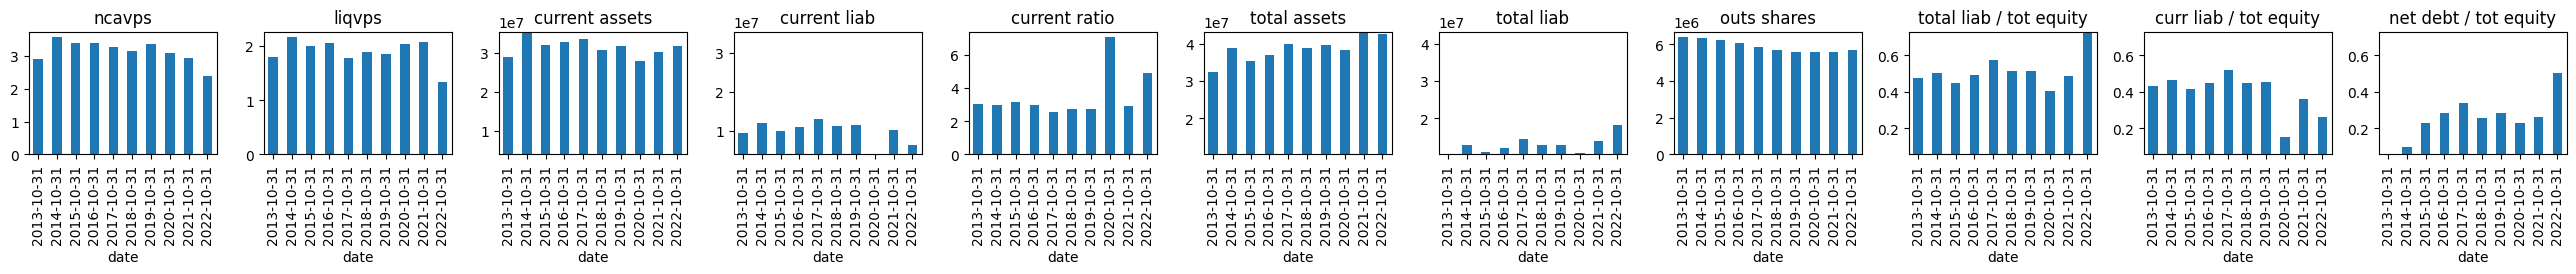

 73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 742/1013 [20:27<06:19,  1.40s/it]

RTC.	 Current price: 4.205.	 NCAV: -42.22346411483254.	 LIQV: 43.264315406698564


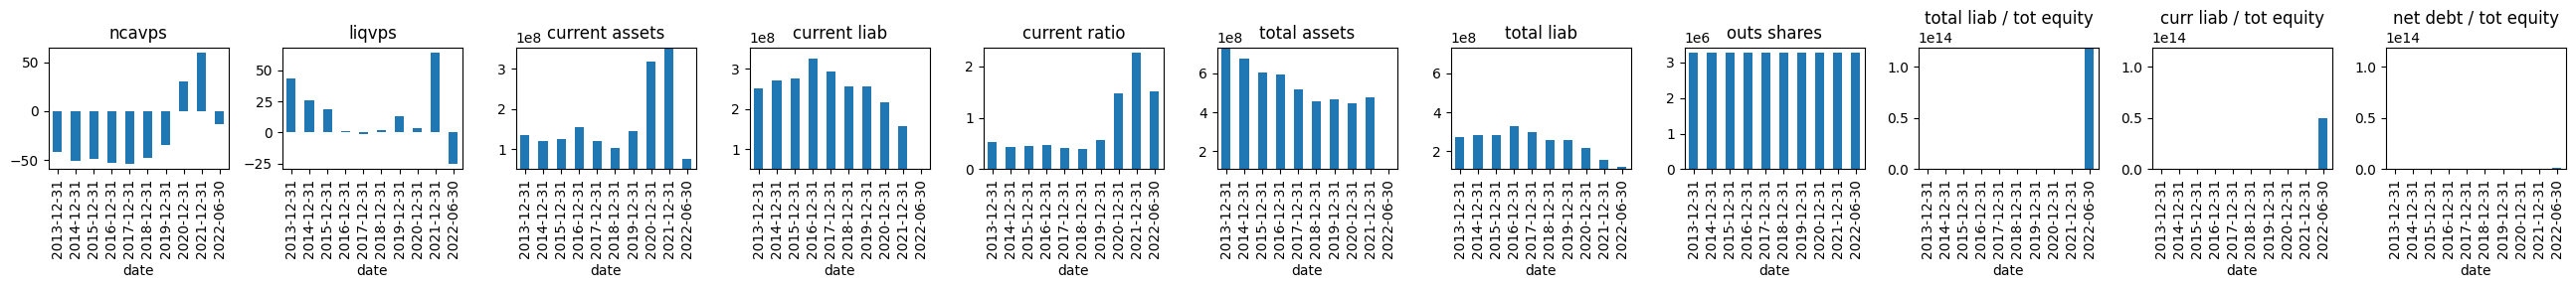

 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 750/1013 [20:40<06:30,  1.48s/it]

SANW.	 Current price: 1.05.	 NCAV: 1.5045722884691777.	 LIQV: 0.5809134477754143


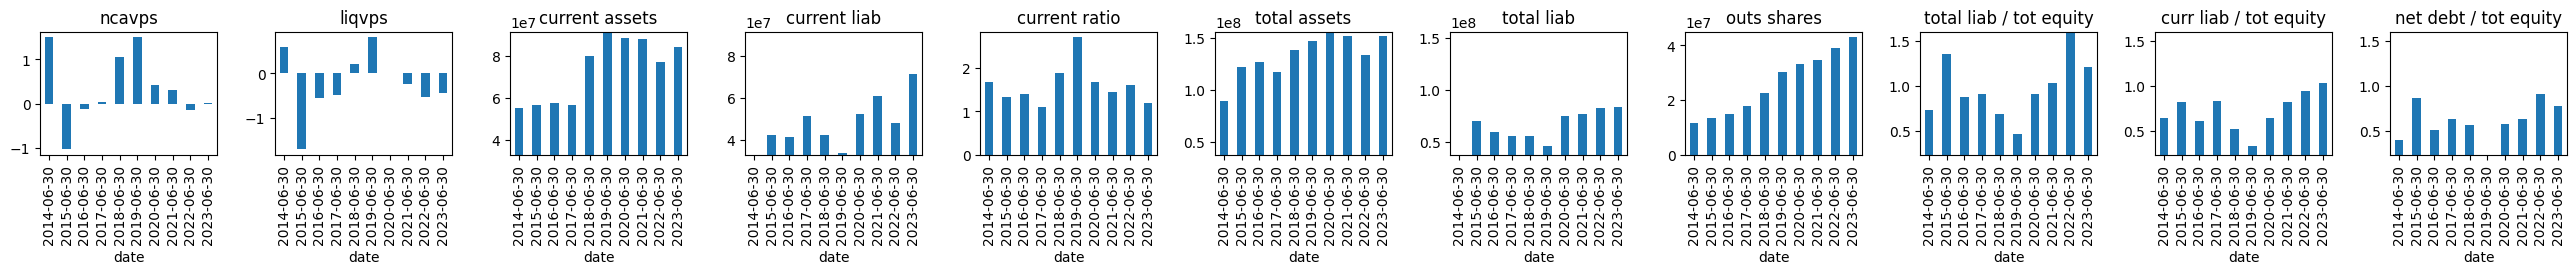

 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                           | 772/1013 [21:11<06:33,  1.63s/it]

dates of last income statement and balance sheet are not the same for ticker AREB
	income stmt date: 2015-12-31, balance sheet date: 2014-12-31


 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 774/1013 [21:15<07:23,  1.85s/it]

JAN.	 Current price: 0.429.	 NCAV: 3.5614768373389065.	 LIQV: 1.276105886450714


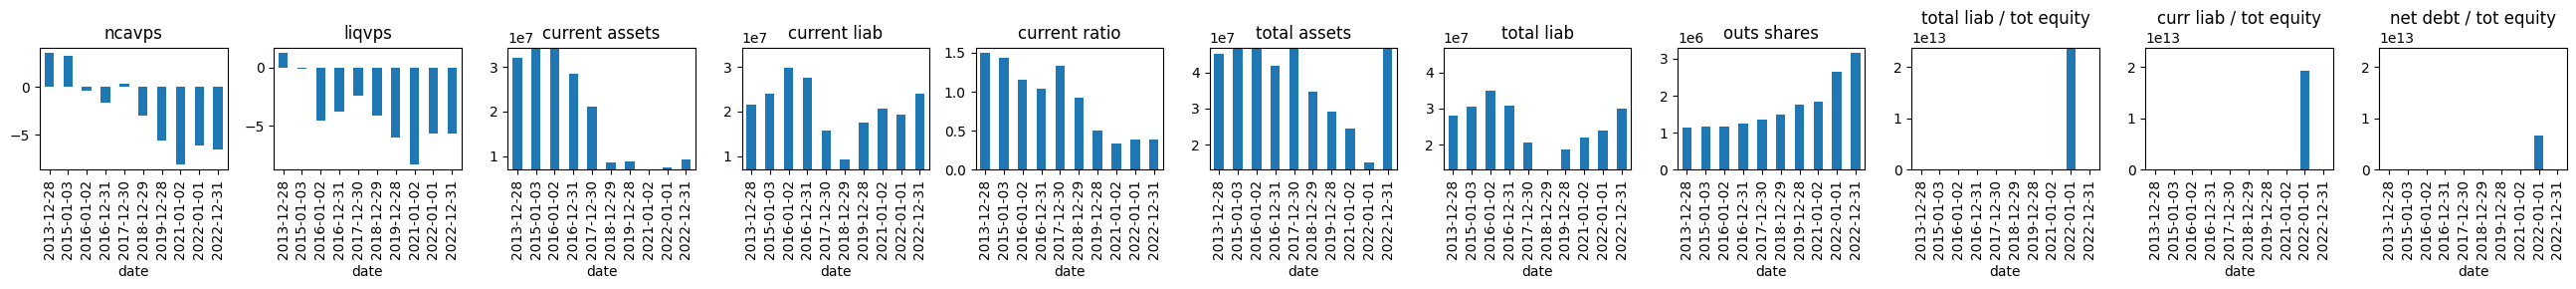

 77%|█████████████████████████████████████████████████████████████████████████████████████████▌                           | 775/1013 [21:19<10:34,  2.67s/it]

WPRT.	 Current price: 5.915.	 NCAV: 26.192719854653195.	 LIQV: 21.983067395714173


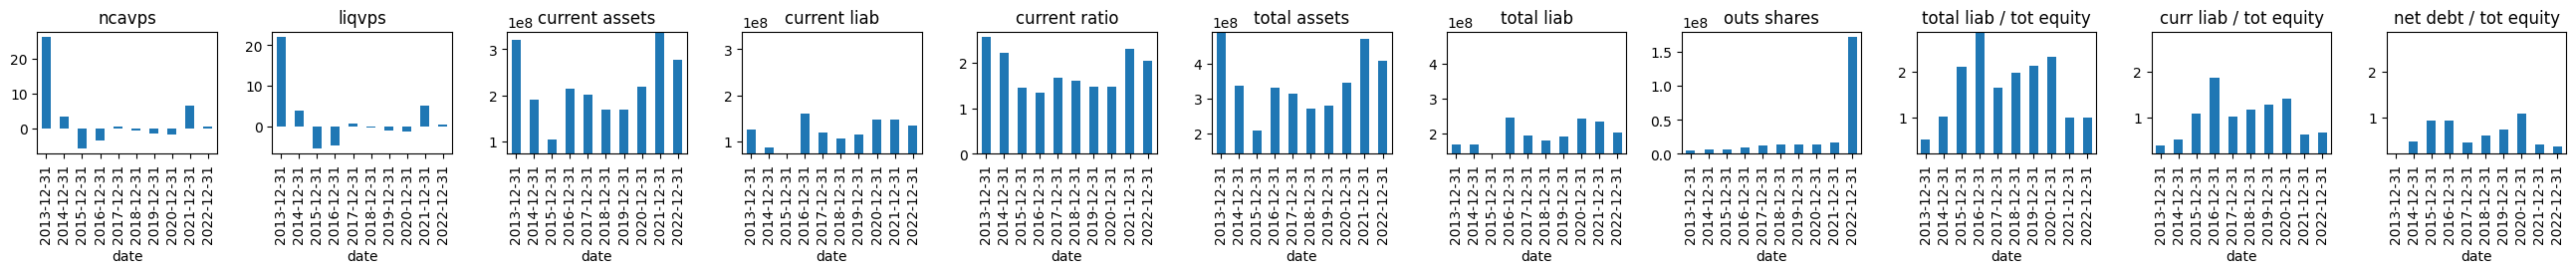

 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 780/1013 [21:28<05:48,  1.50s/it]

UTSI.	 Current price: 3.6.	 NCAV: 5.7145193855905125.	 LIQV: -2.1430347330487898


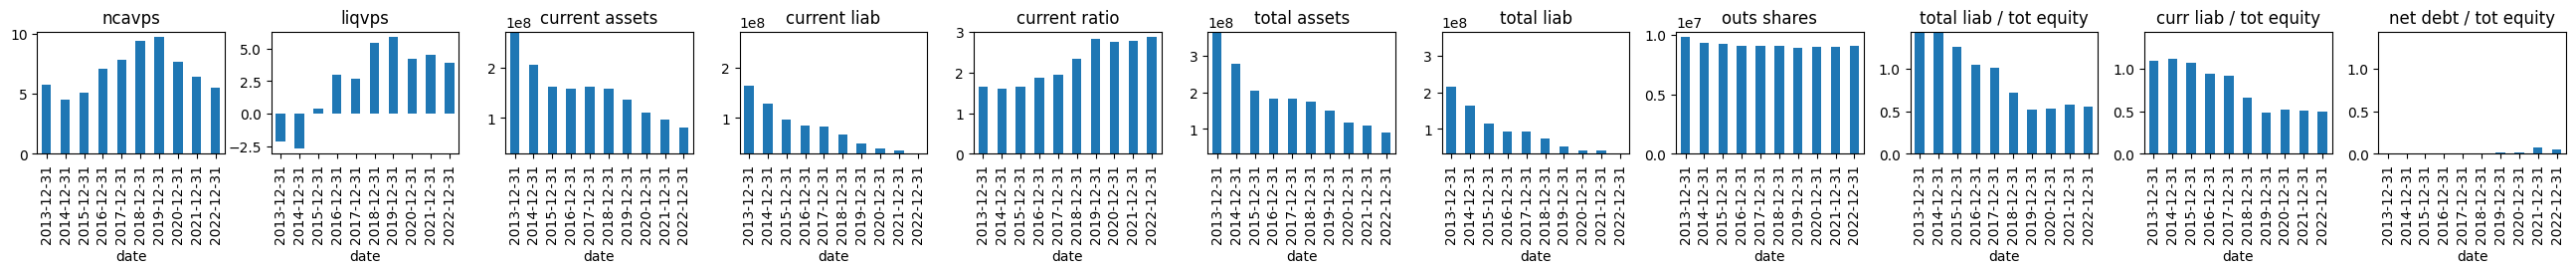

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                         | 792/1013 [21:47<04:14,  1.15s/it]

ISIG.	 Current price: 7.73.	 NCAV: 8.532793442876022.	 LIQV: 11.034642275634106


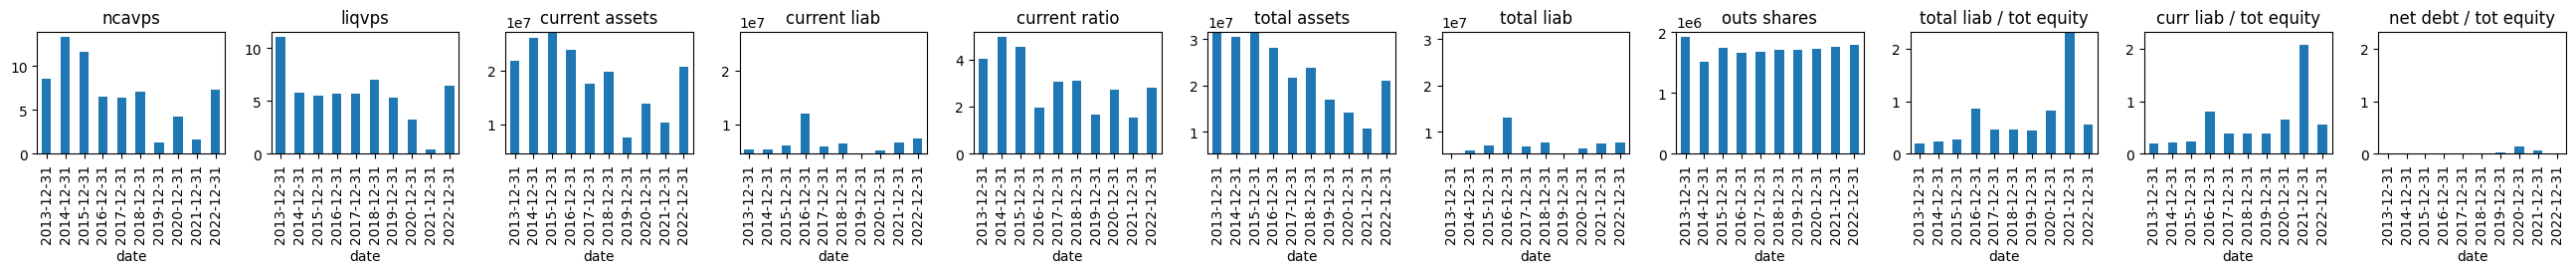

 79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 800/1013 [22:03<05:09,  1.45s/it]

PLAG.	 Current price: 0.7805.	 NCAV: 61.72898774291021.	 LIQV: 58.033466534938356


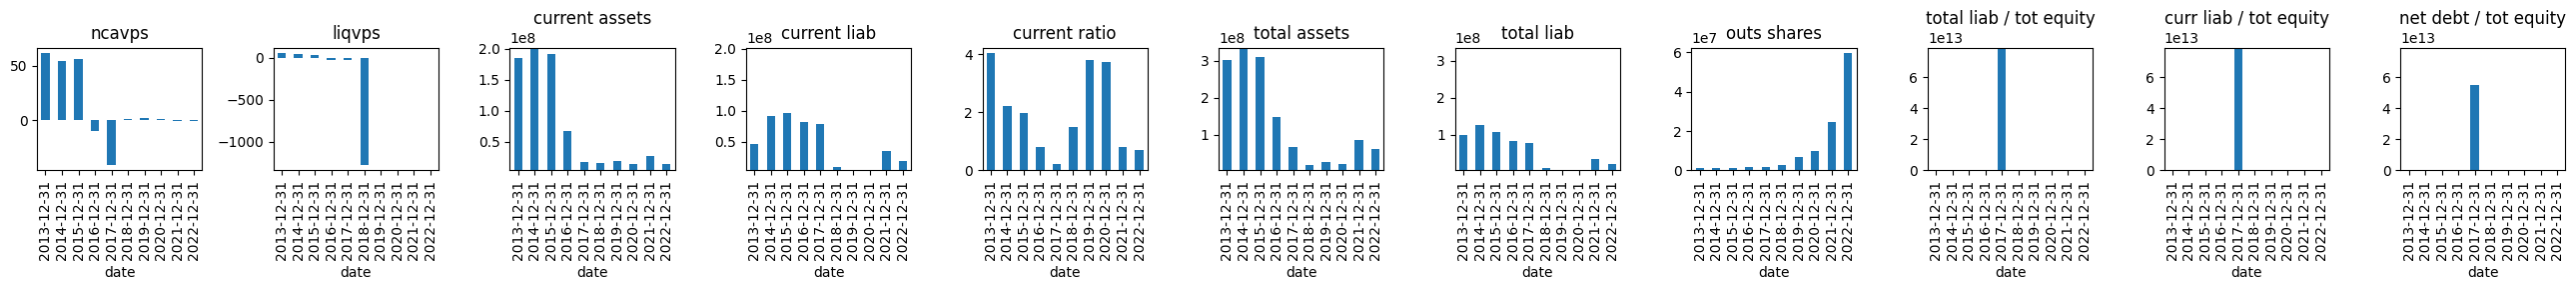

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 806/1013 [22:15<06:30,  1.88s/it]

GLBS.	 Current price: 2.06.	 NCAV: -28737.563650607128.	 LIQV: 439.087348217783


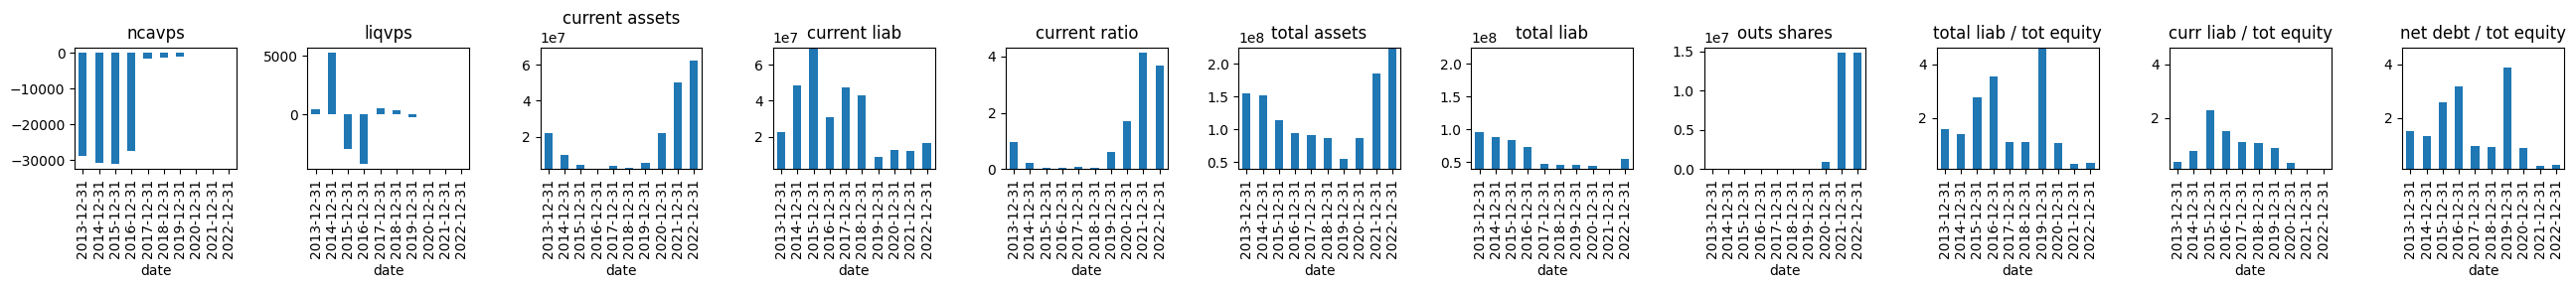

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 810/1013 [22:24<06:43,  1.99s/it]

GLG.	 Current price: 0.1402.	 NCAV: 186.9517574448226.	 LIQV: -44.035643775923816


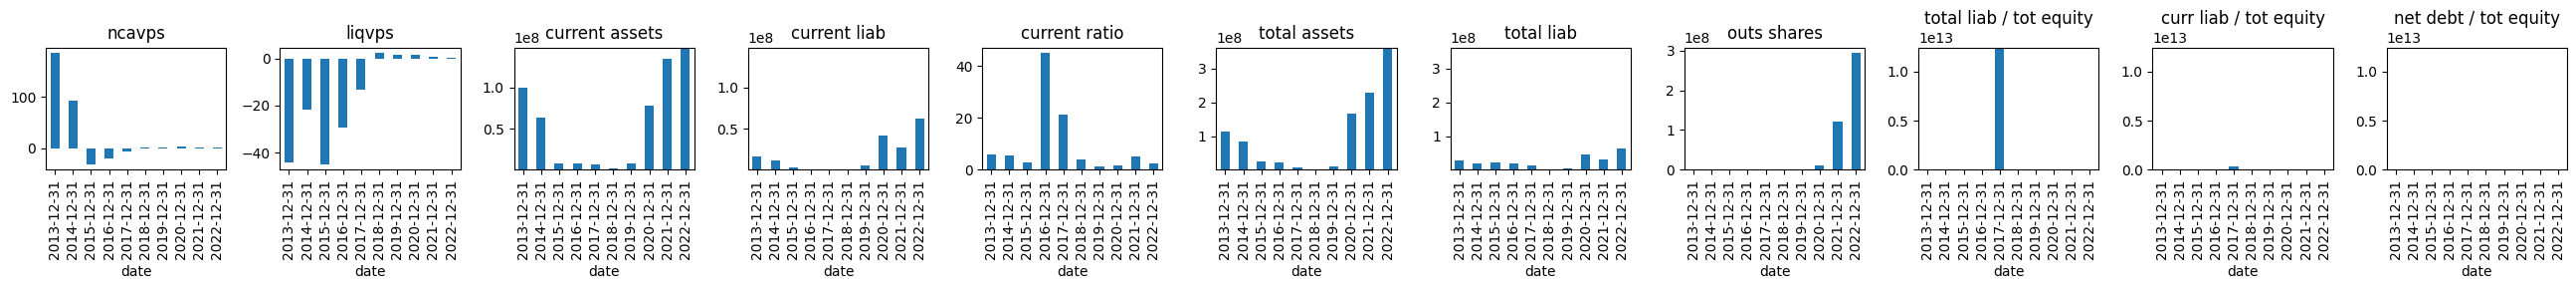

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▉                      | 822/1013 [22:40<02:58,  1.07it/s]

IVAC.	 Current price: 3.17.	 NCAV: 3.7523917421953676.	 LIQV: 3.5561828633769723


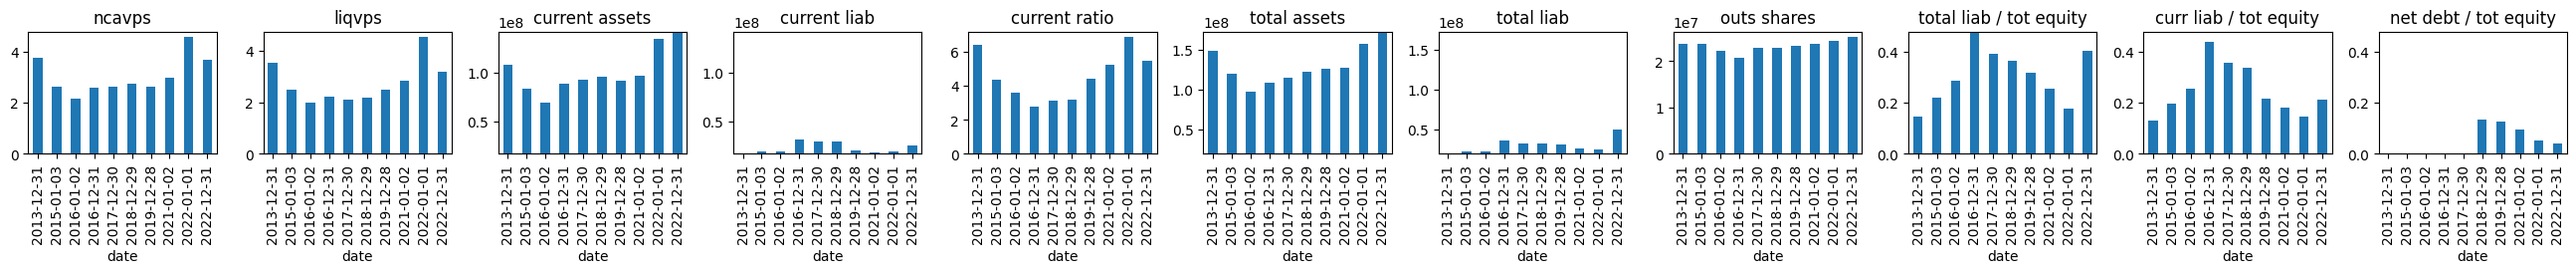

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                     | 824/1013 [22:46<06:36,  2.10s/it]

GAU.	 Current price: 0.58.	 NCAV: 1.8975273439865055.	 LIQV: 2.394189449975767


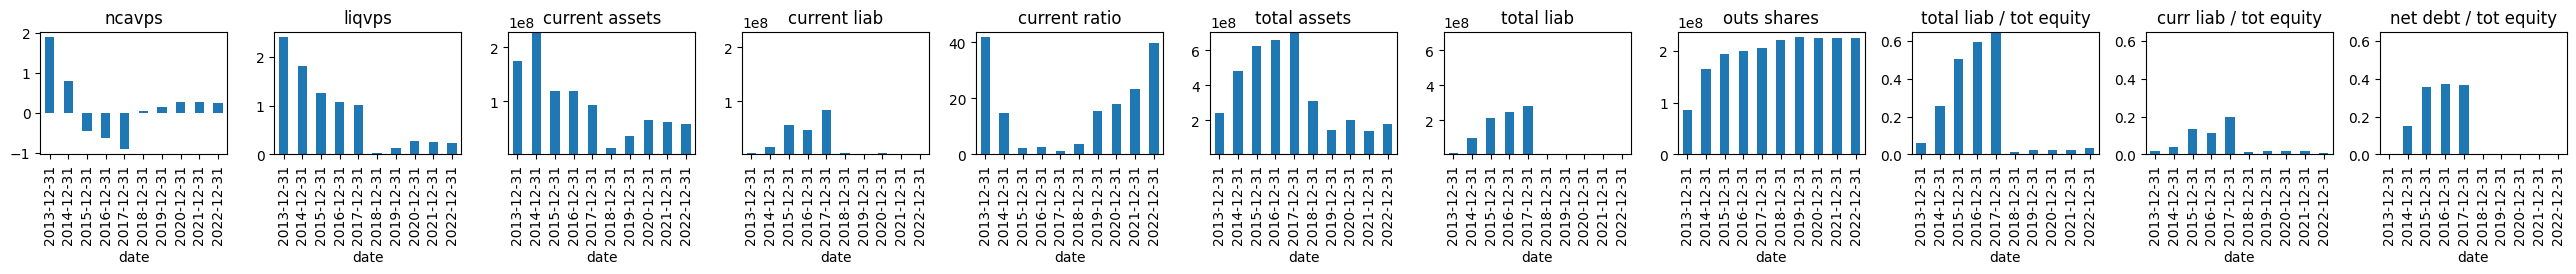

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 834/1013 [23:01<04:33,  1.53s/it]

WWR.	 Current price: 0.6272.	 NCAV: -300.4142071035518.	 LIQV: 324.2019863056529


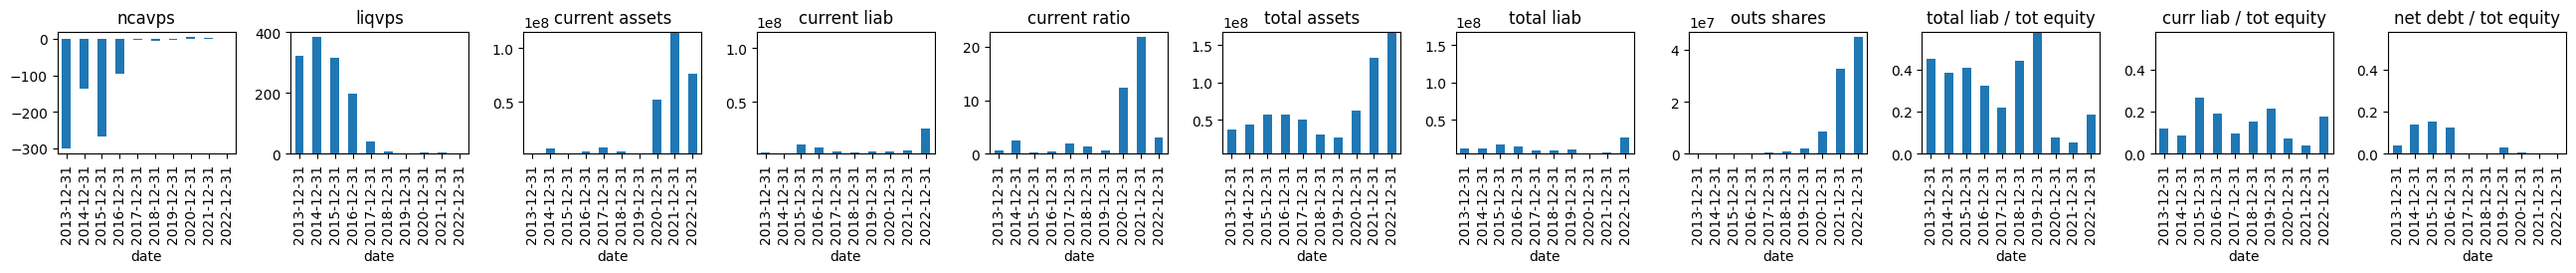

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 835/1013 [23:06<07:26,  2.51s/it]

SGLY.	 Current price: 0.51375.	 NCAV: 4.243827722621306.	 LIQV: 3.105987119646246


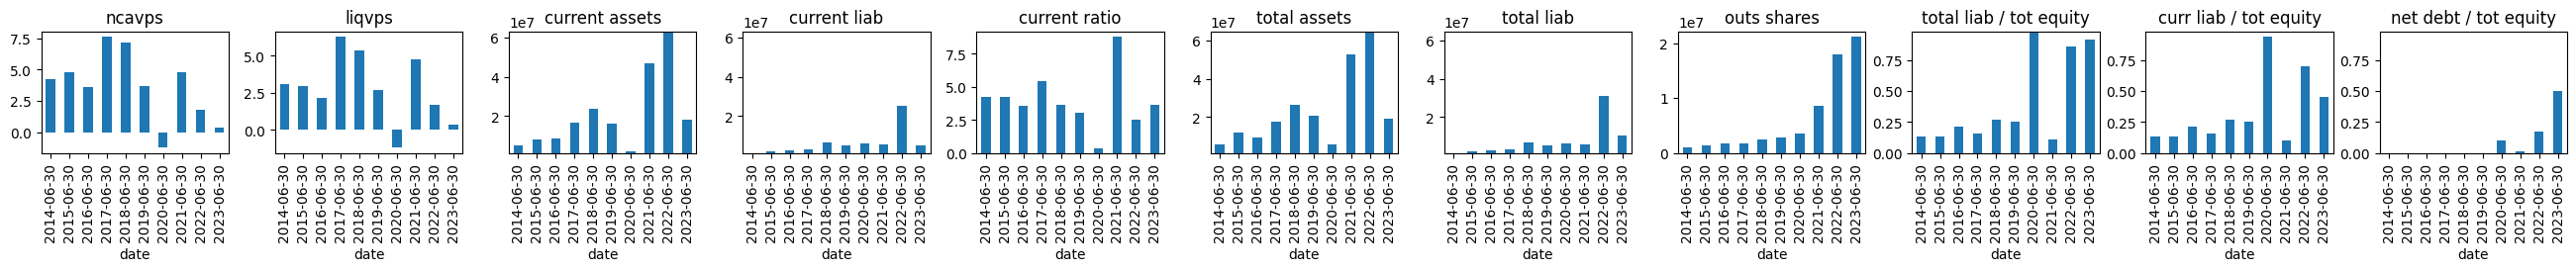

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 836/1013 [23:11<09:44,  3.30s/it]

UUU.	 Current price: 2.37.	 NCAV: 3.5501063314134.	 LIQV: 2.4830544146095432


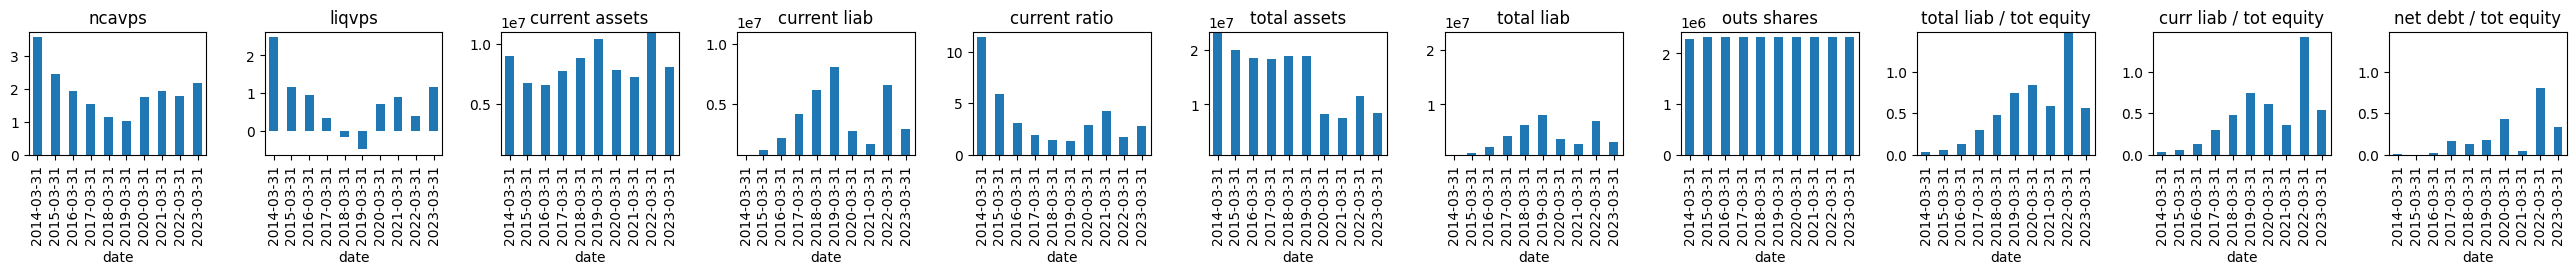

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 843/1013 [23:20<02:59,  1.05s/it]

EGIO.	 Current price: 0.8233.	 NCAV: 1.2140401234886578.	 LIQV: 0.976055487294917


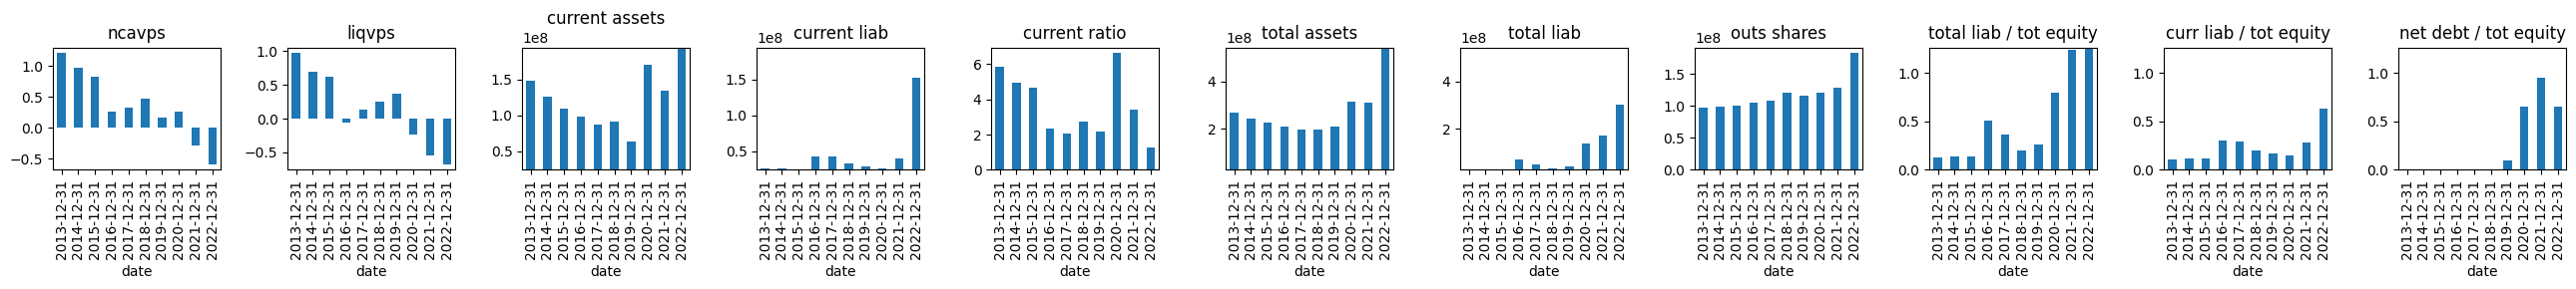

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 849/1013 [23:29<02:51,  1.05s/it]

GEOS.	 Current price: 13.15.	 NCAV: 15.066164883676912.	 LIQV: 12.78761071180395


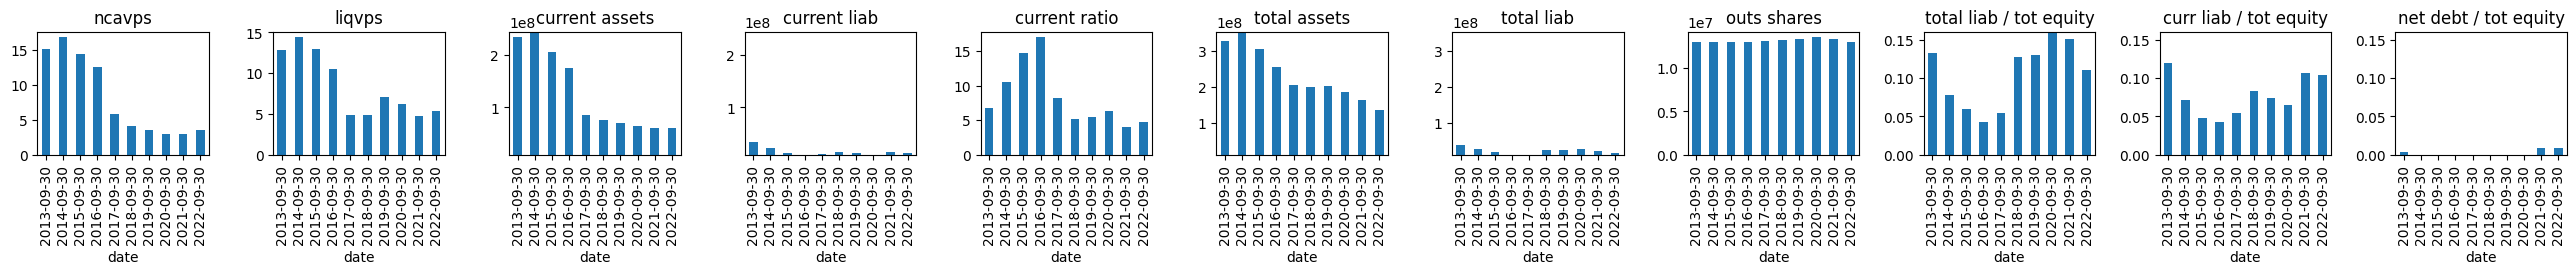

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 857/1013 [23:41<02:40,  1.03s/it]

EJH.	 Current price: 1.1.	 NCAV: 54.01074285714286.	 LIQV: 45.4849185


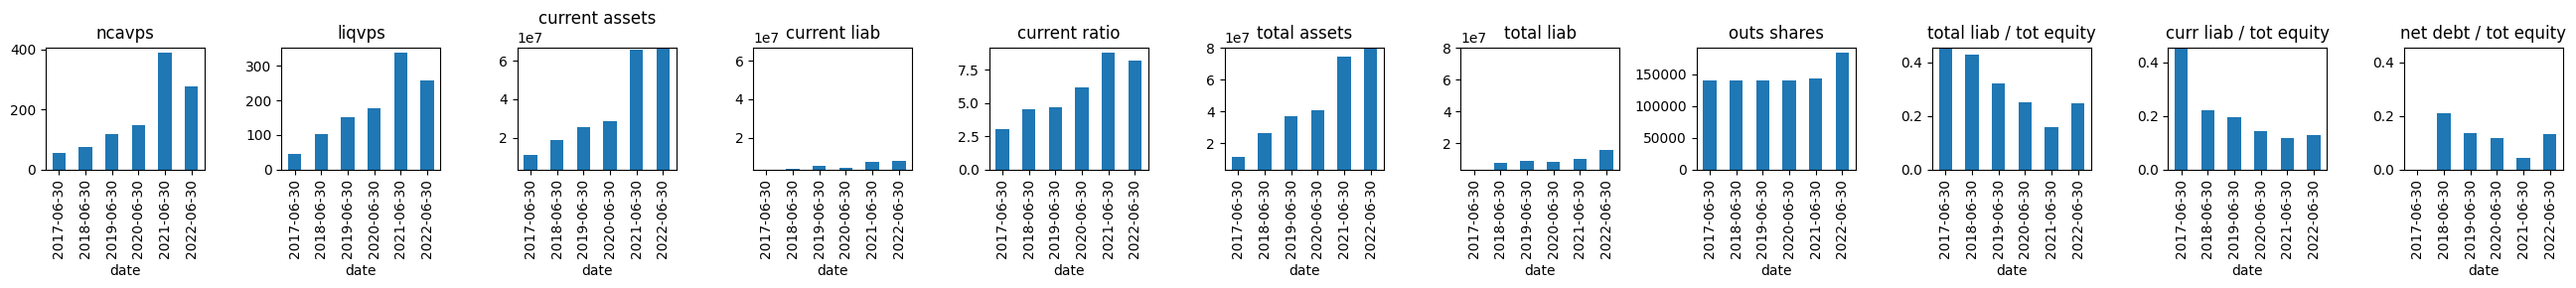

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 860/1013 [23:47<03:26,  1.35s/it]

SISI.	 Current price: 0.1277.	 NCAV: 6.502764799451263.	 LIQV: 5.256973953341157


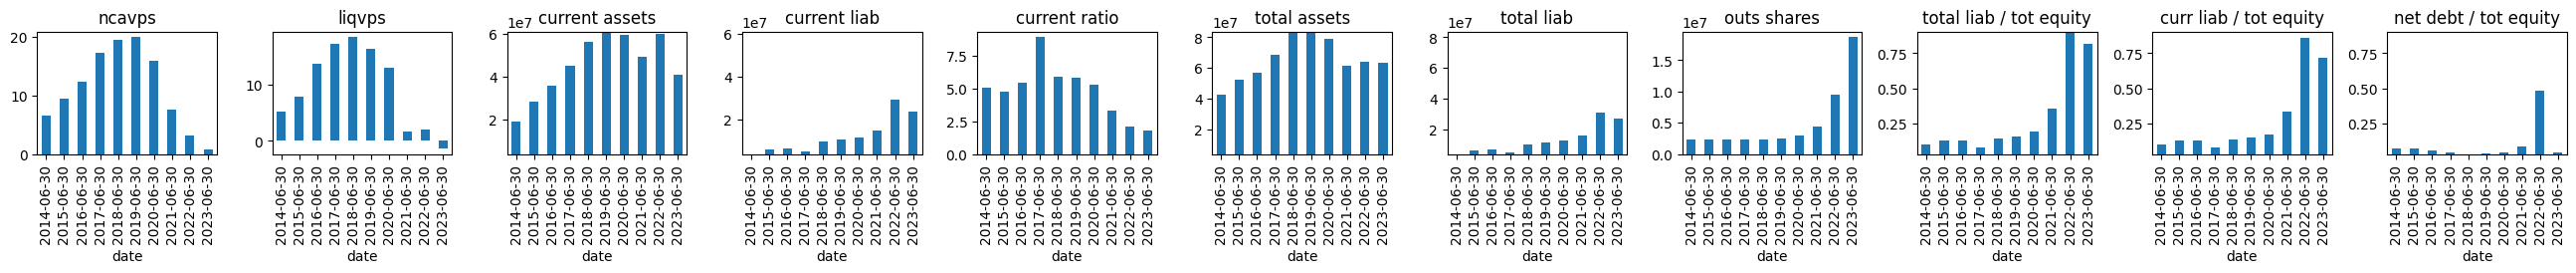

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 878/1013 [24:10<03:35,  1.60s/it]

dates of last income statement and balance sheet are not the same for ticker PML
	income stmt date: 2010-05-31, balance sheet date: 2017-12-31


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 881/1013 [24:14<02:51,  1.30s/it]

ANY.	 Current price: 1.32.	 NCAV: 444.29999750626064.	 LIQV: 390.6948200985871


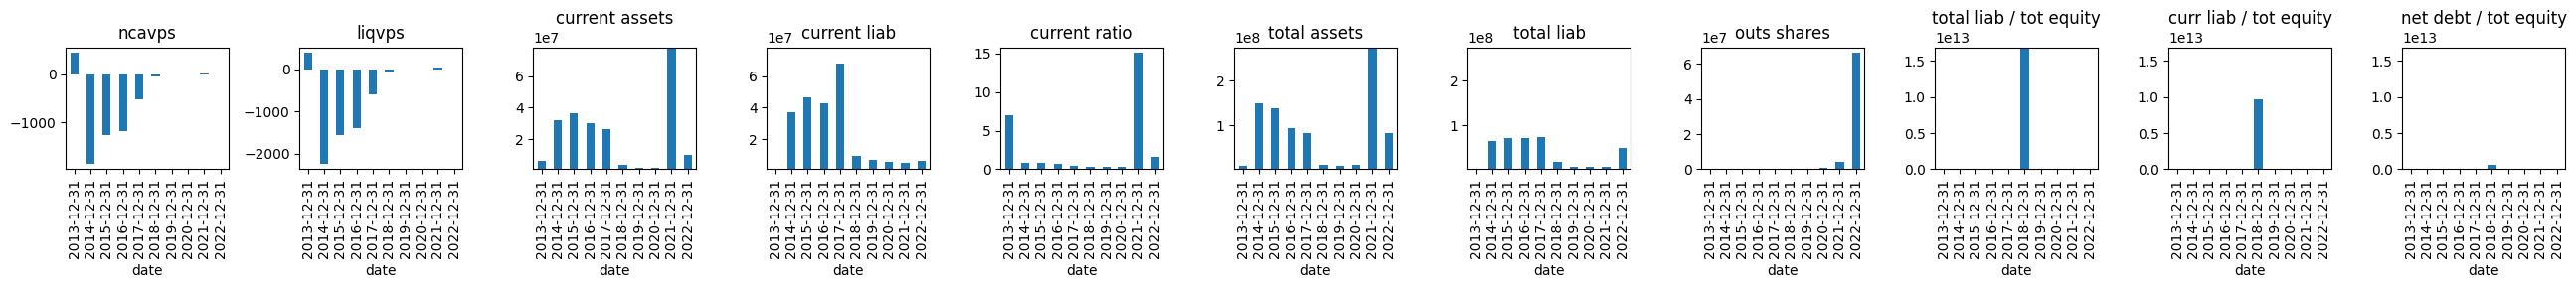

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 888/1013 [24:26<02:54,  1.40s/it]

dates of last income statement and balance sheet are not the same for ticker WORX
	income stmt date: 2016-12-31, balance sheet date: 2015-12-31


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 894/1013 [24:33<02:24,  1.21s/it]

BRGO.	 Current price: 0.0005.	 NCAV: 7096.950617283951.	 LIQV: 4093.741069958848


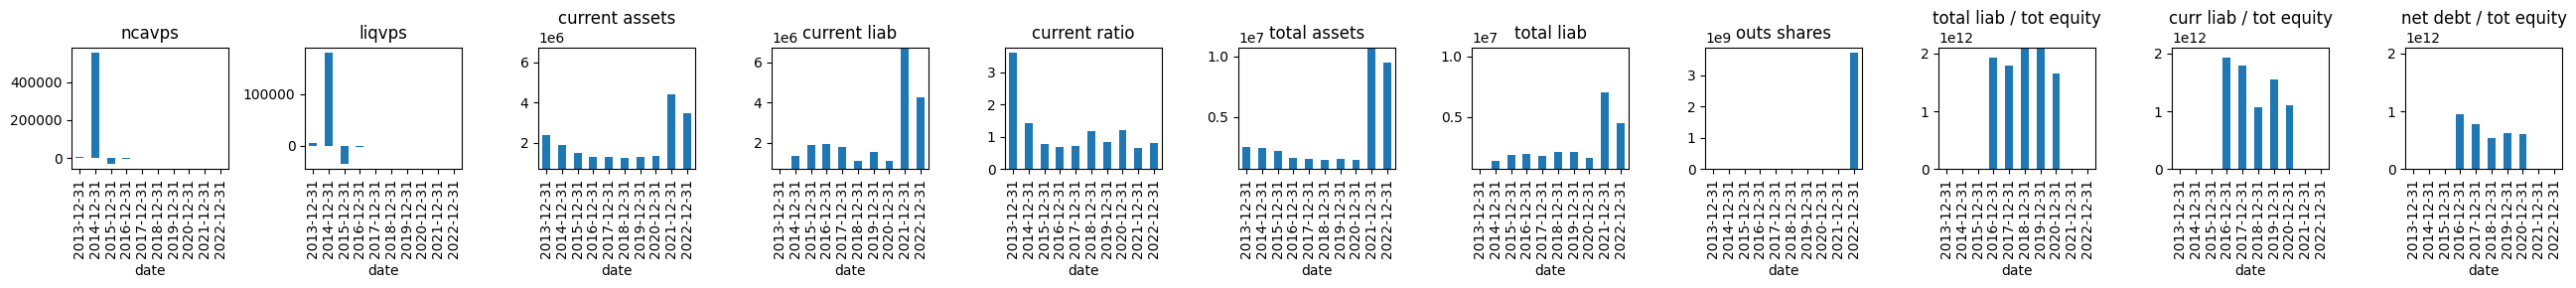

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 899/1013 [24:41<02:13,  1.17s/it]

OPTT.	 Current price: 0.394.	 NCAV: 421.9947183975818.	 LIQV: 133.52062831138198


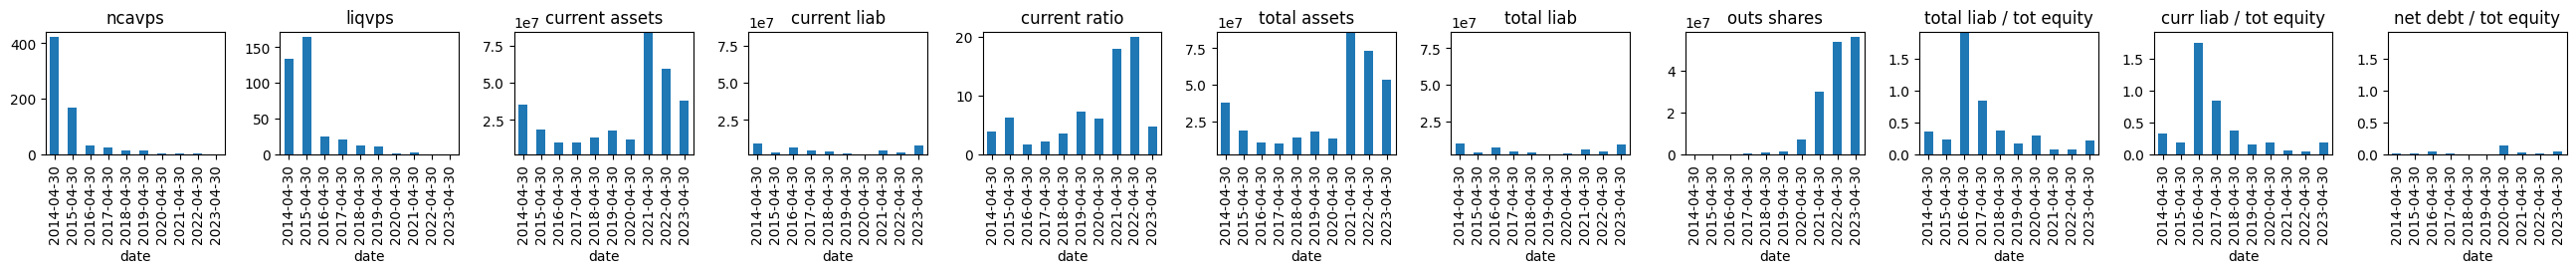

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 908/1013 [24:57<02:46,  1.59s/it]

LGL.	 Current price: 4.32.	 NCAV: 4.795477470965515.	 LIQV: 4.127601467540944


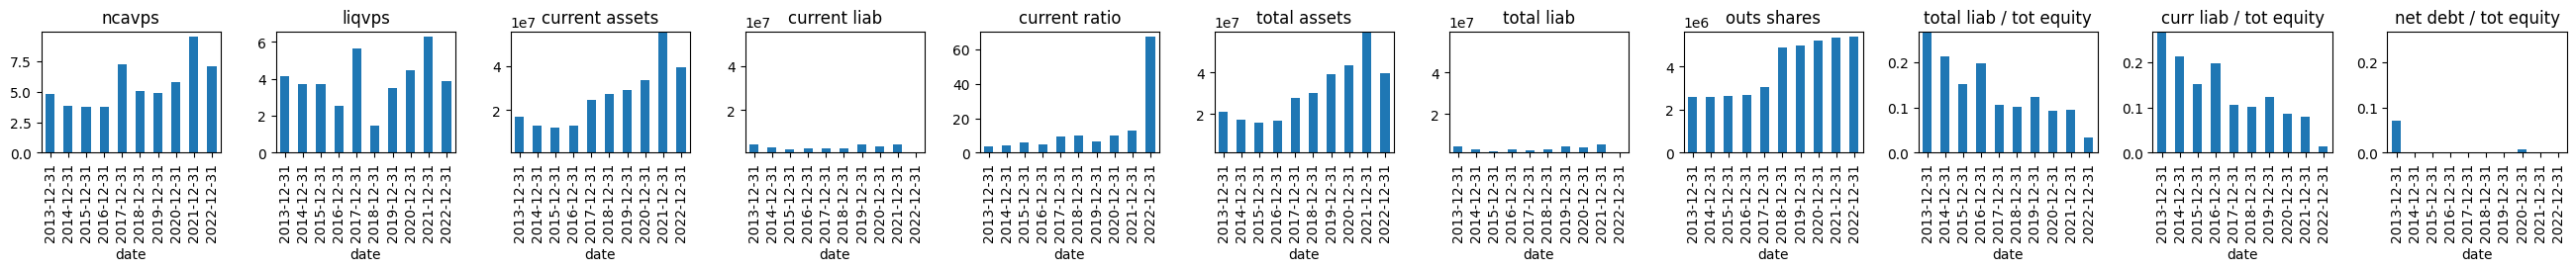

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 913/1013 [25:06<02:34,  1.55s/it]

GASS.	 Current price: 5.09.	 NCAV: -9.92175166684081.	 LIQV: 7.575463481809723


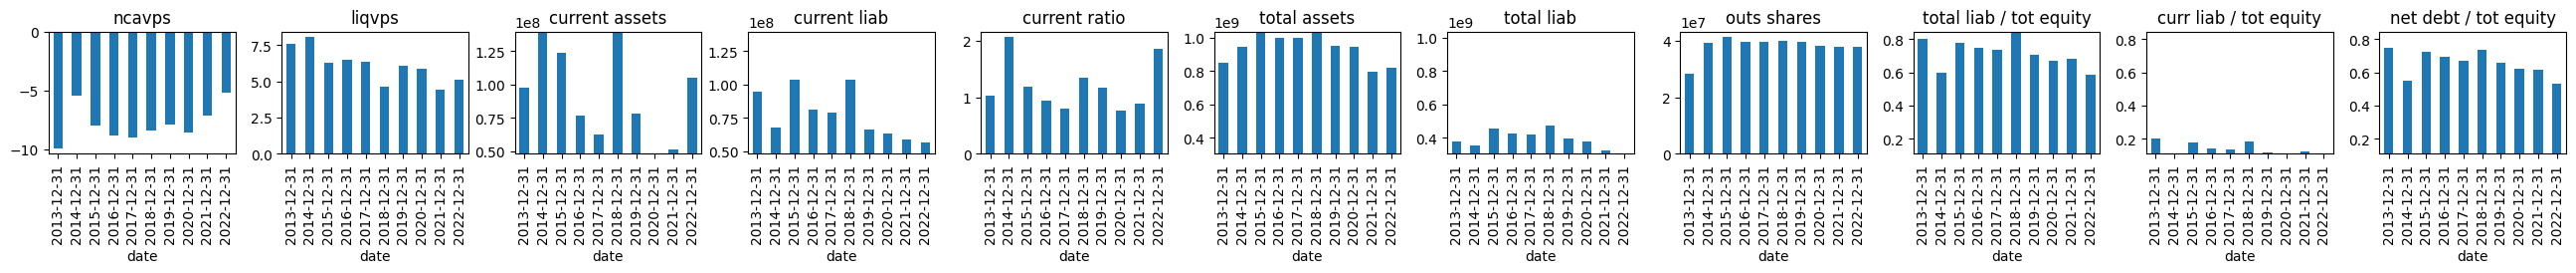

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 933/1013 [25:30<01:50,  1.38s/it]

dates of last income statement and balance sheet are not the same for ticker TMNA
	income stmt date: 2016-12-31, balance sheet date: 2015-06-30
UAVS.	 Current price: 0.166.	 NCAV: -159.39623931165733.	 LIQV: 21.56730720776265


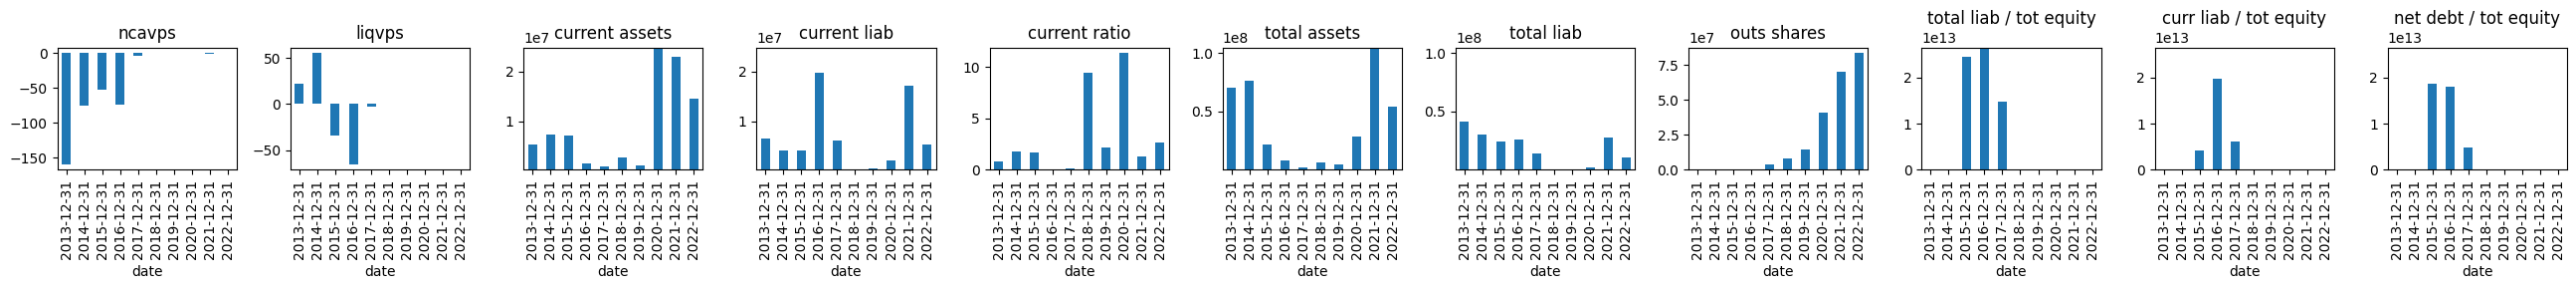

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 934/1013 [25:35<03:06,  2.36s/it]

TANH.	 Current price: 1.26.	 NCAV: 317.94092222222224.	 LIQV: 166.35202988888886


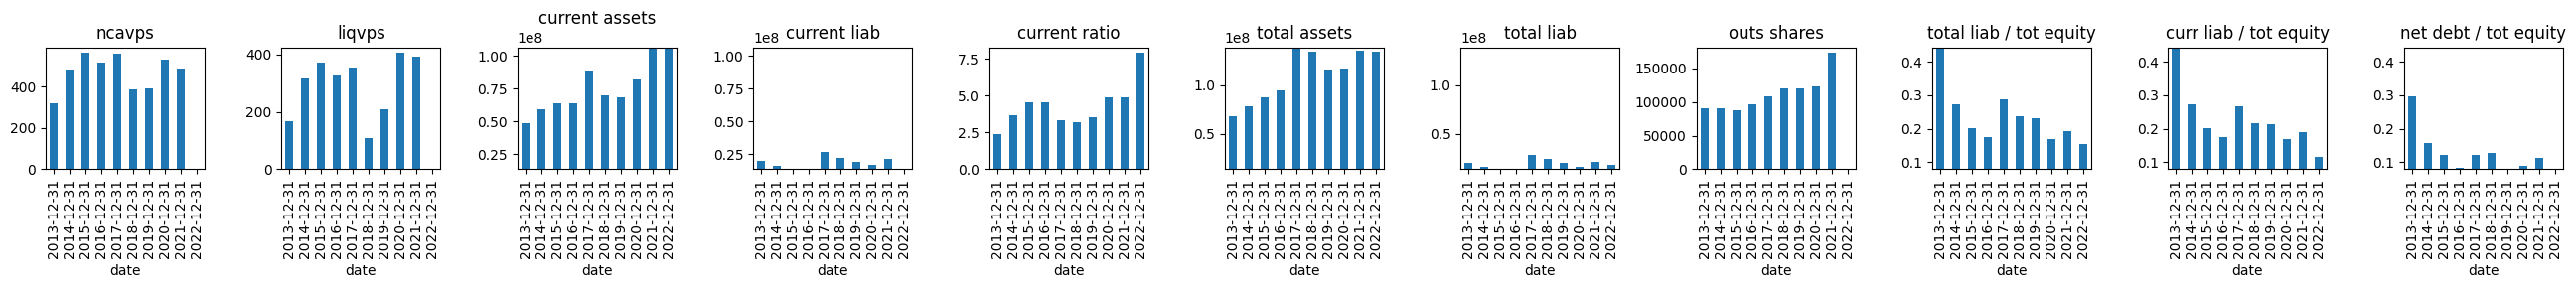

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 937/1013 [25:41<02:25,  1.91s/it]

LBRMF.	 Current price: 0.08.	 NCAV: 0.09183644748152303.	 LIQV: 1.6543188226550047


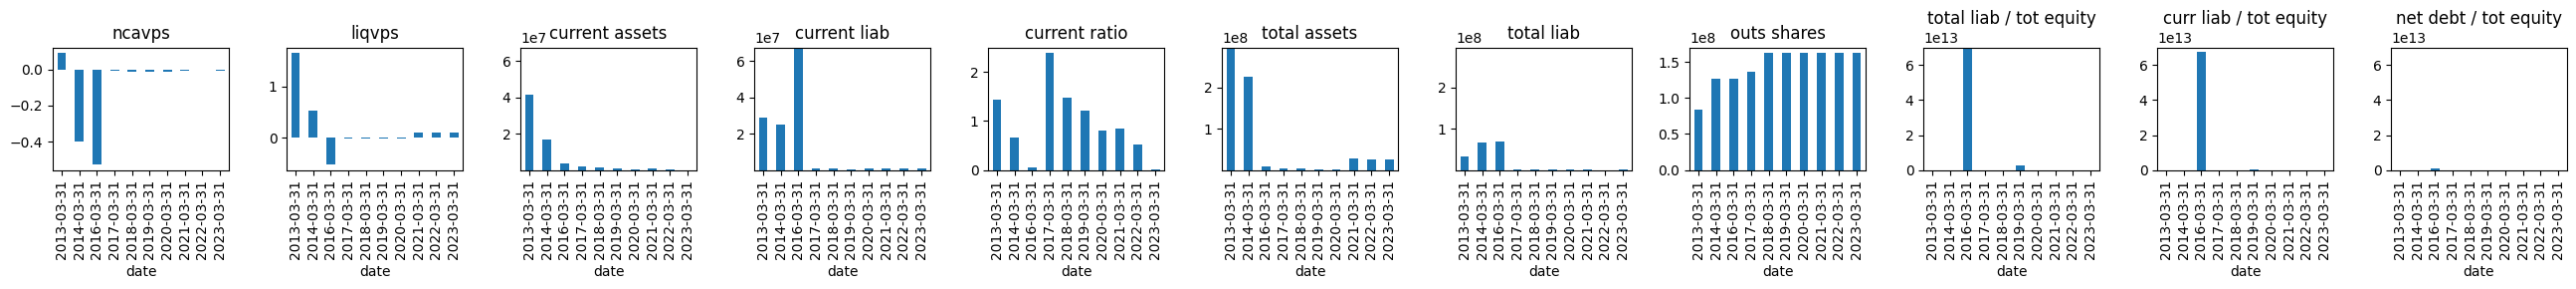

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 943/1013 [25:54<02:10,  1.86s/it]

MACE.	 Current price: 0.09.	 NCAV: 0.43861807369329686.	 LIQV: -0.1170103238427464


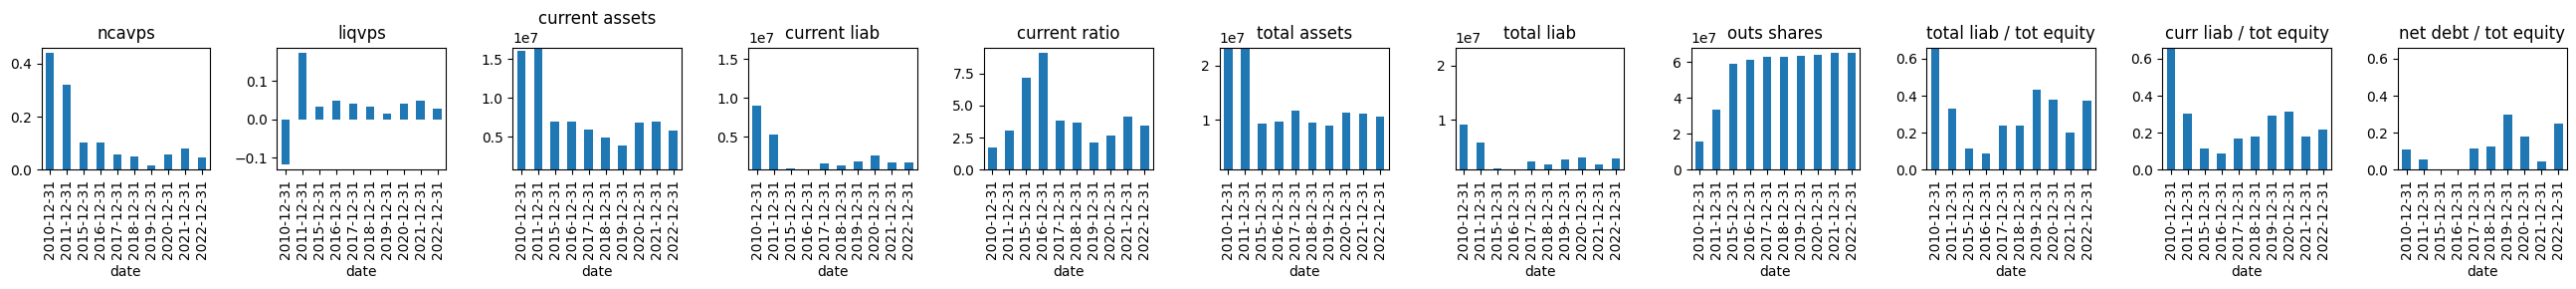

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 945/1013 [26:00<02:31,  2.22s/it]

CNET.	 Current price: 0.8996.	 NCAV: 12.590603996728664.	 LIQV: 10.351595673669674


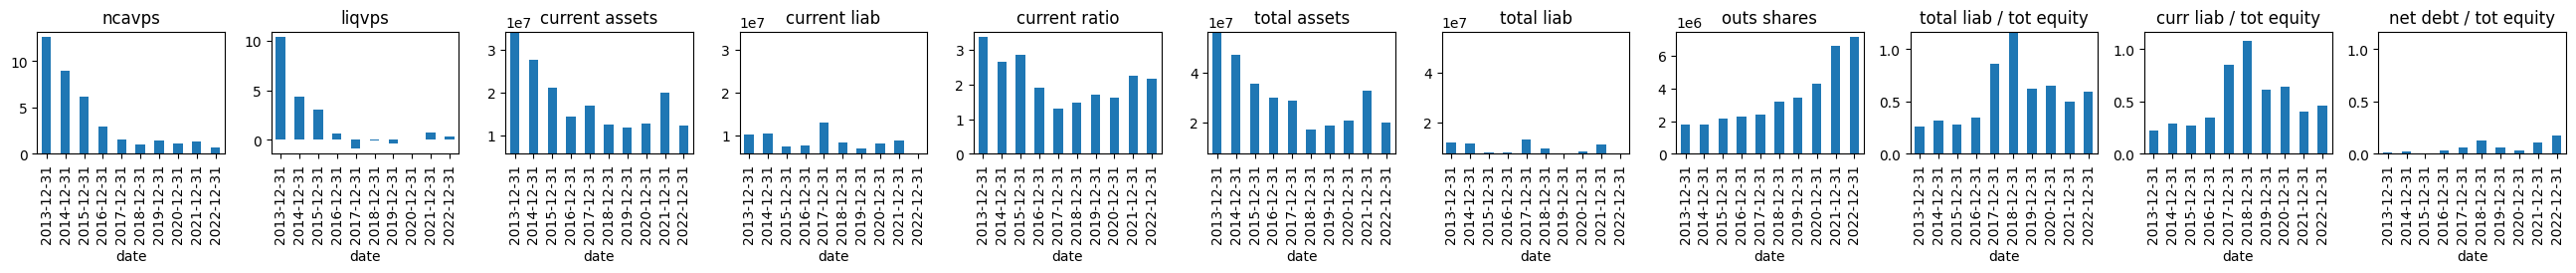

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 947/1013 [26:06<02:31,  2.30s/it]

ELBM.	 Current price: 0.5912.	 NCAV: 2.9747119858404076.	 LIQV: 9.696020582281434


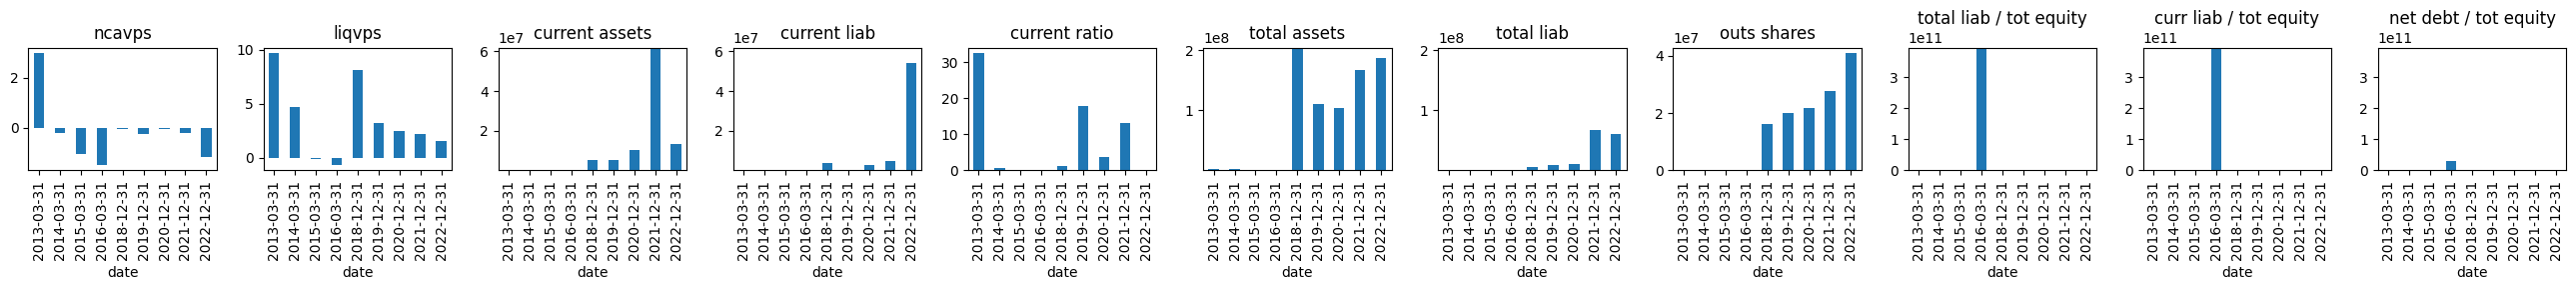

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 973/1013 [26:45<00:49,  1.24s/it]

CLRO.	 Current price: 0.768.	 NCAV: 3.9490168597849427.	 LIQV: 2.3856916141453066


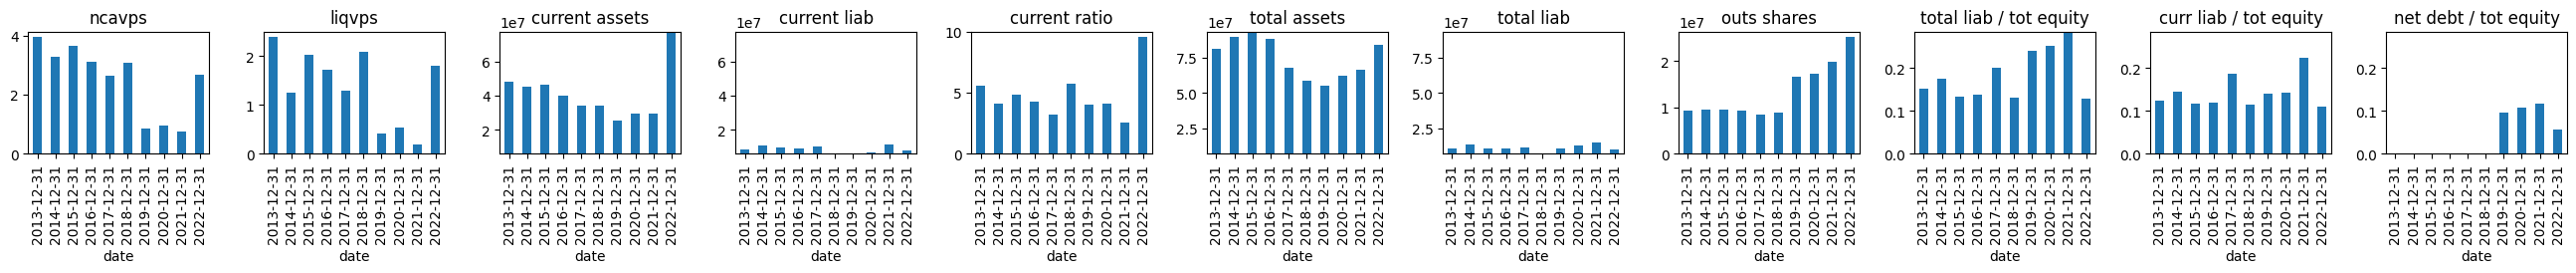

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 988/1013 [27:07<00:47,  1.89s/it]

dates of last income statement and balance sheet are not the same for ticker GAN
	income stmt date: 2014-12-31, balance sheet date: 2017-12-31
PEGY.	 Current price: 0.92.	 NCAV: 8.06015269122653.	 LIQV: 5.972059275544823


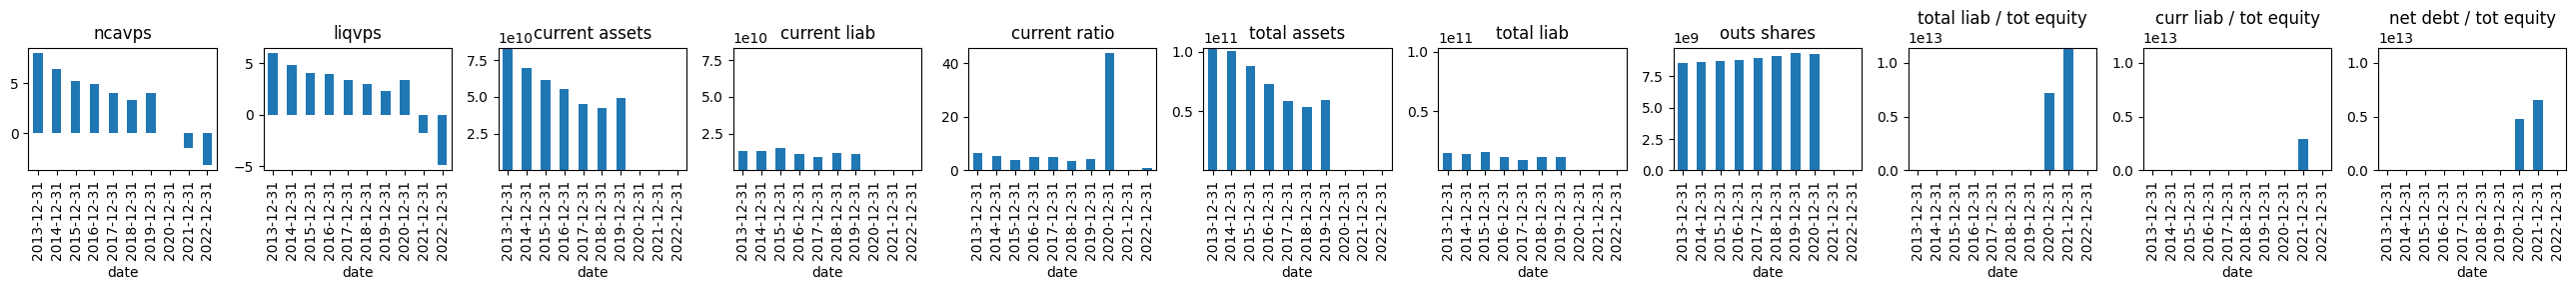

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 995/1013 [27:21<00:28,  1.58s/it]

dates of last income statement and balance sheet are not the same for ticker GDL
	income stmt date: 2010-12-31, balance sheet date: 2017-12-31


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 997/1013 [27:24<00:23,  1.46s/it]

PFHO.	 Current price: 0.8.	 NCAV: 0.811267796077884.	 LIQV: 0.7163360953809956


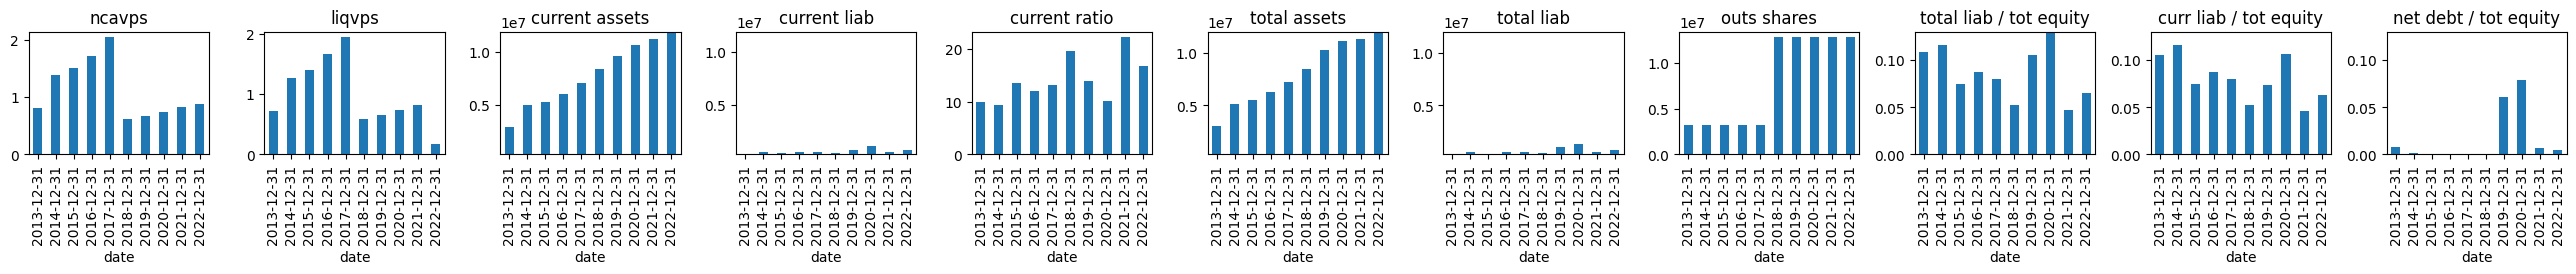

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 999/1013 [27:30<00:31,  2.25s/it]

dates of last income statement and balance sheet are not the same for ticker INBS
	income stmt date: 2018-06-30, balance sheet date: 2017-06-30


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1000/1013 [27:32<00:28,  2.19s/it]

dates of last income statement and balance sheet are not the same for ticker SLRX
	income stmt date: 2015-12-31, balance sheet date: 2014-12-31


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1007/1013 [27:42<00:08,  1.48s/it]

GBHL.	 Current price: 0.0005.	 NCAV: 0.003578735093091841.	 LIQV: 0.0034965807356429784


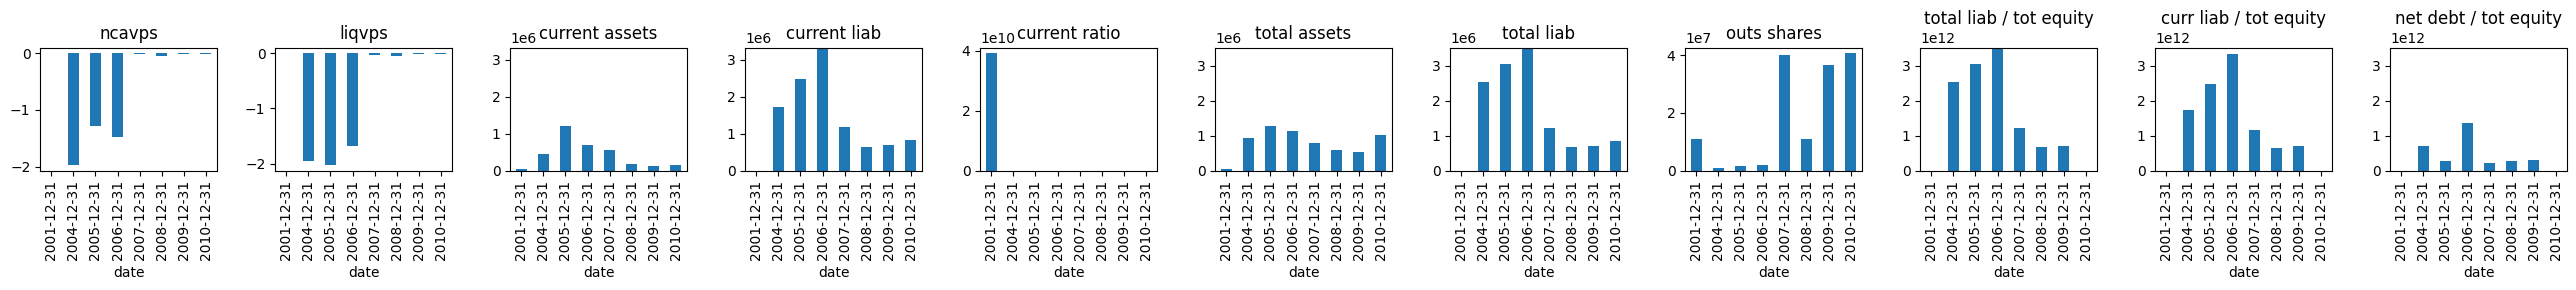

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1009/1013 [27:47<00:07,  1.86s/it]

SEAC.	 Current price: 4.6.	 NCAV: 77.03343725166575.	 LIQV: 67.74283269148481


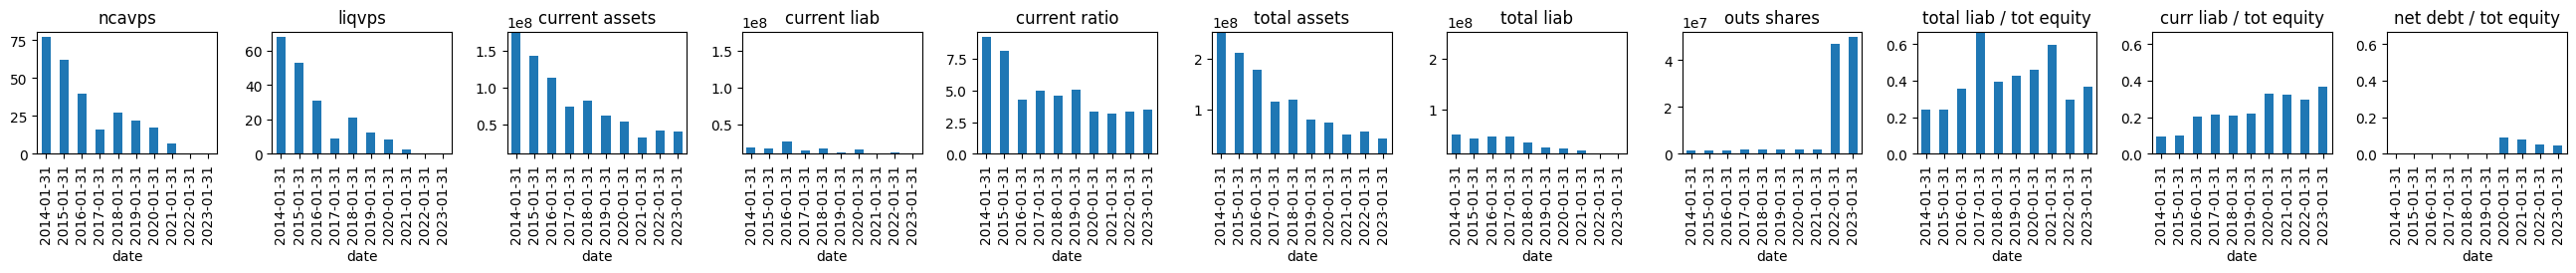

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1011/1013 [27:54<00:05,  2.52s/it]

dates of last income statement and balance sheet are not the same for ticker CSTR
	income stmt date: 2013-12-31, balance sheet date: 2014-12-31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1013/1013 [27:56<00:00,  1.65s/it]

CPU times: user 4min 59s, sys: 22.5 s, total: 5min 22s
Wall time: 27min 56s


In [8]:
%%time
# NEW CODE
# compute preliminary ncav (current assets - total liabilities)
preliminary_ncav = {}
zero_current_price = []
missed_ticker = []
tickers_to_accept = []
notes = {}
full_df = pd.DataFrame()

for ticker in tqdm(TICKERS):
    data_balance_sheet = get_balance_sheet_info(ticker, 10)
    if len(data_balance_sheet) <= 5:
        continue
    data_income_stmt = get_income_stmt_info(ticker, 10)
    if len(data_income_stmt) <= 5:
        continue
    current_price = get_current_price(ticker)
    if current_price is None:
        continue
        
    latest_balance_sheet = data_balance_sheet[-1]
    latest_income_stmt = data_income_stmt[-1]
    latest_balance_sheet.update(
        {
            "weightedAverageShsOutDil": latest_income_stmt["weightedAverageShsOutDil"],
            "income_stmt_date": latest_income_stmt["date"],
        }
    )
    if latest_balance_sheet["date"] != latest_balance_sheet["income_stmt_date"]:
        print(f"dates of last income statement and balance sheet are not the same for ticker {ticker}")
        print(f"\tincome stmt date: {latest_balance_sheet['income_stmt_date']}, balance sheet date: {latest_balance_sheet['date']}")
        continue
    ncavps = compute_ncavps(latest_balance_sheet)
    liqvps = compute_liqvps(latest_balance_sheet, CURRENT_ASSETS_FACTORS)
    if (current_price > ncavps) and (current_price > liqvps):
        continue
    
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    
    try:
        fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    except:
        print("dates incoherence")
        continue
    
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(CURRENT_ASSETS_FACTORS,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio, args=("totalLiabilities",), axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio, args=("totalCurrentLiabilities",), axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio, args=("totalDebt",), axis=1)

    # plot indicators
    print(f"{ticker}.\t Current price: {current_price}.\t NCAV: {ncavps}.\t LIQV: {liqvps}")
    plot_indicators_ncav(fs_df)

    full_df = pd.concat([full_df, fs_df.tail(1)])

    time.sleep(1)

# OLD

In [ ]:
%%time
# NEW CODE
# compute preliminary ncav (current assets - total liabilities)
preliminary_ncav = {}
zero_current_price = []
missed_ticker = []
tickers_to_accept = []
notes = {}

for ticker in tqdm(TICKERS):
    
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=1&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={KEY}"
    url_price = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?limit=1&apikey={KEY}"
    
    try:
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_price = urlopen(url_price, cafile=certifi.where())
    except:
        missed_ticker.append(ticker)
        continue
    
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) == 0:
        continue # here we should log the ticker with this issue
    data_balance_sheet = data_balance_sheet[-1]
    flag = compute_prelim_ncav(data_balance_sheet)
    data_price = response_price.read().decode("utf-8")
    data_price = json.loads(data_price)
    if len(data_price) == 0:
        continue # here we should log the ticker with this issue
    data_price = data_price[-1]
    current_price = data_price["price"]
    if flag:
        
        tickers_to_accept.append(ticker)
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
        data_income_stmt = response_income_stmt.read().decode("utf-8")
        data_income_stmt = json.loads(data_income_stmt)
        if len(data_income_stmt) == 0:
            continue # here we should log the ticker with this issue
        data_income_stmt = data_income_stmt[-1]
        data_balance_sheet.update(
            {
                "weightedAverageShsOutDil": data_income_stmt["weightedAverageShsOutDil"],
                "income_stmt_date": data_income_stmt["date"],
            }
        )
        if data_balance_sheet["date"] != data_balance_sheet["income_stmt_date"]:
            print(f"dates of last income statement and balance sheet are not the same for ticker {ticker}")
            print(f"\tincome stmt date: {data_balance_sheet['income_stmt_date']}, balance sheet date: {data_balance_sheet['date']}")
            continue
            
        ncavps = compute_ncavps(data_balance_sheet)
        liqvps = compute_liqvps(data_balance_sheet, factors)
        if current_price is None : 
            zero_current_price.append(ticker)
            continue
        notes[ticker] = {
            "current_price": current_price,
            "below_ncav": current_price < ncavps,
            "below_liqv": current_price < liqvps,
        }

Transform dict into pandas and add "below_both" and "below_none" cols. below_both is a flag that tells whether the current price is below both ncav and liqv. below_none is a flag that tells whether the current price is above both ncav and liqv. 

In [ ]:
price_to_liquid_df = pd.DataFrame(notes).T
price_to_liquid_df["below_both"] = price_to_liquid_df.apply(lambda x: x["below_ncav"] and x["below_liqv"], axis=1)
price_to_liquid_df["below_none"] = price_to_liquid_df.apply(lambda x: x["below_ncav"] == False and x["below_liqv"] == False, axis=1)
price_to_liquid_df.sample(5)

We filter out the rows having a `below_none` value of True. This represents the rows where the company's current price is above both ncav and liqv

In [ ]:
price_to_liquid_df = price_to_liquid_df.loc[price_to_liquid_df["below_none"] != True]
price_to_liquid_df.shape

In [ ]:
len(tickers_to_accept)

In [ ]:
selected_tickers = list(price_to_liquid_df.index)

* cashAndCashEquivalents
* netReceivables
* inventory
* propertyPlantEquipmentNet
* totalCurrentAssets
* totalLiabilities

### The following values will be computed/extracted over a 10 year period:

- NCAV
- LIQV
- Current Assets
- Current Liab
- Current Ratio
- Total Assets
- Total Liabs
- Shares outstanding
- Total Liab / Total Shareholders' Equity (D/E ratio 1)
- Current Liab / Total Shareholders' Equity (D/E ratio 2)
- Total debt / Total Shareholders' Equity (D/E ratio 3)
- date

In [ ]:
%%time
missed_tickers = []
full_df = pd.DataFrame()
for ticker in selected_tickers:
        
    data_income_stmt = get_income_stmt_info(ticker=ticker, nb_years=10)
    data_balance_sheet = get_balance_sheet_info(ticker=ticker, nb_years=10)

    if len(data_balance_sheet) == 0 or len(data_income_stmt) == 0:
        print("length equals zero")
        missing_tickers.append(ticker)

    if len(data_balance_sheet) < 5 or len(data_income_stmt) < 5:
        print("less than 5 reports")
        time.sleep(1)
        continue

    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    
    try:
        fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    except:
        print("dates incoherence")
        continue
    
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(factors,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio, args=("totalLiabilities",), axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio, args=("totalCurrentLiabilities",), axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio, args=("totalDebt",), axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

    full_df = pd.concat([full_df, fs_df.tail(1)])

    time.sleep(1)

In [ ]:
%%time
missed_tickers = []
full_df = pd.DataFrame()
for ticker in selected_tickers:
    # define urls
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"

    try:
        # load data
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    except:
        missed_tickers.append(ticker)
        
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) < 5:
        continue

    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    if len(data_income_stmt) < 5:
        continue
        
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]

    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(factors,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

    full_df = pd.concat([full_df, fs_df.tail(1)])

    time.sleep(1)

In [ ]:
# stocks selected by hand after visualization of the previous plots
selection = [
    "WILC",
    "HURC",
    "UFI",
    "UEIC",
    "STRT",
    "CNRD",
    #"JRSH",
    "JCTCF",
    "PFHO",
    "BNSO",
    "SSY",
]

In [ ]:
price_df = price_to_liquid_df.loc[selection, ["current_price"]]
price_df

In [ ]:
selection_df = full_df[full_df["symbol"].isin(selection)].reset_index().set_index("symbol")
selection_df

In [ ]:
selection_resumed_df = pd.concat([price_df, selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [ ]:
selection_resumed_df["price_to_ncav"] = selection_resumed_df["current_price"] / selection_resumed_df["ncavps"]
selection_resumed_df["price_to_liqv"] = selection_resumed_df["current_price"] / selection_resumed_df["liqvps"]

In [ ]:
selection_resumed_df.sort_values(by="price_to_ncav")

In [ ]:
selection_resumed_df.sort_values(by="price_to_liqv")

In [ ]:
# stocks selected by hand after visualization of the previous plots
snd_selection = [
    "GIFI",
    "ADES",
    "UTSI",
    "NTWK",
    "GIGM",
    "MSN",
    "WAFU",
    "JVA",
    "EVOL",
    "QBAK",
]

In [ ]:
snd_price_df = price_to_liquid_df.loc[snd_selection, ["current_price"]]
snd_price_df

In [ ]:
snd_selection_df = full_df[full_df["symbol"].isin(snd_selection)].reset_index().set_index("symbol")
snd_selection_df

In [ ]:
snd_selection_resumed_df = pd.concat([snd_price_df, snd_selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [ ]:
snd_selection_resumed_df["price_to_ncav"] = snd_selection_resumed_df["current_price"] / snd_selection_resumed_df["ncavps"]
snd_selection_resumed_df["price_to_liqv"] = snd_selection_resumed_df["current_price"] / snd_selection_resumed_df["liqvps"]

In [ ]:
snd_selection_resumed_df.sort_values(by="price_to_ncav")

In [ ]:
snd_selection_resumed_df.sort_values(by="price_to_liqv")

In [ ]:
thd_selection = [
    "CSTE",
    "CNRD",
    "GIFI",
    "UTSI",
    "GURE",
    "GIGM",
    "MSN",
    "JVA",
    "QBAK",
]

In [ ]:
thd_price_df = price_to_liquid_df.loc[thd_selection, ["current_price"]]
thd_price_df

In [ ]:
thd_selection_df = full_df[full_df["symbol"].isin(thd_selection)].reset_index().set_index("symbol")
thd_selection_df

In [ ]:
thd_selection_resumed_df = pd.concat([thd_price_df, thd_selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [ ]:
thd_selection_resumed_df["price_to_ncav"] = thd_selection_resumed_df["current_price"] / thd_selection_resumed_df["ncavps"]
thd_selection_resumed_df["price_to_liqv"] = thd_selection_resumed_df["current_price"] / thd_selection_resumed_df["liqvps"]

In [ ]:
thd_selection_resumed_df.sort_values(by="price_to_ncav")

In [ ]:
thd_selection_resumed_df.sort_values(by="price_to_liqv")

### Stocks To dig into

In [ ]:
int_selection = [
    "JCTCF",
    "IVAC",
    "ADES",
    "VHC",
    "CVR",
    "GSMG",
    "BNSO",
    "GIFI",
    "USNU",
    "NCSM",
    "WILC",
    "GIGM",
    "STRT",
    "HURC",
    "MSN",
    "NTWK",
    "SSY",
    "SKAS",
    "CAAS",
    "UFI",
    "CSTE",
    "JVA",
    "TOFB",
]

In [ ]:
int_price_df = price_to_liquid_df.loc[int_selection, ["current_price"]]
int_price_df

In [ ]:
int_selection_df = full_df[full_df["symbol"].isin(int_selection)].reset_index().set_index("symbol")
int_selection_df

In [ ]:
int_selection_resumed_df = pd.concat([int_price_df, int_selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [ ]:
int_selection_resumed_df["price_to_ncav"] = int_selection_resumed_df["current_price"] / int_selection_resumed_df["ncavps"]
int_selection_resumed_df["price_to_liqv"] = int_selection_resumed_df["current_price"] / int_selection_resumed_df["liqvps"]

In [ ]:
int_selection_resumed_df.sort_values(by="price_to_ncav")

In [ ]:
int_selection_resumed_df.sort_values(by="price_to_liqv")

### Set of questions that I should ask myself after I have identified potentially good opportunities

* Do I know why the company is undervalued?
* Is the reason for the company to be undervalued transitory?
* Which percentage of the company operations are in China?
* Does the company work in one of the industries that I discard?
* Does the company have significant off-balance sheet liabilities?
* What type of inventory and receivables does the company have?
* Am I certain of the calculations?
* Has the company been trading below liq value for a long time?

### How to transform those questions into prompts to feed a LLM-based search engine ?

* are there any recent negative news about the company {COMPANY_NAME}?
* have there been any recent scandals or controversies involving {COMPANY_NAME}?
* Are there any pending lawsuits or legal issues involving {COMPANY_NAME}?
    * What is the current status on the lawsuit?
    * Go deeper in this one ...
* recent stock catalysts for {COMPANY_NAME}
    * Have there been any recent developments or announcements related to {COMPANY_NAME}' products or services
    * is there any recent news about merge and acquisitions regarding {COMPANY_NAME}?
    * Dig deeper on this one
* are there insiders stock purchases in {COMPANY_NAME}?

## Analyzed Companies

*Date : 20/06/2023*

**WILC** : 

- bunch of scandals : funds malversation in 2006, 2009, 2016 and they have ongoing processes
- I think not a good investment 

**SSY** : 

- They stopped their repurchase plan in 2020 cuz of COVID
- Reduced demand for certain hospital services
- Not a clear vision on how/when the conditions will go back to normal
- Should go down for it to be a more attractive investment. At 0.72 it'll have a MOS of 33% to NCAV

**EVOL** : 

- Former CEO quit but still part of the board of directors. I think not a big issue
- They sold their two main business operations in Jan 2022
- Dutch auction tender offer june 2022 (shares buyback sort of)
- They'll be a R&D company for now in Machine Learning and similar fields
- Very cheap (price/ncav of 26% so 74% discount), but should have a more clear business model or catalyst for it to be worth it
- 
- They're buying back shares and ncav as of 29/08/2023 is 2.6 vs price of 0.56

*Date 21/06/2023*

**GIGM** : 
* Decreasing total revenues
* The stock is often trading below liquidation value. Last time above liqvps was 15/08/2021. Another run was aug 2022 but not above liqv or ncav
* On 2014 they published in their financial statement of 2013 that they're sentitive to copyright infringement. There might be a correlation between this and the decline, but not sure
* They want to expand through companies purchases (M&A) so this is going to burn the cash and current assets a bit if any of the opportunities is seized
* Burn rate of around 10%
* According to its last run til 1.87, I estimate that the company should trade at around 1.15 to make a safe 50% if the stock goes all the way up til 1.7 (conservative estimation since the ncavps is 4.024298 and liqvps is 3.258609)
*
* As of 29/08/2023 they're ncav is 3.9 and price is 1.4 

*Date 26/06/2023*

**MSN** : 

* It's a company that does not disclose much information
* The performance has been weaker and weaker since 2015 (judging by ncav)
* information about how sensitive they are to copyright infringement if it happens
* Control of Emerson Radio Corp changed twice since 2016
* No news of potential catalyst (positive of negative)
* if next burn rate of 12% (burn rate between 2021 and 2022) the price to ncavps will still be 0.49 (51% discount)


*Date 27/06/2023*

**ADES**:

* Violation of some GAAP stuff in 2017. In January 2022 a fair fund approved to pay the "harmed" investors -> The doc was published in Jan 2023. ADES had to pay some money to the SEC. It's settled
* Appointment of a new member to the board of directors that might bring relevant expertise 
* Company provides solutions to coal-powered plants but seems like more on limiting pollution. No clear track of ADES affected by contamination scandals
* They bought Arq Limited in august 2022. That might have hit a bit the price.
* Big flop in earnings reports (-220%) of May.
* Value is there when using data of dec 2022
* They diluted shares in 2023



*Date 28/06/2023*

**GURE**

* Chinese

**UTSI**

* Chinese

**USNU**

* court case in 2010 with another company but not a scandal type of thing
* court case in 2020 for improper billing practices and they had to pay 1M
* burn rate of 16%
* in the last two years it has reached ncav levels
* Below 0.05 could be attractive (at 0.05 it would have a MOS of 30%)

*Date 29/06/2023*

**JRSH**

* Actual ncavps is 3.39837
* Actual liqvps is 3.21024
* It was constantly growing until the last report two days ago
* lower sales from two major U.S. customers
* shipments being deferred by customers to the fiscal 2024
* shift in product mix to lower margin items (??? dont' know if of customers or company)
* according to CEO:  retail continues face a weak economic env, consumers limiting spending on higher priced items
* They're looking to expand/grow
* 2024 might be the same as 2023
* focused on expanding their customer base, increasing production capacity, and improving operational efficienc
* acquired property in 2019 that they plan to develop as market conditions improve
* Should fall below 2.2 to be more attractive in current conditions

*Date 30/06/2023*

**JVA**

* Bought Steep N Brew in 2018 and in 2022 the announced they got rid of it cuz not that profitable
* They increased debt (long term debt)
* They will be acquired by Delta Corp Holdings Limited, but they aren't a public company -> better to steer away from it

**NCSM**

* changes in its leadership and management team after CEO retirement
* a couple of lawsuits one settled in 2020 and the other won 2022
* They acquired Spectrum Tracer Services in 2017
* I don't know why it is undervalued wrt both ncav and liqv <------
* At current date it is at 30% discount of NCAV (17). Recheck around 15
* They incresed a lot their liabilities and now their NCAV (23-08-23) is around 5

*Date 04/07/2023*

**STRT**

* They are diluting some shares
* Gross profit decreasing since 2021
* Their net income goes up and down
* One case in 1997 where STRT filed a lawsuit against General Automotive for infringement but no infringement was found
* one case in 2006 apparently but not much info found
* They sold their 1/3rd stake in a joint venture and gained full control of the other joint venture they had with the same company (at least under the restructuring agreement I read about)
* They have relatively solid customers like Hyundai/Kia, Ford, GM
* They plan to explore and execute targeted mergers and acquisitions in the foreseable future (direction not specified)
* Mergin is low: now it is a 15% of discount relative to NCAV. Recheck if stock price goes below 17

*Date 05/07/2023*

**HURC**

* They're buying back shares
* They increased dividend payment and their payout ratio is above 100%
* Significantly high institutional ownership (61%) -> stock price might be sensitive to their trading actions
* They bought a company in 2019
* For a margin of safety of around 33% check below 19
* Their NCAV is growing but they are not growing sales or income

**SKAS**
* NCAV trending upwards
* gros profit recovering pre-covid values
* Net income getting better (higher)
* Stable outstanding shares
* In 2016 they acquired an aircraft maintenance services company
* Lawsuit filed against SKAS in 2021 but no further information about it
* SKAS' subsidiary bought by a company on sept 2022 -> SKAS will not engage in any business involving the operation of a fixed based operation supplying aviation fuels and lubricants or the supply of other goods or provision of services typically supplied or performed at fixed base operations at airports at any facility located within one hundred (100) miles of the Garden City Regional Airport in Garden City, Kansas
* Got a concession to operate exclusively in a manhattan heliport on April 30, 2023 -> I Think this contract was cancelled due to conflic of interest
* Now the company is trading at a 25% discount to NCAV
*
* NCAV 6.4 & LIQV 6.1 on 26/08/23
* Had a negative quarter in march 2023 and now positive again
* Trading at 13% of current ncav and 21% of projected ncav @ 10% growth in 2024. Re-assess @ 5

*Date 26/07/2023*

**JCTCF**

* They closed their Jewett-Cameron Seed Company (JCSC) subsidiary cuz flat revenues and rising operating costs
* Buying back shares
* affected by higher cost from China and all accross the US since after covid
* Unable to pass costs to consumers
* ex CFO was bullish in mid-2022 (seekingalpha articles) and stock is cheaper now
* No inside purchases
* 59% of outs shared owned by institutions
* stock price should fall below 4 to have a MOS of in 2024 of 33% (including growth projections)

*Date 02/08/2023*

**VHC**

* NCAV is 2.12 and LIQV is 1.2 -> mos of 0.78 (ncav) and 0.61 (liqv)
* They lost 2 patents in court that vhc has accused Apple of infringing. News came out at end of march 2023
* It seems that the grow in NCAV is due to the money that Apple paid to them after the first court verdict
* They declared a special dividend of 1$ per share at the end of march -> negative for the valuation but won't be constant
* VHC committed to promptly distribute to shareholders 80% of future proceeds, if any, and net of related legal costs, licensing costs and taxes, that it receives from its current litigation with Apple
* On june 2023, They signed an NDA with a company/holding to sell their products
* Kendall Larsen, President & CEO purchased stocks in the open market on june 2023 and on may 2023, others from the board bought too (between 0.38 & 0.44)
* This look like a buy

*Date 03/08/2023*

**GIFI**

* They got inot shipyards in 2016 that didn't turn as profitable as expected. They started steering away from it in 2019
* Lawsuit in january 2023 for wrongful termination of a contract. If they lose I think they'll have to pay something. The trial is expected to take place on October 16th, 2023
* There are some talks with one of the institution holders to see how to improve the stock perf, among other things (news from june 2023)
* People from the obard have exercised (bought) stocks at around 3.25 on june 1st, 2023
* Today is just slightly below ncav. It should be below 2.4 for a mos of 33% -> To recheck after the trial of October 16th, 2023

*Date 24/08/2023*

**TOFB**

* The latest NCAV is slightly lower than the one from Dec 2022 (0.63 vs 0.67)
* MOS of 33% from 0.63 @ 0.41
* The 10y trend in upwards
* Mostly stable shared outstanding
* They received notification that they should stay 10 consecutive days with market cap > 5M to stay in OTCX, otherwise they'll go to OTCB
* Revenues are lower than same period last year
* net income is negative since june 2022
* They increase inventory since 2022 but it's been like that for the last 5 quarters (product eventually expires but maybe they just increased production & distribution capabilities
* As a general note I should learn how to identify when a company increases production / distribution capabilities by looking at their financial statement :)

*25/08/2023*

**CVR**

* The company pays dividends every quarter but they cut it from 0.22 to 0.10 per share
* Last NCAV is 16.7. Should be around 11 for a MOS of 33%
* Their ncav and assets are growing for 10 years
* Slight decrease of revenues. Negative net income since december 2022
* Stable shares
* No inisiders purchases
* They have been granted permission to build stuff for a medical application
* Quite silent company in the news

**NTWK**

* Stable nb of shares
* First positive quarter (net income) since march 2022
* Their assets are decreasing but their liabilities are also decreasing
* Recognized by Monitor Daily in ‘Most Innovative Companies in the Equipment Finance Ecosystem’ on April 2023
* They earned a AWS CloudFormation Badge for their expertise in the stuff on April 2023
* They earned Buy Rating from StockNews.com -> perhaps positive sentiment
* The president purchased stocks @ 2.19 for a total of 400K+ on 06/26/2023. And he purchased a lot more earlier this year
* I generally like it. NCAV 1.97. Should be at 1.3 for a MOS of 33%

**CAAS**

* Chinese

*28/08/2023*

**IVAC**

* There is some shares dillution
* Their revenues dropped significantly and their net income became negative since 2022
* 3% increase in revenues from last quarter. 160% increase in revenues from Q1 2022 (I did not confirm it myself)
* They work with thin-film products that HDD use. The HDD industry seems to be a complicated right now
* They explore "strategic alternatives for the business"
* The stock is @ 90%+ of NCAV (stock price 3.43). It seems likely that it will keep going down

**UFI**

* NCAV 4.36 so company is overpriced
* Stable shares
* The legal advisor of the company and board member is buying shares since the beginning of the year for more than its current public price of 6.40
* They bought the company Nylon Portfolio of Fiber and Yarn Products, Inc but I cannot find further info
* Check below 3 for a MoS

**BNSO**
* They suspended their reports filings in the US -> They are not subject anymore to SEC standards. This is a double-edged sword
* 0.16 ncav, 1.17 liqv -> Company overvalued @ 2.63
* Not sure it is worth digging deeper at the moment

**CSTE**
* ncav 1.92 (overvalued), liqv 4.74 (13% MOS)
* Struggling with expenses and a slowing U.S. market in Q3 2023
* In March 2023 they named CEO the was who was CEO between 2009 to 2016
* They closed a plant and fired 150 employees to reduce costs
* It is expected that the plant closing will cost 4 - 8 M USD til Q2 2024
* They expect to save 10 to 15 M USD with the possibility to save more after the closing process is accomplished
* Check around 3 for a MOS of ~ 36%

### List of companies

*Date 20/06/2023*

"TK",
"SSY",
"JRSH",
"TUSK",
"USNU",
"HURC",
"NCSM",
"UTSI",
"GURE",
"NTWK",
"STRT",
"WILC",
"MSN",
"SKAS",
"ADES",
"JVA",
"UFI",
"GIGM",
"WAFU",
"JCTCF",
"BNSO",
"GIFI",

*Date 02/08/2023*

"NCSM",
"ADES",
"HURC",
"TOFB",
"SSY",
"USNU",
"GURE",
"UFI",
"JCTCF",
"WAFU",
"GIFI",
"TUSK",
"VHC",
"NTWK",
"SKAS",
"MSN",
"UTSI",

*Date 22/08/2023*

"JCTCF",
"IVAC",
"ADES",
"VHC",
"CVR",
"GSMG",
"BNSO",
"GIFI",
"USNU",
"NCSM",
"WILC",
"GIGM",
"STRT",
"HURC",
"MSN",
"NTWK",
"SSY",
"SKAS",
"CAAS",
"UFI",
"CSTE",
"JVA",
"TOFB",

## TMP ##

In [ ]:
%%time
#missed_tickers = []
#full_df = pd.DataFrame()
for ticker in ["TSN"]:
    # define urls
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"

    try:
        # load data
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    except:
        missed_tickers.append(ticker)
        
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) < 5:
        continue

    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    if len(data_income_stmt) < 5:
        continue
        
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]

    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(factors,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

In [ ]:
fs_df

In [ ]:
((fs_df["ncavps"] - fs_df["ncavps"].shift()) / fs_df["ncavps"].shift())

In [ ]:
fs_df["ncavps"]

In [ ]:
6.44/(6.62*1.2)